In [25]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

In [7]:
path = './Data'
dfs = {}

files = os.listdir(path)
for f in files:
    _path = path + '/' + f
    if os.path.isfile(_path):
        dfs[_path] = pd.read_csv(_path)
    else:
        subfiles = os.listdir(_path)
        for sf in subfiles:
            _path = path + '/' + f + '/' + sf
            if os.path.isfile(_path):
                dfs[_path] = pd.read_csv(_path)
                
del dfs['./Data/wordPressNormalandAttack/NormalV1.1.csv']  # данные с сайта wordpress,
                                                           # они нам не нужны дл обучения              

df = pd.concat([i[1] for i in dfs.items()])
df = shuffle(df)
print('Признаки:\n', ', '.join(df.columns))
df.head()

Признаки:
 Row, udp, select, bin, run, poll, media, sys, dev, etc, usr, root, host, brk, boot, mkdir, write, connect, tcp, clone_API, proc, read, var, network_http, File_IO, kill_API, accept, home, munmap, mnt, opt, rename, srv, mmap, chdir_API, network_connection, execve_API, Normal, Attack


,Row,udp,select,bin,run,poll,media,sys,dev,etc,...,mnt,opt,rename,srv,mmap,chdir_API,network_connection,execve_API,Normal,Attack
2081,0,0,41,0,0,154,0,0,0,252,...,0,0,0,0,56,28,1583,0,0,1
763,0,0,40,0,0,176,0,0,0,288,...,0,0,0,0,64,32,1812,0,0,1
2,0,0,41,0,0,176,0,0,0,288,...,0,0,0,0,64,32,1816,0,0,1
2499,0,0,42,0,0,176,0,0,0,288,...,0,0,0,0,64,32,1813,0,0,1
1848,0,0,41,0,0,176,0,0,0,288,...,0,0,0,0,64,32,1816,0,0,1


In [8]:
# Разбиваем датасет на два, с нормальным поведением и аномалиями
# Также датасет с нормальным поведением разбиваем на трейн и тест

df_norm = df[df.Normal == 1].drop(['Normal', 'Attack'], axis=1)
df_atck = df[df.Attack == 1].drop(['Normal', 'Attack'], axis=1)

assert(len(df_norm) + len(df_atck) == len(df))

test_size=0.3
idx = int(len(df_norm)*(1 - test_size))
X_train, X_test = df_norm.iloc[:idx], df_norm.iloc[idx:]

In [89]:
# N = X_train.shape[1]

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [90]:
nb_epoch = 10000
batch_size = 32

autoencoder.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                    validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

# history = autoencoder.history

Train on 6384 samples, validate on 2737 samples
Epoch 1/10000
6384/6384 [==============================] - 1s 151us/step - loss: 2781816.4571 - acc: 0.6994 - val_loss: 2761424.3167 - val_acc: 0.8133
Epoch 2/10000
6384/6384 [==============================] - 0s 63us/step - loss: 2781143.7901 - acc: 0.8114 - val_loss: 2760877.7910 - val_acc: 0.8151
Epoch 3/10000
6384/6384 [==============================] - 0s 63us/step - loss: 2780618.6331 - acc: 0.8148 - val_loss: 2760372.2037 - val_acc: 0.8173
Epoch 4/10000
6384/6384 [==============================] - 0s 68us/step - loss: 2780004.9624 - acc: 0.8315 - val_loss: 2759473.9766 - val_acc: 0.8334
Epoch 5/10000
6384/6384 [==============================] - 1s 84us/step - loss: 2778984.5520 - acc: 0.8354 - val_loss: 2758550.0362 - val_acc: 0.8308
Epoch 6/10000
6384/6384 [==============================] - 0s 69us/step - loss: 2778117.3239 - acc: 0.8330 - val_loss: 2757729.8623 - val_acc: 0.8283
Epoch 7/10000
6384/6384 [==========================

Epoch 55/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2743240.9806 - acc: 0.7870 - val_loss: 2723105.0762 - val_acc: 0.7702
Epoch 56/10000
6384/6384 [==============================] - 0s 58us/step - loss: 2742539.9981 - acc: 0.7787 - val_loss: 2722408.1804 - val_acc: 0.7727
Epoch 57/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2741840.7785 - acc: 0.7827 - val_loss: 2721714.6401 - val_acc: 0.7581
Epoch 58/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2741142.1404 - acc: 0.7805 - val_loss: 2721022.1297 - val_acc: 0.7779
Epoch 59/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2740445.3246 - acc: 0.7741 - val_loss: 2720328.8470 - val_acc: 0.7709
Epoch 60/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2739758.0905 - acc: 0.7737 - val_loss: 2719658.0232 - val_acc: 0.7176
Epoch 61/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2739068.9655 

6384/6384 [==============================] - 0s 61us/step - loss: 2702769.7014 - acc: 0.6313 - val_loss: 2682851.0584 - val_acc: 0.6061
Epoch 110/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2702026.9091 - acc: 0.6306 - val_loss: 2682113.8345 - val_acc: 0.6138
Epoch 111/10000
6384/6384 [==============================] - 0s 57us/step - loss: 2701283.2876 - acc: 0.6295 - val_loss: 2681370.6270 - val_acc: 0.6047
Epoch 112/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2700543.3969 - acc: 0.6275 - val_loss: 2680646.6730 - val_acc: 0.6529
Epoch 113/10000
6384/6384 [==============================] - 0s 55us/step - loss: 2699804.2578 - acc: 0.6258 - val_loss: 2679898.3811 - val_acc: 0.6007
Epoch 114/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2699057.2691 - acc: 0.6205 - val_loss: 2679164.1373 - val_acc: 0.5988
Epoch 115/10000
6384/6384 [==============================] - 0s 67us/step - loss: 2698315.7603 - acc: 0.

Epoch 163/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2663138.8315 - acc: 0.5747 - val_loss: 2643457.0860 - val_acc: 0.5590
Epoch 164/10000
6384/6384 [==============================] - 0s 54us/step - loss: 2662436.0946 - acc: 0.5849 - val_loss: 2642732.5147 - val_acc: 0.5612
Epoch 165/10000
6384/6384 [==============================] - 0s 58us/step - loss: 2661687.6222 - acc: 0.5872 - val_loss: 2642014.7671 - val_acc: 0.5353
Epoch 166/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2660954.9649 - acc: 0.6039 - val_loss: 2641285.4056 - val_acc: 0.5977
Epoch 167/10000
6384/6384 [==============================] - 0s 67us/step - loss: 2660227.2585 - acc: 0.6172 - val_loss: 2640561.2689 - val_acc: 0.6080
Epoch 168/10000
6384/6384 [==============================] - 0s 61us/step - loss: 2659537.7773 - acc: 0.6192 - val_loss: 2639857.2672 - val_acc: 0.5999
Epoch 169/10000
6384/6384 [==============================] - 0s 56us/step - loss: 265877

Epoch 217/10000
6384/6384 [==============================] - 0s 61us/step - loss: 2624339.6209 - acc: 0.6175 - val_loss: 2604879.2473 - val_acc: 0.6028
Epoch 218/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2623639.8922 - acc: 0.6087 - val_loss: 2604169.9174 - val_acc: 0.5882
Epoch 219/10000
6384/6384 [==============================] - 0s 55us/step - loss: 2622913.1137 - acc: 0.6098 - val_loss: 2603474.0545 - val_acc: 0.5952
Epoch 220/10000
6384/6384 [==============================] - 0s 54us/step - loss: 2622254.1062 - acc: 0.6001 - val_loss: 2602838.7659 - val_acc: 0.5776
Epoch 221/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2621536.6366 - acc: 0.5888 - val_loss: 2602113.4502 - val_acc: 0.5747
Epoch 222/10000
6384/6384 [==============================] - 0s 63us/step - loss: 2620799.4355 - acc: 0.5899 - val_loss: 2601362.5396 - val_acc: 0.5700
Epoch 223/10000
6384/6384 [==============================] - 0s 64us/step - loss: 262007

Epoch 271/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2586308.5592 - acc: 0.5487 - val_loss: 2567078.9953 - val_acc: 0.5243
Epoch 272/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2585596.5247 - acc: 0.5478 - val_loss: 2566363.0066 - val_acc: 0.5217
Epoch 273/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2585020.1610 - acc: 0.5525 - val_loss: 2565809.9466 - val_acc: 0.4892
Epoch 274/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2584299.4746 - acc: 0.5154 - val_loss: 2565078.0074 - val_acc: 0.4881
Epoch 275/10000
6384/6384 [==============================] - 0s 61us/step - loss: 2583577.5990 - acc: 0.5186 - val_loss: 2564363.4216 - val_acc: 0.4991
Epoch 276/10000
6384/6384 [==============================] - 1s 82us/step - loss: 2582872.0075 - acc: 0.5378 - val_loss: 2563661.0459 - val_acc: 0.5217
Epoch 277/10000
6384/6384 [==============================] - 1s 90us/step - loss: 258216

Epoch 325/10000
6384/6384 [==============================] - 0s 57us/step - loss: 2549065.5435 - acc: 0.5269 - val_loss: 2530060.0881 - val_acc: 0.4936
Epoch 326/10000
6384/6384 [==============================] - 0s 68us/step - loss: 2548346.5160 - acc: 0.5166 - val_loss: 2529354.9114 - val_acc: 0.5104
Epoch 327/10000
6384/6384 [==============================] - 0s 58us/step - loss: 2547653.3697 - acc: 0.5257 - val_loss: 2528666.7886 - val_acc: 0.5133
Epoch 328/10000
6384/6384 [==============================] - 0s 71us/step - loss: 2546949.6773 - acc: 0.5343 - val_loss: 2527992.4422 - val_acc: 0.5119
Epoch 329/10000
6384/6384 [==============================] - 0s 71us/step - loss: 2546261.4812 - acc: 0.5321 - val_loss: 2527300.9642 - val_acc: 0.5148
Epoch 330/10000
6384/6384 [==============================] - 0s 70us/step - loss: 2545568.4474 - acc: 0.5321 - val_loss: 2526589.2779 - val_acc: 0.5090
Epoch 331/10000
6384/6384 [==============================] - 0s 57us/step - loss: 254486

Epoch 379/10000
6384/6384 [==============================] - 0s 69us/step - loss: 2512110.0085 - acc: 0.5526 - val_loss: 2493346.9419 - val_acc: 0.5513
Epoch 380/10000
6384/6384 [==============================] - 0s 66us/step - loss: 2511435.1900 - acc: 0.5576 - val_loss: 2492658.2865 - val_acc: 0.5371
Epoch 381/10000
6384/6384 [==============================] - 0s 71us/step - loss: 2510759.1814 - acc: 0.5495 - val_loss: 2491986.5674 - val_acc: 0.5071
Epoch 382/10000
6384/6384 [==============================] - 0s 55us/step - loss: 2510075.4187 - acc: 0.5451 - val_loss: 2491347.5894 - val_acc: 0.4768
Epoch 383/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2509459.8111 - acc: 0.5349 - val_loss: 2490686.3688 - val_acc: 0.5079
Epoch 384/10000
6384/6384 [==============================] - 0s 57us/step - loss: 2508739.8853 - acc: 0.5376 - val_loss: 2490025.1543 - val_acc: 0.4921
Epoch 385/10000
6384/6384 [==============================] - 0s 66us/step - loss: 250807

Epoch 433/10000
6384/6384 [==============================] - 0s 56us/step - loss: 2476040.9016 - acc: 0.5233 - val_loss: 2457503.2330 - val_acc: 0.5049
Epoch 434/10000
6384/6384 [==============================] - 0s 77us/step - loss: 2475383.8346 - acc: 0.5291 - val_loss: 2456846.1213 - val_acc: 0.5075
Epoch 435/10000
6384/6384 [==============================] - 1s 79us/step - loss: 2474693.3988 - acc: 0.5226 - val_loss: 2456187.1045 - val_acc: 0.4969
Epoch 436/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2474028.3465 - acc: 0.5276 - val_loss: 2455553.2353 - val_acc: 0.5225
Epoch 437/10000
6384/6384 [==============================] - 0s 77us/step - loss: 2473362.6689 - acc: 0.5284 - val_loss: 2454890.9652 - val_acc: 0.5221
Epoch 438/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2472728.7873 - acc: 0.5324 - val_loss: 2454324.1166 - val_acc: 0.5448
Epoch 439/10000
6384/6384 [==============================] - 0s 68us/step - loss: 247208

Epoch 487/10000
6384/6384 [==============================] - 0s 66us/step - loss: 2440484.7779 - acc: 0.5868 - val_loss: 2422182.7271 - val_acc: 0.5754
Epoch 488/10000
6384/6384 [==============================] - 0s 74us/step - loss: 2439832.7306 - acc: 0.5893 - val_loss: 2421533.4951 - val_acc: 0.5685
Epoch 489/10000
6384/6384 [==============================] - 1s 111us/step - loss: 2439175.1313 - acc: 0.5938 - val_loss: 2420881.1562 - val_acc: 0.5751
Epoch 490/10000
6384/6384 [==============================] - 1s 83us/step - loss: 2438520.2372 - acc: 0.5995 - val_loss: 2420249.0487 - val_acc: 0.5754
Epoch 491/10000
6384/6384 [==============================] - 0s 70us/step - loss: 2437869.6338 - acc: 0.5987 - val_loss: 2419586.7538 - val_acc: 0.5787
Epoch 492/10000
6384/6384 [==============================] - 0s 69us/step - loss: 2437217.3471 - acc: 0.6017 - val_loss: 2418940.6036 - val_acc: 0.5809
Epoch 493/10000
6384/6384 [==============================] - 0s 58us/step - loss: 24365

Epoch 541/10000
6384/6384 [==============================] - 0s 55us/step - loss: 2405459.0689 - acc: 0.6679 - val_loss: 2387422.6515 - val_acc: 0.6628
Epoch 542/10000
6384/6384 [==============================] - 0s 67us/step - loss: 2404814.6720 - acc: 0.6598 - val_loss: 2386780.6793 - val_acc: 0.6631
Epoch 543/10000
6384/6384 [==============================] - 1s 88us/step - loss: 2404159.5341 - acc: 0.6671 - val_loss: 2386130.3499 - val_acc: 0.6595
Epoch 544/10000
6384/6384 [==============================] - 1s 89us/step - loss: 2403523.5128 - acc: 0.6701 - val_loss: 2385504.1462 - val_acc: 0.6792
Epoch 545/10000
6384/6384 [==============================] - 1s 93us/step - loss: 2402861.5081 - acc: 0.6758 - val_loss: 2384866.2031 - val_acc: 0.6580
Epoch 546/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2402216.5147 - acc: 0.6936 - val_loss: 2384213.0237 - val_acc: 0.6814
Epoch 547/10000
6384/6384 [==============================] - 0s 52us/step - loss: 240159

Epoch 595/10000
6384/6384 [==============================] - 0s 73us/step - loss: 2370947.6610 - acc: 0.7014 - val_loss: 2353084.8287 - val_acc: 0.6887
Epoch 596/10000
6384/6384 [==============================] - 1s 83us/step - loss: 2370379.3014 - acc: 0.6969 - val_loss: 2352614.4970 - val_acc: 0.6967
Epoch 597/10000
6384/6384 [==============================] - 1s 78us/step - loss: 2369929.8983 - acc: 0.6114 - val_loss: 2352096.1638 - val_acc: 0.5075
Epoch 598/10000
6384/6384 [==============================] - 0s 76us/step - loss: 2369368.2597 - acc: 0.4928 - val_loss: 2351635.2790 - val_acc: 0.5049
Epoch 599/10000
6384/6384 [==============================] - 1s 101us/step - loss: 2368731.7669 - acc: 0.4839 - val_loss: 2350776.9926 - val_acc: 0.5108
Epoch 600/10000
6384/6384 [==============================] - 0s 75us/step - loss: 2367821.7068 - acc: 0.6634 - val_loss: 2349935.2572 - val_acc: 0.6781
Epoch 601/10000
6384/6384 [==============================] - 0s 76us/step - loss: 23671

Epoch 649/10000
6384/6384 [==============================] - 0s 68us/step - loss: 2336981.0674 - acc: 0.6980 - val_loss: 2319290.4302 - val_acc: 0.6792
Epoch 650/10000
6384/6384 [==============================] - 0s 78us/step - loss: 2336348.3459 - acc: 0.7234 - val_loss: 2318665.8265 - val_acc: 0.6642
Epoch 651/10000
6384/6384 [==============================] - 0s 71us/step - loss: 2335739.5426 - acc: 0.7190 - val_loss: 2318034.1580 - val_acc: 0.7636
Epoch 652/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2335103.8308 - acc: 0.7118 - val_loss: 2317554.1420 - val_acc: 0.6672
Epoch 653/10000
6384/6384 [==============================] - 0s 67us/step - loss: 2334550.8174 - acc: 0.7334 - val_loss: 2317198.8787 - val_acc: 0.6653
Epoch 654/10000
6384/6384 [==============================] - 0s 57us/step - loss: 2333961.6009 - acc: 0.7273 - val_loss: 2316261.8165 - val_acc: 0.7658
Epoch 655/10000
6384/6384 [==============================] - 0s 62us/step - loss: 233324

Epoch 703/10000
6384/6384 [==============================] - 1s 86us/step - loss: 2303581.7493 - acc: 0.5937 - val_loss: 2286092.1564 - val_acc: 0.6862
Epoch 704/10000
6384/6384 [==============================] - 1s 96us/step - loss: 2303051.6958 - acc: 0.6203 - val_loss: 2285765.1023 - val_acc: 0.6218
Epoch 705/10000
6384/6384 [==============================] - 1s 82us/step - loss: 2302381.3484 - acc: 0.6250 - val_loss: 2284895.3839 - val_acc: 0.6993
Epoch 706/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2301779.4629 - acc: 0.6544 - val_loss: 2284300.5991 - val_acc: 0.6840
Epoch 707/10000
6384/6384 [==============================] - 0s 68us/step - loss: 2301107.5251 - acc: 0.6399 - val_loss: 2283691.2603 - val_acc: 0.7099
Epoch 708/10000
6384/6384 [==============================] - 0s 61us/step - loss: 2300490.7408 - acc: 0.6877 - val_loss: 2283017.2148 - val_acc: 0.6978
Epoch 709/10000
6384/6384 [==============================] - 1s 87us/step - loss: 229985

Epoch 757/10000
6384/6384 [==============================] - 0s 61us/step - loss: 2270539.5191 - acc: 0.6499 - val_loss: 2253258.8867 - val_acc: 0.7190
Epoch 758/10000
6384/6384 [==============================] - 1s 82us/step - loss: 2269858.7804 - acc: 0.7066 - val_loss: 2252591.4141 - val_acc: 0.6946
Epoch 759/10000
6384/6384 [==============================] - 1s 95us/step - loss: 2269190.3559 - acc: 0.6869 - val_loss: 2251935.8256 - val_acc: 0.6869
Epoch 760/10000
6384/6384 [==============================] - 1s 80us/step - loss: 2268542.9596 - acc: 0.6856 - val_loss: 2251313.5538 - val_acc: 0.6843
Epoch 761/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2267976.5977 - acc: 0.6739 - val_loss: 2250869.4997 - val_acc: 0.6306
Epoch 762/10000
6384/6384 [==============================] - 0s 65us/step - loss: 2267370.1507 - acc: 0.6823 - val_loss: 2250164.6347 - val_acc: 0.6916
Epoch 763/10000
6384/6384 [==============================] - 0s 59us/step - loss: 226673

Epoch 811/10000
6384/6384 [==============================] - 1s 85us/step - loss: 2237594.8330 - acc: 0.7135 - val_loss: 2220506.6078 - val_acc: 0.7358
Epoch 812/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2237048.9207 - acc: 0.6853 - val_loss: 2219900.1859 - val_acc: 0.7256
Epoch 813/10000
6384/6384 [==============================] - 0s 66us/step - loss: 2236412.1999 - acc: 0.7071 - val_loss: 2219304.7716 - val_acc: 0.7172
Epoch 814/10000
6384/6384 [==============================] - 0s 67us/step - loss: 2235782.3609 - acc: 0.7102 - val_loss: 2218699.6519 - val_acc: 0.6832
Epoch 815/10000
6384/6384 [==============================] - 0s 66us/step - loss: 2235172.9264 - acc: 0.7074 - val_loss: 2218195.8944 - val_acc: 0.6978
Epoch 816/10000
6384/6384 [==============================] - 1s 97us/step - loss: 2234660.2541 - acc: 0.6692 - val_loss: 2217496.0902 - val_acc: 0.7106
Epoch 817/10000
6384/6384 [==============================] - 1s 84us/step - loss: 223397

Epoch 865/10000
6384/6384 [==============================] - 0s 60us/step - loss: 2205738.5207 - acc: 0.4261 - val_loss: 2188944.1514 - val_acc: 0.4092
Epoch 866/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2205208.1275 - acc: 0.4305 - val_loss: 2188346.4247 - val_acc: 0.4534
Epoch 867/10000
6384/6384 [==============================] - 0s 61us/step - loss: 2204551.1404 - acc: 0.4497 - val_loss: 2187679.4476 - val_acc: 0.4432
Epoch 868/10000
6384/6384 [==============================] - 0s 77us/step - loss: 2203888.6660 - acc: 0.4251 - val_loss: 2187039.0230 - val_acc: 0.3909
Epoch 869/10000
6384/6384 [==============================] - 1s 92us/step - loss: 2203236.4154 - acc: 0.3905 - val_loss: 2186421.8799 - val_acc: 0.3683
Epoch 870/10000
6384/6384 [==============================] - ETA: 0s - loss: 2197574.2381 - acc: 0.395 - 1s 80us/step - loss: 2202623.2879 - acc: 0.3955 - val_loss: 2185840.5343 - val_acc: 0.4140
Epoch 871/10000
6384/6384 [=================

6384/6384 [==============================] - 0s 52us/step - loss: 2173806.0280 - acc: 0.5392 - val_loss: 2157117.0248 - val_acc: 0.5415
Epoch 919/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2173197.7509 - acc: 0.5316 - val_loss: 2156459.8689 - val_acc: 0.5250
Epoch 920/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2172655.9886 - acc: 0.5273 - val_loss: 2156010.1922 - val_acc: 0.5557
Epoch 921/10000
6384/6384 [==============================] - 0s 51us/step - loss: 2172034.9987 - acc: 0.5188 - val_loss: 2155373.1214 - val_acc: 0.4947
Epoch 922/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2171420.9063 - acc: 0.5100 - val_loss: 2154823.4974 - val_acc: 0.5228
Epoch 923/10000
6384/6384 [==============================] - 0s 55us/step - loss: 2170869.0332 - acc: 0.5132 - val_loss: 2154105.9048 - val_acc: 0.5185
Epoch 924/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2170895.1341 - acc: 0.

Epoch 972/10000
6384/6384 [==============================] - 0s 50us/step - loss: 2142497.2287 - acc: 0.6607 - val_loss: 2126059.1902 - val_acc: 0.6339
Epoch 973/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2141913.9630 - acc: 0.6576 - val_loss: 2125457.9907 - val_acc: 0.6379
Epoch 974/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2141393.0204 - acc: 0.6762 - val_loss: 2125037.1065 - val_acc: 0.6924
Epoch 975/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2140859.6861 - acc: 0.6950 - val_loss: 2124332.0876 - val_acc: 0.6752
Epoch 976/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2140138.8600 - acc: 0.6642 - val_loss: 2123684.2726 - val_acc: 0.6295
Epoch 977/10000
6384/6384 [==============================] - 0s 68us/step - loss: 2139522.9182 - acc: 0.6496 - val_loss: 2123083.2285 - val_acc: 0.6299
Epoch 978/10000
6384/6384 [==============================] - 0s 54us/step - loss: 213891

Epoch 1026/10000
6384/6384 [==============================] - 0s 56us/step - loss: 2111535.7989 - acc: 0.7668 - val_loss: 2095140.9117 - val_acc: 0.7833
Epoch 1027/10000
6384/6384 [==============================] - 1s 79us/step - loss: 2110967.2221 - acc: 0.7669 - val_loss: 2094706.5020 - val_acc: 0.7980
Epoch 1028/10000
6384/6384 [==============================] - 1s 84us/step - loss: 2110373.8844 - acc: 0.7702 - val_loss: 2094103.1161 - val_acc: 0.7479
Epoch 1029/10000
6384/6384 [==============================] - 0s 66us/step - loss: 2109798.8797 - acc: 0.7650 - val_loss: 2093541.2352 - val_acc: 0.7519
Epoch 1030/10000
6384/6384 [==============================] - 1s 86us/step - loss: 2109225.0636 - acc: 0.7674 - val_loss: 2092950.1307 - val_acc: 0.7285
Epoch 1031/10000
6384/6384 [==============================] - 0s 65us/step - loss: 2108640.8427 - acc: 0.7679 - val_loss: 2092384.6048 - val_acc: 0.7234
Epoch 1032/10000
6384/6384 [==============================] - 0s 59us/step - loss:

6384/6384 [==============================] - 0s 58us/step - loss: 2080738.3208 - acc: 0.6881 - val_loss: 2064629.0349 - val_acc: 0.7256
Epoch 1080/10000
6384/6384 [==============================] - 0s 58us/step - loss: 2080145.7281 - acc: 0.6803 - val_loss: 2064196.8978 - val_acc: 0.7581
Epoch 1081/10000
6384/6384 [==============================] - 0s 59us/step - loss: 2079634.6237 - acc: 0.6839 - val_loss: 2063455.2262 - val_acc: 0.6997
Epoch 1082/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2078978.3358 - acc: 0.6701 - val_loss: 2062913.2128 - val_acc: 0.6843
Epoch 1083/10000
6384/6384 [==============================] - 0s 56us/step - loss: 2078385.1732 - acc: 0.6729 - val_loss: 2062299.0857 - val_acc: 0.6982
Epoch 1084/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2077835.0150 - acc: 0.6739 - val_loss: 2061734.8695 - val_acc: 0.6547
Epoch 1085/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2077278.0445 - a

6384/6384 [==============================] - 0s 75us/step - loss: 2050501.4333 - acc: 0.7602 - val_loss: 2034530.0043 - val_acc: 0.8060
Epoch 1133/10000
6384/6384 [==============================] - 0s 49us/step - loss: 2049883.3083 - acc: 0.7655 - val_loss: 2033908.0438 - val_acc: 0.8089
Epoch 1134/10000
6384/6384 [==============================] - 0s 49us/step - loss: 2049324.3947 - acc: 0.7592 - val_loss: 2033430.6193 - val_acc: 0.7187
Epoch 1135/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2048914.2299 - acc: 0.7768 - val_loss: 2032976.0180 - val_acc: 0.7903
Epoch 1136/10000
6384/6384 [==============================] - 0s 58us/step - loss: 2048630.7350 - acc: 0.7809 - val_loss: 2032431.4937 - val_acc: 0.8045
Epoch 1137/10000
6384/6384 [==============================] - 1s 79us/step - loss: 2047733.7227 - acc: 0.7561 - val_loss: 2031753.9444 - val_acc: 0.7300
Epoch 1138/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2047129.8850 - a

6384/6384 [==============================] - 0s 51us/step - loss: 2021046.4076 - acc: 0.7509 - val_loss: 2005311.2600 - val_acc: 0.7969
Epoch 1186/10000
6384/6384 [==============================] - 0s 51us/step - loss: 2020441.6764 - acc: 0.7383 - val_loss: 2004663.1912 - val_acc: 0.6737
Epoch 1187/10000
6384/6384 [==============================] - 0s 58us/step - loss: 2019860.9931 - acc: 0.7807 - val_loss: 2004064.5913 - val_acc: 0.8016
Epoch 1188/10000
6384/6384 [==============================] - 0s 55us/step - loss: 2019202.8562 - acc: 0.8123 - val_loss: 2003534.4576 - val_acc: 0.8608
Epoch 1189/10000
6384/6384 [==============================] - 0s 68us/step - loss: 2018721.4828 - acc: 0.8053 - val_loss: 2002954.7698 - val_acc: 0.8195
Epoch 1190/10000
6384/6384 [==============================] - 0s 71us/step - loss: 2018206.1870 - acc: 0.7660 - val_loss: 2002514.8413 - val_acc: 0.8612
Epoch 1191/10000
6384/6384 [==============================] - 0s 62us/step - loss: 2017624.2043 - a

6384/6384 [==============================] - 0s 51us/step - loss: 1991449.5523 - acc: 0.6068 - val_loss: 1975842.5809 - val_acc: 0.6175
Epoch 1239/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1990907.1184 - acc: 0.6081 - val_loss: 1975263.7626 - val_acc: 0.6054
Epoch 1240/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1990321.9104 - acc: 0.6043 - val_loss: 1974675.2735 - val_acc: 0.5868
Epoch 1241/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1989859.5921 - acc: 0.6595 - val_loss: 1974179.3059 - val_acc: 0.6292
Epoch 1242/10000
6384/6384 [==============================] - 0s 67us/step - loss: 1989194.0555 - acc: 0.6180 - val_loss: 1974464.4040 - val_acc: 0.7782
Epoch 1243/10000
6384/6384 [==============================] - 0s 49us/step - loss: 1989057.8750 - acc: 0.7971 - val_loss: 1973310.1811 - val_acc: 0.8188
Epoch 1244/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1988346.7005 - a

6384/6384 [==============================] - 0s 59us/step - loss: 1962602.3317 - acc: 0.7724 - val_loss: 1947214.7766 - val_acc: 0.7651
Epoch 1292/10000
6384/6384 [==============================] - 1s 90us/step - loss: 1962057.0501 - acc: 0.7690 - val_loss: 1946692.0745 - val_acc: 0.8042
Epoch 1293/10000
6384/6384 [==============================] - 0s 66us/step - loss: 1961497.6197 - acc: 0.8091 - val_loss: 1946138.2060 - val_acc: 0.7870
Epoch 1294/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1960925.9937 - acc: 0.7157 - val_loss: 1945583.2600 - val_acc: 0.6715
Epoch 1295/10000
6384/6384 [==============================] - 0s 64us/step - loss: 1989818.9837 - acc: 0.6480 - val_loss: 1945602.2837 - val_acc: 0.7048
Epoch 1296/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1960402.5122 - acc: 0.6985 - val_loss: 1944980.0525 - val_acc: 0.7121
Epoch 1297/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1959690.6935 - a

6384/6384 [==============================] - 1s 82us/step - loss: 1933618.6306 - acc: 0.6795 - val_loss: 1918368.5553 - val_acc: 0.6986
Epoch 1345/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1933032.8039 - acc: 0.7000 - val_loss: 1917791.2364 - val_acc: 0.7216
Epoch 1346/10000
6384/6384 [==============================] - 1s 80us/step - loss: 1932452.7829 - acc: 0.6242 - val_loss: 1917263.3341 - val_acc: 0.5802
Epoch 1347/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1931915.2616 - acc: 0.5943 - val_loss: 1916807.8268 - val_acc: 0.5579
Epoch 1348/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1931344.5401 - acc: 0.5760 - val_loss: 1916034.2506 - val_acc: 0.5400
Epoch 1349/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1930813.1836 - acc: 0.5424 - val_loss: 1915936.0021 - val_acc: 0.5108
Epoch 1350/10000
6384/6384 [==============================] - 1s 82us/step - loss: 1930556.2860 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1905531.5476 - acc: 0.6570 - val_loss: 1890299.7648 - val_acc: 0.7048
Epoch 1398/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1904728.3271 - acc: 0.6690 - val_loss: 1889584.3521 - val_acc: 0.6745
Epoch 1399/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1904131.7321 - acc: 0.6825 - val_loss: 1889413.8940 - val_acc: 0.6993
Epoch 1400/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1903563.6400 - acc: 0.6590 - val_loss: 1888532.8800 - val_acc: 0.7468
Epoch 1401/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1902928.5650 - acc: 0.7033 - val_loss: 1887897.0369 - val_acc: 0.6467
Epoch 1402/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1902402.6118 - acc: 0.7097 - val_loss: 1887359.2377 - val_acc: 0.6957
Epoch 1403/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1901887.5348 - a

6384/6384 [==============================] - 0s 60us/step - loss: 1877195.7466 - acc: 0.4821 - val_loss: 1862601.9312 - val_acc: 0.5491
Epoch 1451/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1876627.5128 - acc: 0.4889 - val_loss: 1861831.9626 - val_acc: 0.4618
Epoch 1452/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1876045.0501 - acc: 0.4757 - val_loss: 1861736.3399 - val_acc: 0.5174
Epoch 1453/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1875618.9311 - acc: 0.4787 - val_loss: 1860694.3157 - val_acc: 0.4187
Epoch 1454/10000
6384/6384 [==============================] - 0s 49us/step - loss: 1874976.3468 - acc: 0.4400 - val_loss: 1860247.4419 - val_acc: 0.4662
Epoch 1455/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1874383.8725 - acc: 0.4372 - val_loss: 1859758.8266 - val_acc: 0.4900
Epoch 1456/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1873871.7036 - a

6384/6384 [==============================] - 0s 55us/step - loss: 1849199.6059 - acc: 0.6082 - val_loss: 1834447.3418 - val_acc: 0.6003
Epoch 1504/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1848568.4311 - acc: 0.5965 - val_loss: 1833912.3834 - val_acc: 0.6251
Epoch 1505/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1848082.2946 - acc: 0.6505 - val_loss: 1833509.7827 - val_acc: 0.6690
Epoch 1506/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1847545.8763 - acc: 0.6360 - val_loss: 1833066.3842 - val_acc: 0.5663
Epoch 1507/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1846971.2600 - acc: 0.6399 - val_loss: 1832294.2026 - val_acc: 0.6222
Epoch 1508/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1846548.5351 - acc: 0.6071 - val_loss: 1832110.5859 - val_acc: 0.4830
Epoch 1509/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1846080.6814 - a

6384/6384 [==============================] - 0s 70us/step - loss: 1821902.4352 - acc: 0.5482 - val_loss: 1807233.1249 - val_acc: 0.4845
Epoch 1557/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1821250.6731 - acc: 0.5216 - val_loss: 1806774.2150 - val_acc: 0.5060
Epoch 1558/10000
6384/6384 [==============================] - 0s 46us/step - loss: 1820731.5033 - acc: 0.5169 - val_loss: 1806301.4434 - val_acc: 0.4962
Epoch 1559/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1820183.9680 - acc: 0.5136 - val_loss: 1805551.0763 - val_acc: 0.5082
Epoch 1560/10000
6384/6384 [==============================] - 0s 72us/step - loss: 1819558.8008 - acc: 0.5135 - val_loss: 1805035.5052 - val_acc: 0.5075
Epoch 1561/10000
6384/6384 [==============================] - 0s 71us/step - loss: 1819079.2578 - acc: 0.5175 - val_loss: 1804566.9705 - val_acc: 0.5144
Epoch 1562/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1818630.2954 - a

6384/6384 [==============================] - 0s 62us/step - loss: 1794367.0674 - acc: 0.6283 - val_loss: 1780009.6221 - val_acc: 0.6197
Epoch 1610/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1794239.1017 - acc: 0.5954 - val_loss: 1780454.8521 - val_acc: 0.4929
Epoch 1611/10000
6384/6384 [==============================] - 1s 99us/step - loss: 1794143.3941 - acc: 0.6303 - val_loss: 1779692.1534 - val_acc: 0.7512
Epoch 1612/10000
6384/6384 [==============================] - 1s 90us/step - loss: 1793304.6753 - acc: 0.6831 - val_loss: 1778899.5082 - val_acc: 0.6485
Epoch 1613/10000
6384/6384 [==============================] - 0s 67us/step - loss: 1792834.8847 - acc: 0.6593 - val_loss: 1778335.9613 - val_acc: 0.6328
Epoch 1614/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1792100.3055 - acc: 0.6537 - val_loss: 1777734.1277 - val_acc: 0.6259
Epoch 1615/10000
6384/6384 [==============================] - 0s 70us/step - loss: 1791543.9273 - a

6384/6384 [==============================] - 0s 58us/step - loss: 1768203.8033 - acc: 0.5772 - val_loss: 1754066.8286 - val_acc: 0.5700
Epoch 1663/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1767692.5699 - acc: 0.5769 - val_loss: 1753549.2123 - val_acc: 0.5601
Epoch 1664/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1767182.6241 - acc: 0.5573 - val_loss: 1753045.9531 - val_acc: 0.5594
Epoch 1665/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1766675.9162 - acc: 0.5705 - val_loss: 1752533.1768 - val_acc: 0.5557
Epoch 1666/10000
6384/6384 [==============================] - 0s 69us/step - loss: 1766172.2982 - acc: 0.5708 - val_loss: 1752038.3938 - val_acc: 0.5605
Epoch 1667/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1765662.7611 - acc: 0.5674 - val_loss: 1751537.7815 - val_acc: 0.5448
Epoch 1668/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1765158.9546 - a

6384/6384 [==============================] - 0s 58us/step - loss: 1741390.7696 - acc: 0.4942 - val_loss: 1727382.4686 - val_acc: 0.4808
Epoch 1716/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1740884.5586 - acc: 0.4934 - val_loss: 1726889.9986 - val_acc: 0.4808
Epoch 1717/10000
6384/6384 [==============================] - 0s 69us/step - loss: 1740383.2340 - acc: 0.4945 - val_loss: 1726382.4021 - val_acc: 0.4808
Epoch 1718/10000
6384/6384 [==============================] - 0s 64us/step - loss: 1739872.7610 - acc: 0.4933 - val_loss: 1725891.0559 - val_acc: 0.4808
Epoch 1719/10000
6384/6384 [==============================] - 1s 83us/step - loss: 1739367.8966 - acc: 0.4936 - val_loss: 1725381.6246 - val_acc: 0.4812
Epoch 1720/10000
6384/6384 [==============================] - 0s 67us/step - loss: 1738865.4565 - acc: 0.4964 - val_loss: 1724881.5504 - val_acc: 0.4815
Epoch 1721/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1738362.8062 - a

6384/6384 [==============================] - 0s 58us/step - loss: 1714840.5849 - acc: 0.5023 - val_loss: 1701000.7768 - val_acc: 0.5144
Epoch 1769/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1714351.6161 - acc: 0.5050 - val_loss: 1700512.1759 - val_acc: 0.5071
Epoch 1770/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1713851.7359 - acc: 0.5055 - val_loss: 1700003.9399 - val_acc: 0.5152
Epoch 1771/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1713607.3578 - acc: 0.4815 - val_loss: 1699758.7734 - val_acc: 0.5385
Epoch 1772/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1713552.6836 - acc: 0.4482 - val_loss: 1699939.0661 - val_acc: 0.4220
Epoch 1773/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1714232.0429 - acc: 0.5014 - val_loss: 1698950.7929 - val_acc: 0.6076
Epoch 1774/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1713056.4934 - a

6384/6384 [==============================] - 0s 66us/step - loss: 1688997.5771 - acc: 0.5938 - val_loss: 1674903.3475 - val_acc: 0.6098
Epoch 1822/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1688509.0028 - acc: 0.5945 - val_loss: 1674433.6195 - val_acc: 0.6021
Epoch 1823/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1687996.0871 - acc: 0.5941 - val_loss: 1673885.3935 - val_acc: 0.6113
Epoch 1824/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1687495.7536 - acc: 0.5915 - val_loss: 1673358.1447 - val_acc: 0.6054
Epoch 1825/10000
6384/6384 [==============================] - 0s 64us/step - loss: 1687946.2509 - acc: 0.5924 - val_loss: 1673945.4635 - val_acc: 0.5981
Epoch 1826/10000
6384/6384 [==============================] - 0s 69us/step - loss: 1687474.4586 - acc: 0.5924 - val_loss: 1673332.5823 - val_acc: 0.6061
Epoch 1827/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2045400.1958 - a

6384/6384 [==============================] - 0s 54us/step - loss: 2155628.9386 - acc: 0.3680 - val_loss: 2139020.1912 - val_acc: 0.3405
Epoch 1875/10000
6384/6384 [==============================] - 0s 67us/step - loss: 2155006.4185 - acc: 0.3579 - val_loss: 2138398.8450 - val_acc: 0.3409
Epoch 1876/10000
6384/6384 [==============================] - 1s 100us/step - loss: 2154396.9984 - acc: 0.3806 - val_loss: 2137777.9886 - val_acc: 0.3405
Epoch 1877/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2153761.0746 - acc: 0.3501 - val_loss: 2137142.8843 - val_acc: 0.3412
Epoch 1878/10000
6384/6384 [==============================] - 0s 52us/step - loss: 2153131.9195 - acc: 0.3697 - val_loss: 2136541.6962 - val_acc: 0.3405
Epoch 1879/10000
6384/6384 [==============================] - 0s 53us/step - loss: 2152518.8880 - acc: 0.3617 - val_loss: 2135952.4950 - val_acc: 0.3416
Epoch 1880/10000
6384/6384 [==============================] - 1s 82us/step - loss: 2151901.7914 - 

6384/6384 [==============================] - 0s 60us/step - loss: 1898696.1776 - acc: 0.3579 - val_loss: 1648539.5108 - val_acc: 0.4582
Epoch 1928/10000
6384/6384 [==============================] - 0s 67us/step - loss: 1661455.5294 - acc: 0.4510 - val_loss: 1648034.5400 - val_acc: 0.4582
Epoch 1929/10000
6384/6384 [==============================] - 0s 65us/step - loss: 1661199.3289 - acc: 0.4510 - val_loss: 1647563.8998 - val_acc: 0.4578
Epoch 1930/10000
6384/6384 [==============================] - 1s 86us/step - loss: 1660748.7674 - acc: 0.4510 - val_loss: 1647071.5543 - val_acc: 0.4578
Epoch 1931/10000
6384/6384 [==============================] - 0s 77us/step - loss: 1660455.1538 - acc: 0.4510 - val_loss: 1646598.3933 - val_acc: 0.4578
Epoch 1932/10000
6384/6384 [==============================] - 0s 65us/step - loss: 1659807.1474 - acc: 0.4510 - val_loss: 1646263.2204 - val_acc: 0.4578
Epoch 1933/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1659299.9900 - a

6384/6384 [==============================] - 0s 63us/step - loss: 1635076.8058 - acc: 0.5144 - val_loss: 1621703.2311 - val_acc: 0.5166
Epoch 1981/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1634560.9405 - acc: 0.5122 - val_loss: 1621275.4964 - val_acc: 0.4962
Epoch 1982/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1634111.2276 - acc: 0.5144 - val_loss: 1620715.6395 - val_acc: 0.5097
Epoch 1983/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1633600.9770 - acc: 0.5147 - val_loss: 1620209.1810 - val_acc: 0.5100
Epoch 1984/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1633108.6963 - acc: 0.5146 - val_loss: 1619797.3964 - val_acc: 0.5104
Epoch 1985/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1632606.8449 - acc: 0.5124 - val_loss: 1619245.0753 - val_acc: 0.5111
Epoch 1986/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1632128.7732 - a

6384/6384 [==============================] - 0s 54us/step - loss: 1609362.6154 - acc: 0.5374 - val_loss: 1596060.2282 - val_acc: 0.5060
Epoch 2034/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1609029.6382 - acc: 0.5500 - val_loss: 1595789.9455 - val_acc: 0.5451
Epoch 2035/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1608465.8459 - acc: 0.5529 - val_loss: 1595058.1817 - val_acc: 0.5104
Epoch 2036/10000
6384/6384 [==============================] - 0s 51us/step - loss: 1608220.9049 - acc: 0.4977 - val_loss: 1595754.0883 - val_acc: 0.4578
Epoch 2037/10000
6384/6384 [==============================] - 0s 51us/step - loss: 1608536.1466 - acc: 0.4503 - val_loss: 1595269.4982 - val_acc: 0.4578
Epoch 2038/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1608032.6275 - acc: 0.4508 - val_loss: 1594750.2862 - val_acc: 0.4571
Epoch 2039/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1607475.2149 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1584579.6303 - acc: 0.6778 - val_loss: 1571442.7745 - val_acc: 0.6781
Epoch 2087/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1584061.1732 - acc: 0.6960 - val_loss: 1570961.4541 - val_acc: 0.7022
Epoch 2088/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1583566.5141 - acc: 0.6944 - val_loss: 1570457.0625 - val_acc: 0.6997
Epoch 2089/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1583080.2552 - acc: 0.6991 - val_loss: 1569971.1851 - val_acc: 0.6982
Epoch 2090/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1582595.6820 - acc: 0.6982 - val_loss: 1569490.0417 - val_acc: 0.6993
Epoch 2091/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1582109.2444 - acc: 0.6997 - val_loss: 1568989.5628 - val_acc: 0.6927
Epoch 2092/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1581587.6472 - a

6384/6384 [==============================] - 0s 61us/step - loss: 1558771.8611 - acc: 0.5291 - val_loss: 1545591.6359 - val_acc: 0.4998
Epoch 2140/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1558888.5877 - acc: 0.5539 - val_loss: 1545903.3776 - val_acc: 0.5992
Epoch 2141/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1558222.0144 - acc: 0.6010 - val_loss: 1545037.0645 - val_acc: 0.5860
Epoch 2142/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1557566.7253 - acc: 0.5204 - val_loss: 1544930.6814 - val_acc: 0.3866
Epoch 2143/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1557192.1873 - acc: 0.5324 - val_loss: 1543953.2624 - val_acc: 0.5437
Epoch 2144/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1556553.0345 - acc: 0.5312 - val_loss: 1543747.3044 - val_acc: 0.4545
Epoch 2145/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1556081.3481 - a

6384/6384 [==============================] - 0s 60us/step - loss: 1534368.1805 - acc: 0.6767 - val_loss: 1521601.8277 - val_acc: 0.6708
Epoch 2193/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1533850.2466 - acc: 0.6674 - val_loss: 1521029.0060 - val_acc: 0.6423
Epoch 2194/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1533175.8213 - acc: 0.5879 - val_loss: 1520868.8191 - val_acc: 0.7278
Epoch 2195/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1532751.7043 - acc: 0.5924 - val_loss: 1519768.5727 - val_acc: 0.5798
Epoch 2196/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1532180.9352 - acc: 0.5905 - val_loss: 1519345.7932 - val_acc: 0.5459
Epoch 2197/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1531703.9840 - acc: 0.5478 - val_loss: 1518951.8344 - val_acc: 0.5301
Epoch 2198/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1531207.9395 - a

6384/6384 [==============================] - 0s 58us/step - loss: 1509157.6966 - acc: 0.5362 - val_loss: 1496628.8365 - val_acc: 0.6134
Epoch 2246/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1508712.4051 - acc: 0.5476 - val_loss: 1496188.8457 - val_acc: 0.4856
Epoch 2247/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1508200.5829 - acc: 0.5240 - val_loss: 1495524.7862 - val_acc: 0.5009
Epoch 2248/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1507799.6443 - acc: 0.5551 - val_loss: 1495160.8146 - val_acc: 0.5396
Epoch 2249/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1508275.8517 - acc: 0.5113 - val_loss: 1495031.3652 - val_acc: 0.5111
Epoch 2250/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1507103.8283 - acc: 0.5468 - val_loss: 1494311.2407 - val_acc: 0.5575
Epoch 2251/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1506452.7426 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1484703.3280 - acc: 0.5575 - val_loss: 1472071.2242 - val_acc: 0.5480
Epoch 2299/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1484196.5921 - acc: 0.5544 - val_loss: 1471623.3175 - val_acc: 0.5345
Epoch 2300/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1484048.6023 - acc: 0.5710 - val_loss: 1471984.2097 - val_acc: 0.5488
Epoch 2301/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1483881.9303 - acc: 0.7097 - val_loss: 1471349.4957 - val_acc: 0.7271
Epoch 2302/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1483393.0056 - acc: 0.7267 - val_loss: 1470884.6371 - val_acc: 0.7249
Epoch 2303/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1482918.1833 - acc: 0.7188 - val_loss: 1470413.0923 - val_acc: 0.7121
Epoch 2304/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1482393.3056 - a

6384/6384 [==============================] - 0s 55us/step - loss: 1460565.4879 - acc: 0.6388 - val_loss: 1448021.7940 - val_acc: 0.5963
Epoch 2352/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1460096.7401 - acc: 0.6353 - val_loss: 1447593.2019 - val_acc: 0.6138
Epoch 2353/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1459519.2751 - acc: 0.6382 - val_loss: 1447059.1668 - val_acc: 0.6354
Epoch 2354/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1459208.2018 - acc: 0.6341 - val_loss: 1446626.4507 - val_acc: 0.6083
Epoch 2355/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1458577.3811 - acc: 0.6375 - val_loss: 1446157.6126 - val_acc: 0.6255
Epoch 2356/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1458232.6758 - acc: 0.6422 - val_loss: 1445785.0928 - val_acc: 0.6083
Epoch 2357/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1457671.7644 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1436325.4110 - acc: 0.6654 - val_loss: 1424009.5481 - val_acc: 0.6240
Epoch 2405/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1435909.6930 - acc: 0.6584 - val_loss: 1423937.4568 - val_acc: 0.6109
Epoch 2406/10000
6384/6384 [==============================] - 0s 70us/step - loss: 1435445.7002 - acc: 0.6632 - val_loss: 1423150.4119 - val_acc: 0.6661
Epoch 2407/10000
6384/6384 [==============================] - 0s 67us/step - loss: 1434986.0492 - acc: 0.6591 - val_loss: 1422898.8435 - val_acc: 0.6774
Epoch 2408/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1434607.7171 - acc: 0.6638 - val_loss: 1422259.4337 - val_acc: 0.6123
Epoch 2409/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1434103.9013 - acc: 0.6621 - val_loss: 1421833.0356 - val_acc: 0.6430
Epoch 2410/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1433616.2057 - a

6384/6384 [==============================] - 0s 57us/step - loss: 1412508.3304 - acc: 0.6367 - val_loss: 1400398.3721 - val_acc: 0.6584
Epoch 2458/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1412068.4850 - acc: 0.6267 - val_loss: 1400007.0616 - val_acc: 0.5919
Epoch 2459/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1411673.4756 - acc: 0.6286 - val_loss: 1399596.3677 - val_acc: 0.6116
Epoch 2460/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1411169.9405 - acc: 0.6228 - val_loss: 1399054.1262 - val_acc: 0.6091
Epoch 2461/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1410744.9560 - acc: 0.6247 - val_loss: 1398594.7249 - val_acc: 0.5999
Epoch 2462/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1410292.2699 - acc: 0.6220 - val_loss: 1398173.9676 - val_acc: 0.5941
Epoch 2463/10000
6384/6384 [==============================] - 1s 84us/step - loss: 1409894.2030 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1388928.3058 - acc: 0.6447 - val_loss: 1376921.6276 - val_acc: 0.6277
Epoch 2511/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1388515.4853 - acc: 0.6433 - val_loss: 1376486.1017 - val_acc: 0.6277
Epoch 2512/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1388055.0107 - acc: 0.6424 - val_loss: 1376153.1570 - val_acc: 0.6551
Epoch 2513/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1387634.6123 - acc: 0.6493 - val_loss: 1375714.5679 - val_acc: 0.6113
Epoch 2514/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1387137.0504 - acc: 0.6438 - val_loss: 1375242.7913 - val_acc: 0.6372
Epoch 2515/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1386685.6747 - acc: 0.6457 - val_loss: 1374735.9571 - val_acc: 0.6310
Epoch 2516/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1386312.2801 - a

6384/6384 [==============================] - 0s 64us/step - loss: 1365789.2766 - acc: 0.6223 - val_loss: 1353975.9076 - val_acc: 0.6076
Epoch 2564/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1365355.8571 - acc: 0.6209 - val_loss: 1353544.7829 - val_acc: 0.6083
Epoch 2565/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1364900.7357 - acc: 0.6255 - val_loss: 1353089.5923 - val_acc: 0.6116
Epoch 2566/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1364450.7829 - acc: 0.6277 - val_loss: 1352968.7020 - val_acc: 0.6445
Epoch 2567/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1364048.5108 - acc: 0.6181 - val_loss: 1352271.7013 - val_acc: 0.6339
Epoch 2568/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1363615.6120 - acc: 0.6275 - val_loss: 1351794.3871 - val_acc: 0.6149
Epoch 2569/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1363218.4895 - a

6384/6384 [==============================] - 0s 58us/step - loss: 1343960.0648 - acc: 0.5406 - val_loss: 1332320.4320 - val_acc: 0.5338
Epoch 2617/10000
6384/6384 [==============================] - 0s 68us/step - loss: 1343520.2599 - acc: 0.5448 - val_loss: 1331871.4572 - val_acc: 0.5079
Epoch 2618/10000
6384/6384 [==============================] - 0s 76us/step - loss: 1342964.2071 - acc: 0.5100 - val_loss: 1331071.5414 - val_acc: 0.5119
Epoch 2619/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1342259.5580 - acc: 0.5490 - val_loss: 1330626.7439 - val_acc: 0.5652
Epoch 2620/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1341815.5548 - acc: 0.5681 - val_loss: 1330190.7463 - val_acc: 0.5616
Epoch 2621/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1341374.9654 - acc: 0.5722 - val_loss: 1329752.8002 - val_acc: 0.5656
Epoch 2622/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1340933.1272 - a

6384/6384 [==============================] - 0s 59us/step - loss: 1320232.3799 - acc: 0.4687 - val_loss: 1308753.8915 - val_acc: 0.4216
Epoch 2670/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1319779.5586 - acc: 0.4745 - val_loss: 1308302.1913 - val_acc: 0.4520
Epoch 2671/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1319326.9035 - acc: 0.4919 - val_loss: 1308017.9844 - val_acc: 0.5225
Epoch 2672/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1318833.5130 - acc: 0.4619 - val_loss: 1307491.1327 - val_acc: 0.5075
Epoch 2673/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1318730.4713 - acc: 0.4856 - val_loss: 1307399.0384 - val_acc: 0.7859
Epoch 2674/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1318252.3374 - acc: 0.6391 - val_loss: 1306777.8850 - val_acc: 0.7212
Epoch 2675/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1317795.7093 - a

6384/6384 [==============================] - 0s 63us/step - loss: 1297299.9637 - acc: 0.5648 - val_loss: 1285867.2959 - val_acc: 0.5276
Epoch 2723/10000
6384/6384 [==============================] - 0s 50us/step - loss: 1297506.2776 - acc: 0.5525 - val_loss: 1286060.0589 - val_acc: 0.4907
Epoch 2724/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1296892.9383 - acc: 0.5141 - val_loss: 1285509.0358 - val_acc: 0.4991
Epoch 2725/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1296394.4701 - acc: 0.5138 - val_loss: 1285046.7127 - val_acc: 0.4885
Epoch 2726/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1295939.8839 - acc: 0.5586 - val_loss: 1284456.7000 - val_acc: 0.6087
Epoch 2727/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1295420.6382 - acc: 0.6029 - val_loss: 1284034.3394 - val_acc: 0.5959
Epoch 2728/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1295005.3164 - a

6384/6384 [==============================] - 0s 54us/step - loss: 1274873.8643 - acc: 0.5343 - val_loss: 1263543.2807 - val_acc: 0.5290
Epoch 2776/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1274320.8712 - acc: 0.5686 - val_loss: 1263142.5854 - val_acc: 0.5152
Epoch 2777/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1273965.8213 - acc: 0.5733 - val_loss: 1262804.7772 - val_acc: 0.4951
Epoch 2778/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1273443.7849 - acc: 0.5641 - val_loss: 1262221.6246 - val_acc: 0.5353
Epoch 2779/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1273850.7428 - acc: 0.5652 - val_loss: 1262650.8708 - val_acc: 0.5524
Epoch 2780/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1273403.3197 - acc: 0.5382 - val_loss: 1262103.2436 - val_acc: 0.5364
Epoch 2781/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1272848.6366 - a

6384/6384 [==============================] - 0s 61us/step - loss: 1252727.2971 - acc: 0.5645 - val_loss: 1241550.4077 - val_acc: 0.5952
Epoch 2829/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1252197.8667 - acc: 0.5976 - val_loss: 1241092.2107 - val_acc: 0.4925
Epoch 2830/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1251735.4984 - acc: 0.5439 - val_loss: 1240964.5163 - val_acc: 0.5415
Epoch 2831/10000
6384/6384 [==============================] - 0s 63us/step - loss: 1251583.6620 - acc: 0.5655 - val_loss: 1240341.6591 - val_acc: 0.5901
Epoch 2832/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1250989.3277 - acc: 0.5959 - val_loss: 1239904.0628 - val_acc: 0.5985
Epoch 2833/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1250543.9862 - acc: 0.6070 - val_loss: 1239459.0084 - val_acc: 0.6186
Epoch 2834/10000
6384/6384 [==============================] - 0s 64us/step - loss: 1250168.5866 - a

6384/6384 [==============================] - 0s 55us/step - loss: 1230569.2782 - acc: 0.6067 - val_loss: 1219585.8436 - val_acc: 0.6211
Epoch 2882/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1230098.2682 - acc: 0.6034 - val_loss: 1219099.0062 - val_acc: 0.6025
Epoch 2883/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1229676.2635 - acc: 0.6112 - val_loss: 1218691.0526 - val_acc: 0.5955
Epoch 2884/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1229269.1762 - acc: 0.6106 - val_loss: 1218279.6420 - val_acc: 0.5948
Epoch 2885/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1228915.5957 - acc: 0.6195 - val_loss: 1218283.5832 - val_acc: 0.6989
Epoch 2886/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1228483.5887 - acc: 0.6125 - val_loss: 1217474.6561 - val_acc: 0.6010
Epoch 2887/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1228997.8744 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1208910.2376 - acc: 0.5909 - val_loss: 1198080.9099 - val_acc: 0.5791
Epoch 2935/10000
6384/6384 [==============================] - 0s 51us/step - loss: 1208407.4994 - acc: 0.5956 - val_loss: 1198329.5098 - val_acc: 0.6390
Epoch 2936/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1208028.1455 - acc: 0.5780 - val_loss: 1197136.6019 - val_acc: 0.5477
Epoch 2937/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1207589.6476 - acc: 0.5934 - val_loss: 1196758.5029 - val_acc: 0.6186
Epoch 2938/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1207212.6483 - acc: 0.5838 - val_loss: 1196356.0423 - val_acc: 0.5645
Epoch 2939/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1206847.9956 - acc: 0.5990 - val_loss: 1195950.9793 - val_acc: 0.5926
Epoch 2940/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1206361.9001 - a

6384/6384 [==============================] - 0s 59us/step - loss: 1187941.8927 - acc: 0.5760 - val_loss: 1177255.8968 - val_acc: 0.5546
Epoch 2988/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1187526.6375 - acc: 0.5595 - val_loss: 1176843.2028 - val_acc: 0.5411
Epoch 2989/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1187110.7752 - acc: 0.5581 - val_loss: 1176435.6247 - val_acc: 0.5309
Epoch 2990/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1186648.8504 - acc: 0.5642 - val_loss: 1175859.6802 - val_acc: 0.6566
Epoch 2991/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1186001.0658 - acc: 0.6382 - val_loss: 1175299.6042 - val_acc: 0.6383
Epoch 2992/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1185522.8654 - acc: 0.6482 - val_loss: 1174859.8008 - val_acc: 0.6730
Epoch 2993/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1185088.1533 - a

6384/6384 [==============================] - 0s 62us/step - loss: 1165937.0246 - acc: 0.6206 - val_loss: 1155315.8266 - val_acc: 0.6379
Epoch 3041/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1165521.1668 - acc: 0.6216 - val_loss: 1155309.9352 - val_acc: 0.4826
Epoch 3042/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1165143.7260 - acc: 0.6331 - val_loss: 1154525.0008 - val_acc: 0.6244
Epoch 3043/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1165039.8025 - acc: 0.5699 - val_loss: 1154298.7170 - val_acc: 0.6229
Epoch 3044/10000
6384/6384 [==============================] - 0s 62us/step - loss: 1164360.5874 - acc: 0.6313 - val_loss: 1153779.7994 - val_acc: 0.6229
Epoch 3045/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1163883.6538 - acc: 0.6317 - val_loss: 1153368.8138 - val_acc: 0.6134
Epoch 3046/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1163450.5128 - a

6384/6384 [==============================] - 0s 60us/step - loss: 1145198.5414 - acc: 0.6374 - val_loss: 1134704.2516 - val_acc: 0.5908
Epoch 3094/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1144801.0736 - acc: 0.5965 - val_loss: 1134403.7089 - val_acc: 0.5652
Epoch 3095/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1144384.2216 - acc: 0.5744 - val_loss: 1133958.1048 - val_acc: 0.5575
Epoch 3096/10000
6384/6384 [==============================] - 0s 61us/step - loss: 1143987.3982 - acc: 0.5617 - val_loss: 1133606.4528 - val_acc: 0.5758
Epoch 3097/10000
6384/6384 [==============================] - 1s 89us/step - loss: 1143563.1548 - acc: 0.5631 - val_loss: 1133223.6461 - val_acc: 0.5798
Epoch 3098/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1143162.4370 - acc: 0.5556 - val_loss: 1132746.5093 - val_acc: 0.5174
Epoch 3099/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1142716.4019 - a

6384/6384 [==============================] - 0s 73us/step - loss: 1124269.0691 - acc: 0.6405 - val_loss: 1113884.0993 - val_acc: 0.5923
Epoch 3147/10000
6384/6384 [==============================] - 0s 45us/step - loss: 1124007.2226 - acc: 0.6631 - val_loss: 1113924.9443 - val_acc: 0.7015
Epoch 3148/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1123491.1001 - acc: 0.6378 - val_loss: 1113353.8240 - val_acc: 0.7132
Epoch 3149/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1123065.6083 - acc: 0.6264 - val_loss: 1112774.5767 - val_acc: 0.6237
Epoch 3150/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1122674.6469 - acc: 0.6200 - val_loss: 1112391.4987 - val_acc: 0.5784
Epoch 3151/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1122256.6936 - acc: 0.6167 - val_loss: 1111939.8486 - val_acc: 0.5703
Epoch 3152/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1121824.5420 - a

6384/6384 [==============================] - 0s 53us/step - loss: 1103836.4312 - acc: 0.6286 - val_loss: 1093698.8851 - val_acc: 0.4863
Epoch 3200/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1103382.8319 - acc: 0.6679 - val_loss: 1093255.3534 - val_acc: 0.6938
Epoch 3201/10000
6384/6384 [==============================] - 0s 60us/step - loss: 1102942.9987 - acc: 0.6665 - val_loss: 1092783.0506 - val_acc: 0.6050
Epoch 3202/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1102473.5164 - acc: 0.6216 - val_loss: 1092404.9942 - val_acc: 0.6745
Epoch 3203/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1102076.1527 - acc: 0.5999 - val_loss: 1091962.6327 - val_acc: 0.5930
Epoch 3204/10000
6384/6384 [==============================] - 1s 93us/step - loss: 1101649.1836 - acc: 0.5968 - val_loss: 1091555.2159 - val_acc: 0.6138
Epoch 3205/10000
6384/6384 [==============================] - 1s 101us/step - loss: 1101236.5580 - 

6384/6384 [==============================] - 0s 57us/step - loss: 1083079.3792 - acc: 0.6211 - val_loss: 1073096.5722 - val_acc: 0.5473
Epoch 3253/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1082697.8326 - acc: 0.6190 - val_loss: 1072736.6746 - val_acc: 0.5722
Epoch 3254/10000
6384/6384 [==============================] - 1s 81us/step - loss: 1082316.5968 - acc: 0.6208 - val_loss: 1072344.6887 - val_acc: 0.6266
Epoch 3255/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1081935.1654 - acc: 0.6200 - val_loss: 1071998.1831 - val_acc: 0.6098
Epoch 3256/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1081500.3669 - acc: 0.6205 - val_loss: 1071570.4375 - val_acc: 0.6259
Epoch 3257/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1081102.0002 - acc: 0.6267 - val_loss: 1071226.3024 - val_acc: 0.5659
Epoch 3258/10000
6384/6384 [==============================] - 0s 50us/step - loss: 1081680.6898 - a

6384/6384 [==============================] - 0s 54us/step - loss: 1062653.1487 - acc: 0.6327 - val_loss: 1052810.8369 - val_acc: 0.5996
Epoch 3306/10000
6384/6384 [==============================] - 0s 50us/step - loss: 1062458.3233 - acc: 0.6111 - val_loss: 1052883.2948 - val_acc: 0.6039
Epoch 3307/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1062225.7885 - acc: 0.6391 - val_loss: 1052439.1999 - val_acc: 0.6003
Epoch 3308/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1061743.0414 - acc: 0.6076 - val_loss: 1051861.3856 - val_acc: 0.6482
Epoch 3309/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1061323.0279 - acc: 0.6114 - val_loss: 1051475.8202 - val_acc: 0.6401
Epoch 3310/10000
6384/6384 [==============================] - 0s 52us/step - loss: 1060939.8971 - acc: 0.6346 - val_loss: 1051122.0728 - val_acc: 0.5418
Epoch 3311/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1060558.9751 - a

6384/6384 [==============================] - 0s 57us/step - loss: 1042718.1654 - acc: 0.6079 - val_loss: 1033039.7058 - val_acc: 0.6211
Epoch 3359/10000
6384/6384 [==============================] - 0s 57us/step - loss: 1042294.0963 - acc: 0.6176 - val_loss: 1032579.3475 - val_acc: 0.6145
Epoch 3360/10000
6384/6384 [==============================] - 0s 55us/step - loss: 1041949.1197 - acc: 0.6233 - val_loss: 1032211.9675 - val_acc: 0.6134
Epoch 3361/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1041555.8853 - acc: 0.6054 - val_loss: 1031838.7489 - val_acc: 0.6094
Epoch 3362/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1041354.6748 - acc: 0.5926 - val_loss: 1031667.4439 - val_acc: 0.5309
Epoch 3363/10000
6384/6384 [==============================] - 0s 59us/step - loss: 1040932.9997 - acc: 0.6396 - val_loss: 1031226.5794 - val_acc: 0.6054
Epoch 3364/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1040437.9005 - a

6384/6384 [==============================] - 0s 54us/step - loss: 1023029.3604 - acc: 0.6292 - val_loss: 1013373.6692 - val_acc: 0.6211
Epoch 3412/10000
6384/6384 [==============================] - 0s 56us/step - loss: 1022714.0827 - acc: 0.6317 - val_loss: 1013182.2475 - val_acc: 0.5817
Epoch 3413/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1022285.3296 - acc: 0.5872 - val_loss: 1012673.3360 - val_acc: 0.5780
Epoch 3414/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1021862.2715 - acc: 0.6004 - val_loss: 1012284.6403 - val_acc: 0.5944
Epoch 3415/10000
6384/6384 [==============================] - 0s 53us/step - loss: 1021489.4019 - acc: 0.6140 - val_loss: 1011952.3461 - val_acc: 0.6160
Epoch 3416/10000
6384/6384 [==============================] - 0s 54us/step - loss: 1021118.5423 - acc: 0.6375 - val_loss: 1011506.8123 - val_acc: 0.6540
Epoch 3417/10000
6384/6384 [==============================] - 0s 58us/step - loss: 1020707.7242 - a

6384/6384 [==============================] - 0s 56us/step - loss: 1003924.6768 - acc: 0.6523 - val_loss: 994516.2029 - val_acc: 0.6328
Epoch 3465/10000
6384/6384 [==============================] - 0s 66us/step - loss: 1003521.9591 - acc: 0.6477 - val_loss: 994182.6945 - val_acc: 0.7494
Epoch 3466/10000
6384/6384 [==============================] - 0s 42us/step - loss: 1003130.3836 - acc: 0.6441 - val_loss: 993779.4258 - val_acc: 0.7201
Epoch 3467/10000
6384/6384 [==============================] - 0s 40us/step - loss: 1002778.7553 - acc: 0.6530 - val_loss: 993387.3652 - val_acc: 0.6518
Epoch 3468/10000
6384/6384 [==============================] - 0s 39us/step - loss: 1002355.3871 - acc: 0.6317 - val_loss: 992987.6578 - val_acc: 0.5641
Epoch 3469/10000
6384/6384 [==============================] - 0s 39us/step - loss: 1001960.4522 - acc: 0.6220 - val_loss: 992648.6353 - val_acc: 0.6752
Epoch 3470/10000
6384/6384 [==============================] - 0s 43us/step - loss: 1001671.0246 - acc: 0.

6384/6384 [==============================] - 0s 41us/step - loss: 983853.6924 - acc: 0.6258 - val_loss: 974623.2658 - val_acc: 0.5996
Epoch 3519/10000
6384/6384 [==============================] - 0s 40us/step - loss: 983438.0824 - acc: 0.6228 - val_loss: 974087.1109 - val_acc: 0.6357
Epoch 3520/10000
6384/6384 [==============================] - 0s 40us/step - loss: 983049.0442 - acc: 0.6117 - val_loss: 973737.5059 - val_acc: 0.6171
Epoch 3521/10000
6384/6384 [==============================] - 0s 41us/step - loss: 982693.6432 - acc: 0.6206 - val_loss: 973444.3648 - val_acc: 0.4918
Epoch 3522/10000
6384/6384 [==============================] - 0s 41us/step - loss: 982296.1679 - acc: 0.6211 - val_loss: 973023.3585 - val_acc: 0.5904
Epoch 3523/10000
6384/6384 [==============================] - 0s 41us/step - loss: 981947.9366 - acc: 0.6261 - val_loss: 972700.0894 - val_acc: 0.5185
Epoch 3524/10000
6384/6384 [==============================] - 0s 39us/step - loss: 981647.2361 - acc: 0.6228 - 

6384/6384 [==============================] - 0s 38us/step - loss: 965231.7628 - acc: 0.5630 - val_loss: 956098.7517 - val_acc: 0.7822
Epoch 3573/10000
6384/6384 [==============================] - 0s 38us/step - loss: 964784.0669 - acc: 0.6883 - val_loss: 955561.7430 - val_acc: 0.8166
Epoch 3574/10000
6384/6384 [==============================] - 0s 41us/step - loss: 964410.4217 - acc: 0.7393 - val_loss: 955243.5150 - val_acc: 0.4910
Epoch 3575/10000
6384/6384 [==============================] - 0s 40us/step - loss: 964018.9837 - acc: 0.7176 - val_loss: 954866.8577 - val_acc: 0.4099
Epoch 3576/10000
6384/6384 [==============================] - 0s 40us/step - loss: 963589.7110 - acc: 0.6961 - val_loss: 954407.0129 - val_acc: 0.7052
Epoch 3577/10000
6384/6384 [==============================] - 0s 41us/step - loss: 963137.3156 - acc: 0.7296 - val_loss: 954005.3793 - val_acc: 0.7223
Epoch 3578/10000
6384/6384 [==============================] - 0s 45us/step - loss: 962769.8327 - acc: 0.7221 - 

6384/6384 [==============================] - 0s 42us/step - loss: 945189.4934 - acc: 0.6173 - val_loss: 936246.5866 - val_acc: 0.5988
Epoch 3627/10000
6384/6384 [==============================] - 0s 42us/step - loss: 944808.5993 - acc: 0.6190 - val_loss: 935801.0657 - val_acc: 0.5426
Epoch 3628/10000
6384/6384 [==============================] - 0s 40us/step - loss: 944566.1411 - acc: 0.5744 - val_loss: 935440.5958 - val_acc: 0.5977
Epoch 3629/10000
6384/6384 [==============================] - 0s 40us/step - loss: 944112.8620 - acc: 0.6084 - val_loss: 935105.8232 - val_acc: 0.6018
Epoch 3630/10000
6384/6384 [==============================] - 0s 40us/step - loss: 943840.9677 - acc: 0.6015 - val_loss: 934851.0953 - val_acc: 0.5422
Epoch 3631/10000
6384/6384 [==============================] - 0s 40us/step - loss: 943409.2099 - acc: 0.6060 - val_loss: 934394.8785 - val_acc: 0.6189
Epoch 3632/10000
6384/6384 [==============================] - 0s 41us/step - loss: 943047.2309 - acc: 0.6062 - 

6384/6384 [==============================] - 0s 39us/step - loss: 926265.0648 - acc: 0.5860 - val_loss: 917461.4065 - val_acc: 0.6555
Epoch 3681/10000
6384/6384 [==============================] - 0s 40us/step - loss: 925857.3822 - acc: 0.5954 - val_loss: 916968.8083 - val_acc: 0.6222
Epoch 3682/10000
6384/6384 [==============================] - 0s 39us/step - loss: 925609.8736 - acc: 0.5985 - val_loss: 918951.1371 - val_acc: 0.6759
Epoch 3683/10000
6384/6384 [==============================] - 0s 45us/step - loss: 925904.4657 - acc: 0.5479 - val_loss: 917033.2316 - val_acc: 0.5280
Epoch 3684/10000
6384/6384 [==============================] - 0s 44us/step - loss: 925480.2008 - acc: 0.5453 - val_loss: 916661.5690 - val_acc: 0.5071
Epoch 3685/10000
6384/6384 [==============================] - 0s 44us/step - loss: 925116.6596 - acc: 0.5606 - val_loss: 916291.9855 - val_acc: 0.5049
Epoch 3686/10000
6384/6384 [==============================] - 0s 39us/step - loss: 924701.7797 - acc: 0.5854 - 

6384/6384 [==============================] - 0s 40us/step - loss: 907735.6302 - acc: 0.5849 - val_loss: 899039.6797 - val_acc: 0.5787
Epoch 3735/10000
6384/6384 [==============================] - 0s 42us/step - loss: 907342.8285 - acc: 0.6128 - val_loss: 898737.3653 - val_acc: 0.5554
Epoch 3736/10000
6384/6384 [==============================] - 0s 40us/step - loss: 907006.1411 - acc: 0.6158 - val_loss: 898271.0579 - val_acc: 0.6321
Epoch 3737/10000
6384/6384 [==============================] - 0s 40us/step - loss: 906715.7831 - acc: 0.6208 - val_loss: 898014.9301 - val_acc: 0.5853
Epoch 3738/10000
6384/6384 [==============================] - 0s 40us/step - loss: 906293.7572 - acc: 0.6153 - val_loss: 897594.1746 - val_acc: 0.6021
Epoch 3739/10000
6384/6384 [==============================] - 0s 41us/step - loss: 905958.4370 - acc: 0.5905 - val_loss: 897080.6988 - val_acc: 0.5780
Epoch 3740/10000
6384/6384 [==============================] - 0s 40us/step - loss: 905384.2705 - acc: 0.6172 - 

6384/6384 [==============================] - 0s 41us/step - loss: 888975.6034 - acc: 0.5893 - val_loss: 880364.5611 - val_acc: 0.5996
Epoch 3789/10000
6384/6384 [==============================] - 0s 40us/step - loss: 888937.0369 - acc: 0.5782 - val_loss: 880261.2709 - val_acc: 0.6010
Epoch 3790/10000
6384/6384 [==============================] - 0s 41us/step - loss: 888403.0645 - acc: 0.5996 - val_loss: 879794.2276 - val_acc: 0.5082
Epoch 3791/10000
6384/6384 [==============================] - 0s 41us/step - loss: 887950.9341 - acc: 0.5815 - val_loss: 879370.7749 - val_acc: 0.5327
Epoch 3792/10000
6384/6384 [==============================] - 0s 39us/step - loss: 887622.0753 - acc: 0.5987 - val_loss: 880651.6554 - val_acc: 0.5842
Epoch 3793/10000
6384/6384 [==============================] - 0s 41us/step - loss: 888221.8914 - acc: 0.5050 - val_loss: 879212.2493 - val_acc: 0.5480
Epoch 3794/10000
6384/6384 [==============================] - 0s 42us/step - loss: 887336.3362 - acc: 0.6013 - 

6384/6384 [==============================] - 0s 40us/step - loss: 870757.0213 - acc: 0.6360 - val_loss: 862333.1332 - val_acc: 0.6493
Epoch 3843/10000
6384/6384 [==============================] - 0s 40us/step - loss: 870455.8735 - acc: 0.6435 - val_loss: 862084.8388 - val_acc: 0.5521
Epoch 3844/10000
6384/6384 [==============================] - 0s 40us/step - loss: 870096.7607 - acc: 0.6227 - val_loss: 861671.4747 - val_acc: 0.5941
Epoch 3845/10000
6384/6384 [==============================] - 0s 41us/step - loss: 869746.3821 - acc: 0.6172 - val_loss: 861290.7367 - val_acc: 0.5510
Epoch 3846/10000
6384/6384 [==============================] - 0s 40us/step - loss: 869413.3264 - acc: 0.6114 - val_loss: 861020.5247 - val_acc: 0.6536
Epoch 3847/10000
6384/6384 [==============================] - 0s 41us/step - loss: 869103.1136 - acc: 0.5926 - val_loss: 860632.9307 - val_acc: 0.6416
Epoch 3848/10000
6384/6384 [==============================] - 0s 39us/step - loss: 868760.4867 - acc: 0.6042 - 

6384/6384 [==============================] - 0s 47us/step - loss: 853551.3114 - acc: 0.6220 - val_loss: 845273.8854 - val_acc: 0.7954
Epoch 3897/10000
6384/6384 [==============================] - 0s 45us/step - loss: 853083.8141 - acc: 0.7212 - val_loss: 844763.1461 - val_acc: 0.7684
Epoch 3898/10000
6384/6384 [==============================] - 0s 59us/step - loss: 852726.1458 - acc: 0.7320 - val_loss: 844673.7145 - val_acc: 0.7896
Epoch 3899/10000
6384/6384 [==============================] - 0s 39us/step - loss: 852635.7218 - acc: 0.4828 - val_loss: 844201.1106 - val_acc: 0.4373
Epoch 3900/10000
6384/6384 [==============================] - 0s 38us/step - loss: 851937.7003 - acc: 0.5307 - val_loss: 843559.1808 - val_acc: 0.5659
Epoch 3901/10000
6384/6384 [==============================] - 0s 40us/step - loss: 851484.0301 - acc: 0.5918 - val_loss: 843220.4778 - val_acc: 0.5696
Epoch 3902/10000
6384/6384 [==============================] - 0s 39us/step - loss: 851145.0869 - acc: 0.5910 - 

6384/6384 [==============================] - 0s 40us/step - loss: 835397.3082 - acc: 0.6219 - val_loss: 827251.6523 - val_acc: 0.5926
Epoch 3951/10000
6384/6384 [==============================] - 0s 40us/step - loss: 835050.7119 - acc: 0.6256 - val_loss: 826878.1761 - val_acc: 0.6321
Epoch 3952/10000
6384/6384 [==============================] - 0s 40us/step - loss: 834727.6046 - acc: 0.6416 - val_loss: 826684.7205 - val_acc: 0.7044
Epoch 3953/10000
6384/6384 [==============================] - 0s 40us/step - loss: 834373.2368 - acc: 0.6230 - val_loss: 826252.4951 - val_acc: 0.6672
Epoch 3954/10000
6384/6384 [==============================] - 0s 40us/step - loss: 834068.3008 - acc: 0.6150 - val_loss: 825865.7096 - val_acc: 0.5912
Epoch 3955/10000
6384/6384 [==============================] - 0s 41us/step - loss: 833715.8400 - acc: 0.6258 - val_loss: 825520.9721 - val_acc: 0.5901
Epoch 3956/10000
6384/6384 [==============================] - 0s 39us/step - loss: 833438.0150 - acc: 0.6247 - 

6384/6384 [==============================] - 0s 41us/step - loss: 817431.1427 - acc: 0.5420 - val_loss: 809412.9457 - val_acc: 0.5057
Epoch 4005/10000
6384/6384 [==============================] - 0s 40us/step - loss: 817102.0941 - acc: 0.5556 - val_loss: 809086.0199 - val_acc: 0.6485
Epoch 4006/10000
6384/6384 [==============================] - 0s 40us/step - loss: 816831.0127 - acc: 0.5725 - val_loss: 808838.8997 - val_acc: 0.5254
Epoch 4007/10000
6384/6384 [==============================] - 0s 74us/step - loss: 816453.0979 - acc: 0.5526 - val_loss: 808492.7694 - val_acc: 0.5195
Epoch 4008/10000
6384/6384 [==============================] - 0s 69us/step - loss: 816304.3951 - acc: 0.5603 - val_loss: 808365.8168 - val_acc: 0.5269
Epoch 4009/10000
6384/6384 [==============================] - 0s 50us/step - loss: 816004.7603 - acc: 0.6049 - val_loss: 808018.9980 - val_acc: 0.6036
Epoch 4010/10000
6384/6384 [==============================] - 0s 39us/step - loss: 815628.2730 - acc: 0.5815 - 

6384/6384 [==============================] - 0s 39us/step - loss: 800987.7541 - acc: 0.5244 - val_loss: 792975.6520 - val_acc: 0.5192
Epoch 4059/10000
6384/6384 [==============================] - 0s 65us/step - loss: 800435.8917 - acc: 0.5352 - val_loss: 792526.3663 - val_acc: 0.5345
Epoch 4060/10000
6384/6384 [==============================] - 0s 42us/step - loss: 799968.7156 - acc: 0.5742 - val_loss: 791935.4762 - val_acc: 0.5714
Epoch 4061/10000
6384/6384 [==============================] - 0s 40us/step - loss: 799390.3981 - acc: 0.5017 - val_loss: 791521.7100 - val_acc: 0.5517
Epoch 4062/10000
6384/6384 [==============================] - 0s 62us/step - loss: 799039.9825 - acc: 0.5702 - val_loss: 791184.8636 - val_acc: 0.5670
Epoch 4063/10000
6384/6384 [==============================] - 0s 60us/step - loss: 798673.0074 - acc: 0.5630 - val_loss: 790798.2877 - val_acc: 0.5466
Epoch 4064/10000
6384/6384 [==============================] - 0s 42us/step - loss: 798278.5011 - acc: 0.5337 - 

6384/6384 [==============================] - 0s 44us/step - loss: 783392.5000 - acc: 0.5912 - val_loss: 775634.9013 - val_acc: 0.5751
Epoch 4113/10000
6384/6384 [==============================] - 0s 42us/step - loss: 783211.9889 - acc: 0.5909 - val_loss: 775489.1832 - val_acc: 0.6113
Epoch 4114/10000
6384/6384 [==============================] - 0s 41us/step - loss: 782832.9792 - acc: 0.5968 - val_loss: 775085.5804 - val_acc: 0.5853
Epoch 4115/10000
6384/6384 [==============================] - 0s 67us/step - loss: 782443.3280 - acc: 0.5872 - val_loss: 774929.3871 - val_acc: 0.6566
Epoch 4116/10000
6384/6384 [==============================] - 1s 82us/step - loss: 782164.3839 - acc: 0.5929 - val_loss: 774452.1555 - val_acc: 0.5597
Epoch 4117/10000
6384/6384 [==============================] - 0s 69us/step - loss: 781797.9406 - acc: 0.5888 - val_loss: 774147.5654 - val_acc: 0.6018
Epoch 4118/10000
6384/6384 [==============================] - 0s 71us/step - loss: 781518.1589 - acc: 0.5865 - 

6384/6384 [==============================] - 0s 38us/step - loss: 766364.8005 - acc: 0.6095 - val_loss: 758760.5229 - val_acc: 0.5681
Epoch 4167/10000
6384/6384 [==============================] - 0s 40us/step - loss: 765979.4684 - acc: 0.5512 - val_loss: 758336.2424 - val_acc: 0.5411
Epoch 4168/10000
6384/6384 [==============================] - 0s 40us/step - loss: 765590.4030 - acc: 0.5617 - val_loss: 757992.9102 - val_acc: 0.6043
Epoch 4169/10000
6384/6384 [==============================] - 0s 40us/step - loss: 765300.7523 - acc: 0.5811 - val_loss: 757702.5822 - val_acc: 0.5941
Epoch 4170/10000
6384/6384 [==============================] - 0s 40us/step - loss: 764990.7787 - acc: 0.5703 - val_loss: 757373.5846 - val_acc: 0.6061
Epoch 4171/10000
6384/6384 [==============================] - 0s 37us/step - loss: 765030.1313 - acc: 0.5548 - val_loss: 757659.2369 - val_acc: 0.5868
Epoch 4172/10000
6384/6384 [==============================] - 0s 40us/step - loss: 764664.3831 - acc: 0.5940 - 

6384/6384 [==============================] - 0s 38us/step - loss: 749799.5406 - acc: 0.6070 - val_loss: 742334.4932 - val_acc: 0.6324
Epoch 4221/10000
6384/6384 [==============================] - 0s 38us/step - loss: 749479.2710 - acc: 0.6219 - val_loss: 742089.7427 - val_acc: 0.6087
Epoch 4222/10000
6384/6384 [==============================] - 0s 38us/step - loss: 749177.3446 - acc: 0.6111 - val_loss: 741692.8842 - val_acc: 0.5835
Epoch 4223/10000
6384/6384 [==============================] - 0s 38us/step - loss: 748901.5833 - acc: 0.6126 - val_loss: 741408.4380 - val_acc: 0.6281
Epoch 4224/10000
6384/6384 [==============================] - 0s 40us/step - loss: 748584.0331 - acc: 0.6299 - val_loss: 741110.0171 - val_acc: 0.6266
Epoch 4225/10000
6384/6384 [==============================] - 0s 41us/step - loss: 748246.4344 - acc: 0.6236 - val_loss: 740798.9663 - val_acc: 0.5422
Epoch 4226/10000
6384/6384 [==============================] - 0s 40us/step - loss: 747966.4511 - acc: 0.6292 - 

6384/6384 [==============================] - 0s 38us/step - loss: 733377.8441 - acc: 0.5247 - val_loss: 726045.5866 - val_acc: 0.4826
Epoch 4275/10000
6384/6384 [==============================] - 0s 38us/step - loss: 733087.4408 - acc: 0.5356 - val_loss: 725997.6074 - val_acc: 0.5378
Epoch 4276/10000
6384/6384 [==============================] - 0s 39us/step - loss: 732784.3349 - acc: 0.5312 - val_loss: 725481.5566 - val_acc: 0.5221
Epoch 4277/10000
6384/6384 [==============================] - 0s 39us/step - loss: 732442.8755 - acc: 0.5143 - val_loss: 725129.6997 - val_acc: 0.5934
Epoch 4278/10000
6384/6384 [==============================] - 0s 40us/step - loss: 732201.8316 - acc: 0.5354 - val_loss: 724849.2192 - val_acc: 0.5495
Epoch 4279/10000
6384/6384 [==============================] - 0s 38us/step - loss: 732008.5992 - acc: 0.5356 - val_loss: 725016.0519 - val_acc: 0.5009
Epoch 4280/10000
6384/6384 [==============================] - 0s 41us/step - loss: 731738.3550 - acc: 0.6107 - 

6384/6384 [==============================] - 0s 42us/step - loss: 717184.4424 - acc: 0.5757 - val_loss: 710581.7733 - val_acc: 0.7081
Epoch 4329/10000
6384/6384 [==============================] - 0s 39us/step - loss: 716936.9397 - acc: 0.5515 - val_loss: 709646.9117 - val_acc: 0.5590
Epoch 4330/10000
6384/6384 [==============================] - 0s 42us/step - loss: 716514.6310 - acc: 0.5909 - val_loss: 709325.8999 - val_acc: 0.5174
Epoch 4331/10000
6384/6384 [==============================] - 0s 38us/step - loss: 716320.5597 - acc: 0.5620 - val_loss: 709026.9351 - val_acc: 0.5528
Epoch 4332/10000
6384/6384 [==============================] - 0s 38us/step - loss: 715907.2245 - acc: 0.5829 - val_loss: 708718.8927 - val_acc: 0.5963
Epoch 4333/10000
6384/6384 [==============================] - 0s 38us/step - loss: 715620.7801 - acc: 0.5876 - val_loss: 708454.8167 - val_acc: 0.6065
Epoch 4334/10000
6384/6384 [==============================] - 0s 39us/step - loss: 715294.8714 - acc: 0.5883 - 

6384/6384 [==============================] - 0s 41us/step - loss: 701223.5651 - acc: 0.5982 - val_loss: 694200.2263 - val_acc: 0.5981
Epoch 4383/10000
6384/6384 [==============================] - 0s 39us/step - loss: 700878.1035 - acc: 0.5757 - val_loss: 693829.3572 - val_acc: 0.5835
Epoch 4384/10000
6384/6384 [==============================] - 0s 40us/step - loss: 700761.4178 - acc: 0.5544 - val_loss: 693638.3592 - val_acc: 0.5444
Epoch 4385/10000
6384/6384 [==============================] - 0s 41us/step - loss: 700303.1884 - acc: 0.5525 - val_loss: 693251.2813 - val_acc: 0.6460
Epoch 4386/10000
6384/6384 [==============================] - 0s 40us/step - loss: 699991.6030 - acc: 0.6081 - val_loss: 692947.1034 - val_acc: 0.5912
Epoch 4387/10000
6384/6384 [==============================] - 0s 39us/step - loss: 699785.0281 - acc: 0.5893 - val_loss: 692847.6478 - val_acc: 0.5952
Epoch 4388/10000
6384/6384 [==============================] - 0s 41us/step - loss: 699446.8979 - acc: 0.5694 - 

6384/6384 [==============================] - 0s 40us/step - loss: 685728.2130 - acc: 0.6237 - val_loss: 678829.5156 - val_acc: 0.5919
Epoch 4437/10000
6384/6384 [==============================] - 0s 37us/step - loss: 685549.6581 - acc: 0.6178 - val_loss: 679055.5165 - val_acc: 0.4088
Epoch 4438/10000
6384/6384 [==============================] - 0s 40us/step - loss: 685316.6584 - acc: 0.5105 - val_loss: 678243.3050 - val_acc: 0.5904
Epoch 4439/10000
6384/6384 [==============================] - 0s 40us/step - loss: 684824.4068 - acc: 0.6150 - val_loss: 677922.5612 - val_acc: 0.6313
Epoch 4440/10000
6384/6384 [==============================] - 0s 41us/step - loss: 684507.3177 - acc: 0.6220 - val_loss: 677600.9251 - val_acc: 0.5733
Epoch 4441/10000
6384/6384 [==============================] - 0s 41us/step - loss: 684135.0871 - acc: 0.5822 - val_loss: 677184.7241 - val_acc: 0.5480
Epoch 4442/10000
6384/6384 [==============================] - 0s 39us/step - loss: 683810.4870 - acc: 0.6129 - 

6384/6384 [==============================] - 0s 40us/step - loss: 670302.4062 - acc: 0.6280 - val_loss: 663548.3540 - val_acc: 0.5378
Epoch 4491/10000
6384/6384 [==============================] - 0s 41us/step - loss: 670018.6536 - acc: 0.6219 - val_loss: 663238.4778 - val_acc: 0.6255
Epoch 4492/10000
6384/6384 [==============================] - 0s 41us/step - loss: 669748.4753 - acc: 0.6283 - val_loss: 662933.4793 - val_acc: 0.6423
Epoch 4493/10000
6384/6384 [==============================] - 0s 38us/step - loss: 669524.4971 - acc: 0.6244 - val_loss: 662694.2363 - val_acc: 0.6379
Epoch 4494/10000
6384/6384 [==============================] - 0s 40us/step - loss: 669135.1821 - acc: 0.6252 - val_loss: 662494.5333 - val_acc: 0.5656
Epoch 4495/10000
6384/6384 [==============================] - 0s 40us/step - loss: 668885.1385 - acc: 0.6241 - val_loss: 662086.9304 - val_acc: 0.6383
Epoch 4496/10000
6384/6384 [==============================] - 0s 40us/step - loss: 668613.1603 - acc: 0.6324 - 

6384/6384 [==============================] - 0s 65us/step - loss: 655318.0238 - acc: 0.6106 - val_loss: 648704.5023 - val_acc: 0.6229
Epoch 4545/10000
6384/6384 [==============================] - 0s 54us/step - loss: 655047.7774 - acc: 0.6143 - val_loss: 648380.9117 - val_acc: 0.5948
Epoch 4546/10000
6384/6384 [==============================] - 0s 50us/step - loss: 654748.8153 - acc: 0.6169 - val_loss: 648226.1354 - val_acc: 0.5740
Epoch 4547/10000
6384/6384 [==============================] - 0s 60us/step - loss: 654570.0222 - acc: 0.6126 - val_loss: 647957.5228 - val_acc: 0.5535
Epoch 4548/10000
6384/6384 [==============================] - 0s 64us/step - loss: 654223.8215 - acc: 0.6104 - val_loss: 647546.0044 - val_acc: 0.6197
Epoch 4549/10000
6384/6384 [==============================] - 0s 44us/step - loss: 653924.3418 - acc: 0.6143 - val_loss: 647254.5016 - val_acc: 0.5915
Epoch 4550/10000
6384/6384 [==============================] - 0s 41us/step - loss: 653636.9959 - acc: 0.6200 - 

6384/6384 [==============================] - 0s 54us/step - loss: 639921.0902 - acc: 0.5542 - val_loss: 633407.4363 - val_acc: 0.6069
Epoch 4599/10000
6384/6384 [==============================] - 0s 49us/step - loss: 639613.7738 - acc: 0.5603 - val_loss: 633171.0327 - val_acc: 0.6354
Epoch 4600/10000
6384/6384 [==============================] - 0s 43us/step - loss: 639434.3558 - acc: 0.5741 - val_loss: 632856.2331 - val_acc: 0.5754
Epoch 4601/10000
6384/6384 [==============================] - 0s 41us/step - loss: 639168.7990 - acc: 0.5623 - val_loss: 632652.8552 - val_acc: 0.5754
Epoch 4602/10000
6384/6384 [==============================] - 0s 38us/step - loss: 638925.4814 - acc: 0.5805 - val_loss: 633299.7626 - val_acc: 0.6211
Epoch 4603/10000
6384/6384 [==============================] - 0s 41us/step - loss: 638922.2869 - acc: 0.5511 - val_loss: 632263.3144 - val_acc: 0.5532
Epoch 4604/10000
6384/6384 [==============================] - 0s 43us/step - loss: 638490.3727 - acc: 0.5785 - 

6384/6384 [==============================] - 0s 42us/step - loss: 625378.0556 - acc: 0.6167 - val_loss: 619166.5878 - val_acc: 0.6434
Epoch 4653/10000
6384/6384 [==============================] - 0s 35us/step - loss: 625189.3817 - acc: 0.6147 - val_loss: 619171.0342 - val_acc: 0.6741
Epoch 4654/10000
6384/6384 [==============================] - 0s 39us/step - loss: 624914.9482 - acc: 0.6209 - val_loss: 618475.5638 - val_acc: 0.6094
Epoch 4655/10000
6384/6384 [==============================] - 0s 41us/step - loss: 624566.4278 - acc: 0.5987 - val_loss: 618180.0583 - val_acc: 0.6317
Epoch 4656/10000
6384/6384 [==============================] - 0s 40us/step - loss: 624459.9962 - acc: 0.6117 - val_loss: 618149.4423 - val_acc: 0.6069
Epoch 4657/10000
6384/6384 [==============================] - 0s 38us/step - loss: 624245.6076 - acc: 0.6065 - val_loss: 617989.0237 - val_acc: 0.5342
Epoch 4658/10000
6384/6384 [==============================] - 0s 41us/step - loss: 623970.1483 - acc: 0.6192 - 

6384/6384 [==============================] - 0s 40us/step - loss: 610830.5069 - acc: 0.5468 - val_loss: 604601.2738 - val_acc: 0.5506
Epoch 4707/10000
6384/6384 [==============================] - 0s 39us/step - loss: 610741.5658 - acc: 0.6053 - val_loss: 604480.1446 - val_acc: 0.5981
Epoch 4708/10000
6384/6384 [==============================] - 0s 39us/step - loss: 610350.6136 - acc: 0.5440 - val_loss: 604085.6697 - val_acc: 0.5367
Epoch 4709/10000
6384/6384 [==============================] - 0s 41us/step - loss: 610028.7332 - acc: 0.5475 - val_loss: 603788.7043 - val_acc: 0.5243
Epoch 4710/10000
6384/6384 [==============================] - 0s 41us/step - loss: 609806.2643 - acc: 0.5512 - val_loss: 603524.7960 - val_acc: 0.5776
Epoch 4711/10000
6384/6384 [==============================] - 0s 40us/step - loss: 609469.5192 - acc: 0.5730 - val_loss: 603336.0913 - val_acc: 0.5404
Epoch 4712/10000
6384/6384 [==============================] - 0s 38us/step - loss: 609244.8686 - acc: 0.5658 - 

6384/6384 [==============================] - 0s 39us/step - loss: 596556.1536 - acc: 0.6283 - val_loss: 590431.2383 - val_acc: 0.5736
Epoch 4761/10000
6384/6384 [==============================] - 0s 40us/step - loss: 596284.2809 - acc: 0.6338 - val_loss: 590303.9579 - val_acc: 0.5912
Epoch 4762/10000
6384/6384 [==============================] - 0s 41us/step - loss: 596020.9224 - acc: 0.6060 - val_loss: 589895.1233 - val_acc: 0.6281
Epoch 4763/10000
6384/6384 [==============================] - 0s 41us/step - loss: 595735.8453 - acc: 0.6198 - val_loss: 589604.9195 - val_acc: 0.6218
Epoch 4764/10000
6384/6384 [==============================] - 0s 42us/step - loss: 595478.3387 - acc: 0.6117 - val_loss: 589382.3514 - val_acc: 0.7121
Epoch 4765/10000
6384/6384 [==============================] - 0s 42us/step - loss: 595250.5626 - acc: 0.5984 - val_loss: 589095.0255 - val_acc: 0.6416
Epoch 4766/10000
6384/6384 [==============================] - 0s 40us/step - loss: 594934.6698 - acc: 0.6344 - 

6384/6384 [==============================] - 0s 49us/step - loss: 582773.1798 - acc: 0.5785 - val_loss: 577917.0011 - val_acc: 0.4885
Epoch 4815/10000
6384/6384 [==============================] - 0s 67us/step - loss: 582660.0614 - acc: 0.5323 - val_loss: 576579.3059 - val_acc: 0.6182
Epoch 4816/10000
6384/6384 [==============================] - 0s 65us/step - loss: 582274.7956 - acc: 0.5501 - val_loss: 576304.8314 - val_acc: 0.4819
Epoch 4817/10000
6384/6384 [==============================] - 0s 63us/step - loss: 581984.6308 - acc: 0.5536 - val_loss: 576019.7115 - val_acc: 0.6295
Epoch 4818/10000
6384/6384 [==============================] - 0s 46us/step - loss: 581674.7245 - acc: 0.5779 - val_loss: 575652.8166 - val_acc: 0.6430
Epoch 4819/10000
6384/6384 [==============================] - 0s 50us/step - loss: 581352.8841 - acc: 0.5943 - val_loss: 575428.4738 - val_acc: 0.5912
Epoch 4820/10000
6384/6384 [==============================] - 0s 43us/step - loss: 581178.9833 - acc: 0.5973 - 

6384/6384 [==============================] - 0s 63us/step - loss: 568794.3615 - acc: 0.6126 - val_loss: 563005.0505 - val_acc: 0.5996
Epoch 4869/10000
6384/6384 [==============================] - 0s 38us/step - loss: 568433.2669 - acc: 0.5996 - val_loss: 562568.0096 - val_acc: 0.6244
Epoch 4870/10000
6384/6384 [==============================] - 0s 38us/step - loss: 568151.8360 - acc: 0.6574 - val_loss: 562298.6528 - val_acc: 0.6891
Epoch 4871/10000
6384/6384 [==============================] - 0s 38us/step - loss: 567938.8988 - acc: 0.6538 - val_loss: 562216.9119 - val_acc: 0.5524
Epoch 4872/10000
6384/6384 [==============================] - 0s 38us/step - loss: 567640.8780 - acc: 0.6530 - val_loss: 561842.0331 - val_acc: 0.6423
Epoch 4873/10000
6384/6384 [==============================] - 0s 38us/step - loss: 567433.7857 - acc: 0.6242 - val_loss: 561542.1846 - val_acc: 0.6233
Epoch 4874/10000
6384/6384 [==============================] - 0s 38us/step - loss: 567288.2816 - acc: 0.6524 - 

6384/6384 [==============================] - 0s 42us/step - loss: 555200.4742 - acc: 0.6269 - val_loss: 549879.4076 - val_acc: 0.5228
Epoch 4923/10000
6384/6384 [==============================] - 0s 56us/step - loss: 555187.0273 - acc: 0.5553 - val_loss: 549420.5291 - val_acc: 0.5707
Epoch 4924/10000
6384/6384 [==============================] - 0s 42us/step - loss: 554778.6660 - acc: 0.5966 - val_loss: 549052.1097 - val_acc: 0.5100
Epoch 4925/10000
6384/6384 [==============================] - 0s 40us/step - loss: 554393.8687 - acc: 0.6035 - val_loss: 548627.5184 - val_acc: 0.6522
Epoch 4926/10000
6384/6384 [==============================] - 0s 62us/step - loss: 554101.0341 - acc: 0.6328 - val_loss: 548407.7160 - val_acc: 0.7059
Epoch 4927/10000
6384/6384 [==============================] - 0s 77us/step - loss: 554136.0773 - acc: 0.5894 - val_loss: 548303.6713 - val_acc: 0.6796
Epoch 4928/10000
6384/6384 [==============================] - 0s 50us/step - loss: 553681.1921 - acc: 0.6045 - 

6384/6384 [==============================] - 0s 44us/step - loss: 541917.9491 - acc: 0.5544 - val_loss: 536362.6879 - val_acc: 0.5524
Epoch 4977/10000
6384/6384 [==============================] - 0s 65us/step - loss: 541790.1335 - acc: 0.5133 - val_loss: 536144.8886 - val_acc: 0.4351
Epoch 4978/10000
6384/6384 [==============================] - 0s 57us/step - loss: 541529.7829 - acc: 0.4776 - val_loss: 535890.5521 - val_acc: 0.5035
Epoch 4979/10000
6384/6384 [==============================] - 0s 47us/step - loss: 541240.7108 - acc: 0.4961 - val_loss: 535614.7900 - val_acc: 0.4976
Epoch 4980/10000
6384/6384 [==============================] - 0s 54us/step - loss: 541003.3585 - acc: 0.4926 - val_loss: 535388.6602 - val_acc: 0.5086
Epoch 4981/10000
6384/6384 [==============================] - 0s 39us/step - loss: 540725.9933 - acc: 0.5276 - val_loss: 535113.7134 - val_acc: 0.5532
Epoch 4982/10000
6384/6384 [==============================] - 0s 35us/step - loss: 540535.6987 - acc: 0.5092 - 

6384/6384 [==============================] - 0s 49us/step - loss: 528967.8102 - acc: 0.5587 - val_loss: 523572.8776 - val_acc: 0.5809
Epoch 5031/10000
6384/6384 [==============================] - 0s 43us/step - loss: 528636.9907 - acc: 0.5517 - val_loss: 523147.1306 - val_acc: 0.5031
Epoch 5032/10000
6384/6384 [==============================] - 0s 43us/step - loss: 528360.2358 - acc: 0.5761 - val_loss: 522913.1119 - val_acc: 0.6036
Epoch 5033/10000
6384/6384 [==============================] - 0s 39us/step - loss: 528124.9913 - acc: 0.5880 - val_loss: 522643.5294 - val_acc: 0.4900
Epoch 5034/10000
6384/6384 [==============================] - 0s 37us/step - loss: 527923.5526 - acc: 0.5855 - val_loss: 522497.9190 - val_acc: 0.5707
Epoch 5035/10000
6384/6384 [==============================] - 0s 38us/step - loss: 527652.9518 - acc: 0.5982 - val_loss: 522219.6545 - val_acc: 0.6222
Epoch 5036/10000
6384/6384 [==============================] - 0s 40us/step - loss: 527422.9386 - acc: 0.5794 - 

6384/6384 [==============================] - 0s 39us/step - loss: 515762.9395 - acc: 0.6411 - val_loss: 510445.7615 - val_acc: 0.7099
Epoch 5085/10000
6384/6384 [==============================] - 0s 43us/step - loss: 515556.0938 - acc: 0.6286 - val_loss: 510346.3286 - val_acc: 0.6862
Epoch 5086/10000
6384/6384 [==============================] - 0s 39us/step - loss: 515302.0893 - acc: 0.6228 - val_loss: 509995.3636 - val_acc: 0.5199
Epoch 5087/10000
6384/6384 [==============================] - 0s 41us/step - loss: 515054.3379 - acc: 0.6443 - val_loss: 509733.7328 - val_acc: 0.6281
Epoch 5088/10000
6384/6384 [==============================] - 0s 39us/step - loss: 514863.6318 - acc: 0.5858 - val_loss: 509509.2470 - val_acc: 0.5342
Epoch 5089/10000
6384/6384 [==============================] - 0s 39us/step - loss: 514629.3654 - acc: 0.6200 - val_loss: 510041.5210 - val_acc: 0.5027
Epoch 5090/10000
6384/6384 [==============================] - 0s 41us/step - loss: 514591.5573 - acc: 0.5985 - 

6384/6384 [==============================] - 0s 38us/step - loss: 503340.3221 - acc: 0.5348 - val_loss: 498185.3404 - val_acc: 0.4918
Epoch 5139/10000
6384/6384 [==============================] - 0s 41us/step - loss: 503083.3164 - acc: 0.5271 - val_loss: 497876.0996 - val_acc: 0.4903
Epoch 5140/10000
6384/6384 [==============================] - 0s 42us/step - loss: 502873.4560 - acc: 0.5354 - val_loss: 497648.7777 - val_acc: 0.4885
Epoch 5141/10000
6384/6384 [==============================] - 0s 44us/step - loss: 502755.0181 - acc: 0.5371 - val_loss: 497572.1107 - val_acc: 0.5659
Epoch 5142/10000
6384/6384 [==============================] - 0s 46us/step - loss: 502452.8018 - acc: 0.5326 - val_loss: 497255.7108 - val_acc: 0.6427
Epoch 5143/10000
6384/6384 [==============================] - 0s 43us/step - loss: 502149.1668 - acc: 0.5298 - val_loss: 496962.8174 - val_acc: 0.4775
Epoch 5144/10000
6384/6384 [==============================] - 0s 43us/step - loss: 501924.5997 - acc: 0.5374 - 

6384/6384 [==============================] - 0s 40us/step - loss: 490938.0612 - acc: 0.5462 - val_loss: 485848.7666 - val_acc: 0.6657
Epoch 5193/10000
6384/6384 [==============================] - 1s 84us/step - loss: 490680.9863 - acc: 0.5551 - val_loss: 485628.5535 - val_acc: 0.5469
Epoch 5194/10000
6384/6384 [==============================] - 0s 40us/step - loss: 490487.2626 - acc: 0.5446 - val_loss: 485409.9512 - val_acc: 0.5828
Epoch 5195/10000
6384/6384 [==============================] - 0s 38us/step - loss: 490220.9052 - acc: 0.5520 - val_loss: 485200.5401 - val_acc: 0.6682
Epoch 5196/10000
6384/6384 [==============================] - 0s 39us/step - loss: 490015.5309 - acc: 0.5432 - val_loss: 484927.2298 - val_acc: 0.5265
Epoch 5197/10000
6384/6384 [==============================] - 0s 40us/step - loss: 489756.6110 - acc: 0.5514 - val_loss: 484722.1412 - val_acc: 0.5718
Epoch 5198/10000
6384/6384 [==============================] - 0s 42us/step - loss: 489555.2806 - acc: 0.5476 - 

6384/6384 [==============================] - 0s 40us/step - loss: 478732.8524 - acc: 0.5440 - val_loss: 473907.1317 - val_acc: 0.4859
Epoch 5247/10000
6384/6384 [==============================] - 0s 38us/step - loss: 478507.9069 - acc: 0.5381 - val_loss: 473575.9693 - val_acc: 0.5868
Epoch 5248/10000
6384/6384 [==============================] - 0s 39us/step - loss: 478270.5392 - acc: 0.5435 - val_loss: 473410.1667 - val_acc: 0.6726
Epoch 5249/10000
6384/6384 [==============================] - 0s 39us/step - loss: 478100.6738 - acc: 0.5395 - val_loss: 473197.3433 - val_acc: 0.6668
Epoch 5250/10000
6384/6384 [==============================] - 0s 40us/step - loss: 477852.7520 - acc: 0.5421 - val_loss: 472967.4341 - val_acc: 0.5864
Epoch 5251/10000
6384/6384 [==============================] - 0s 42us/step - loss: 477649.5630 - acc: 0.5310 - val_loss: 472682.6000 - val_acc: 0.5225
Epoch 5252/10000
6384/6384 [==============================] - 0s 50us/step - loss: 477392.1506 - acc: 0.5559 - 

6384/6384 [==============================] - 0s 40us/step - loss: 466786.6385 - acc: 0.5558 - val_loss: 462098.2992 - val_acc: 0.5287
Epoch 5301/10000
6384/6384 [==============================] - 0s 39us/step - loss: 466578.5983 - acc: 0.5598 - val_loss: 461760.1463 - val_acc: 0.5440
Epoch 5302/10000
6384/6384 [==============================] - 0s 39us/step - loss: 466329.6335 - acc: 0.5498 - val_loss: 461533.4032 - val_acc: 0.5360
Epoch 5303/10000
6384/6384 [==============================] - 0s 42us/step - loss: 466109.7271 - acc: 0.5465 - val_loss: 461332.9133 - val_acc: 0.5831
Epoch 5304/10000
6384/6384 [==============================] - 0s 40us/step - loss: 465912.1631 - acc: 0.5545 - val_loss: 461130.7775 - val_acc: 0.6668
Epoch 5305/10000
6384/6384 [==============================] - 0s 39us/step - loss: 465676.3853 - acc: 0.5531 - val_loss: 460902.0361 - val_acc: 0.6646
Epoch 5306/10000
6384/6384 [==============================] - 0s 40us/step - loss: 465483.6222 - acc: 0.5465 - 

6384/6384 [==============================] - 0s 46us/step - loss: 455194.2901 - acc: 0.5446 - val_loss: 450533.6197 - val_acc: 0.6931
Epoch 5355/10000
6384/6384 [==============================] - 0s 50us/step - loss: 454979.9517 - acc: 0.5716 - val_loss: 450330.9558 - val_acc: 0.6748
Epoch 5356/10000
6384/6384 [==============================] - 0s 41us/step - loss: 454774.8922 - acc: 0.5655 - val_loss: 450195.6905 - val_acc: 0.4932
Epoch 5357/10000
6384/6384 [==============================] - 0s 39us/step - loss: 454533.6978 - acc: 0.5503 - val_loss: 449871.4023 - val_acc: 0.6803
Epoch 5358/10000
6384/6384 [==============================] - 0s 38us/step - loss: 454320.0529 - acc: 0.5487 - val_loss: 449662.1449 - val_acc: 0.6628
Epoch 5359/10000
6384/6384 [==============================] - 0s 37us/step - loss: 454625.2827 - acc: 0.6559 - val_loss: 450025.8119 - val_acc: 0.8374
Epoch 5360/10000
6384/6384 [==============================] - 0s 37us/step - loss: 454457.8363 - acc: 0.7962 - 

6384/6384 [==============================] - 0s 42us/step - loss: 443609.0686 - acc: 0.5562 - val_loss: 439029.5872 - val_acc: 0.5605
Epoch 5409/10000
6384/6384 [==============================] - 0s 41us/step - loss: 443397.6252 - acc: 0.5395 - val_loss: 438852.4876 - val_acc: 0.5645
Epoch 5410/10000
6384/6384 [==============================] - 0s 40us/step - loss: 443274.7224 - acc: 0.5492 - val_loss: 438846.5250 - val_acc: 0.6061
Epoch 5411/10000
6384/6384 [==============================] - 0s 41us/step - loss: 443061.2421 - acc: 0.6032 - val_loss: 438481.6052 - val_acc: 0.5919
Epoch 5412/10000
6384/6384 [==============================] - 0s 48us/step - loss: 442750.8994 - acc: 0.5750 - val_loss: 438274.3188 - val_acc: 0.5071
Epoch 5413/10000
6384/6384 [==============================] - 0s 49us/step - loss: 442640.7821 - acc: 0.5489 - val_loss: 438238.9425 - val_acc: 0.4914
Epoch 5414/10000
6384/6384 [==============================] - 0s 41us/step - loss: 442462.0381 - acc: 0.5742 - 

6384/6384 [==============================] - 0s 38us/step - loss: 432703.1206 - acc: 0.6617 - val_loss: 428277.3860 - val_acc: 0.5966
Epoch 5463/10000
6384/6384 [==============================] - 0s 43us/step - loss: 432528.7755 - acc: 0.6645 - val_loss: 428044.0283 - val_acc: 0.5923
Epoch 5464/10000
6384/6384 [==============================] - 0s 39us/step - loss: 432241.1936 - acc: 0.6164 - val_loss: 427928.3700 - val_acc: 0.6419
Epoch 5465/10000
6384/6384 [==============================] - 0s 39us/step - loss: 432355.3984 - acc: 0.7190 - val_loss: 427915.3650 - val_acc: 0.5674
Epoch 5466/10000
6384/6384 [==============================] - 0s 40us/step - loss: 431942.0138 - acc: 0.7677 - val_loss: 427540.9264 - val_acc: 0.8213
Epoch 5467/10000
6384/6384 [==============================] - 0s 39us/step - loss: 431653.5493 - acc: 0.7701 - val_loss: 427241.9549 - val_acc: 0.7811
Epoch 5468/10000
6384/6384 [==============================] - 0s 40us/step - loss: 431413.0682 - acc: 0.7697 - 

6384/6384 [==============================] - 0s 39us/step - loss: 421985.0397 - acc: 0.8346 - val_loss: 417628.2709 - val_acc: 0.8502
Epoch 5517/10000
6384/6384 [==============================] - 0s 39us/step - loss: 421640.8186 - acc: 0.7495 - val_loss: 417522.6942 - val_acc: 0.8780
Epoch 5518/10000
6384/6384 [==============================] - 0s 40us/step - loss: 421548.1357 - acc: 0.8330 - val_loss: 417222.5386 - val_acc: 0.7494
Epoch 5519/10000
6384/6384 [==============================] - 0s 37us/step - loss: 421289.5754 - acc: 0.7329 - val_loss: 417840.2487 - val_acc: 0.4582
Epoch 5520/10000
6384/6384 [==============================] - 0s 40us/step - loss: 421300.9210 - acc: 0.4757 - val_loss: 416854.9406 - val_acc: 0.4465
Epoch 5521/10000
6384/6384 [==============================] - 0s 41us/step - loss: 420752.6393 - acc: 0.4790 - val_loss: 416333.6842 - val_acc: 0.4808
Epoch 5522/10000
6384/6384 [==============================] - 0s 40us/step - loss: 420358.3832 - acc: 0.5102 - 

6384/6384 [==============================] - 0s 40us/step - loss: 410632.7307 - acc: 0.5802 - val_loss: 406505.3582 - val_acc: 0.6061
Epoch 5571/10000
6384/6384 [==============================] - 0s 46us/step - loss: 410377.9456 - acc: 0.5616 - val_loss: 406213.5397 - val_acc: 0.4406
Epoch 5572/10000
6384/6384 [==============================] - 0s 41us/step - loss: 410246.2445 - acc: 0.5561 - val_loss: 406110.8049 - val_acc: 0.5027
Epoch 5573/10000
6384/6384 [==============================] - 0s 38us/step - loss: 409984.1857 - acc: 0.6006 - val_loss: 405812.5219 - val_acc: 0.5258
Epoch 5574/10000
6384/6384 [==============================] - 0s 40us/step - loss: 409907.3518 - acc: 0.5794 - val_loss: 405707.9626 - val_acc: 0.6894
Epoch 5575/10000
6384/6384 [==============================] - 0s 40us/step - loss: 409593.1814 - acc: 0.5871 - val_loss: 405417.0215 - val_acc: 0.5590
Epoch 5576/10000
6384/6384 [==============================] - 0s 40us/step - loss: 409358.6555 - acc: 0.5553 - 

6384/6384 [==============================] - 0s 41us/step - loss: 400014.6969 - acc: 0.5534 - val_loss: 396074.4600 - val_acc: 0.4907
Epoch 5625/10000
6384/6384 [==============================] - 0s 59us/step - loss: 399851.9149 - acc: 0.5627 - val_loss: 395786.3758 - val_acc: 0.5192
Epoch 5626/10000
6384/6384 [==============================] - 0s 55us/step - loss: 399668.0532 - acc: 0.5520 - val_loss: 395619.3947 - val_acc: 0.5301
Epoch 5627/10000
6384/6384 [==============================] - 0s 52us/step - loss: 399441.5738 - acc: 0.5587 - val_loss: 395461.5979 - val_acc: 0.5451
Epoch 5628/10000
6384/6384 [==============================] - 0s 43us/step - loss: 399241.7948 - acc: 0.5450 - val_loss: 395265.1058 - val_acc: 0.5564
Epoch 5629/10000
6384/6384 [==============================] - 0s 39us/step - loss: 399026.4814 - acc: 0.5518 - val_loss: 395000.3133 - val_acc: 0.5334
Epoch 5630/10000
6384/6384 [==============================] - 0s 39us/step - loss: 398877.3462 - acc: 0.5612 - 

6384/6384 [==============================] - 0s 40us/step - loss: 390417.3401 - acc: 0.5157 - val_loss: 386528.0795 - val_acc: 0.4848
Epoch 5679/10000
6384/6384 [==============================] - 0s 40us/step - loss: 390114.6588 - acc: 0.4861 - val_loss: 386179.8411 - val_acc: 0.4878
Epoch 5680/10000
6384/6384 [==============================] - 0s 40us/step - loss: 389796.1834 - acc: 0.4695 - val_loss: 386041.1060 - val_acc: 0.4571
Epoch 5681/10000
6384/6384 [==============================] - 0s 40us/step - loss: 389457.1201 - acc: 0.4969 - val_loss: 385535.2353 - val_acc: 0.5141
Epoch 5682/10000
6384/6384 [==============================] - 0s 41us/step - loss: 389214.5407 - acc: 0.5039 - val_loss: 385336.9425 - val_acc: 0.4852
Epoch 5683/10000
6384/6384 [==============================] - 0s 40us/step - loss: 389029.3126 - acc: 0.4861 - val_loss: 385090.0298 - val_acc: 0.5027
Epoch 5684/10000
6384/6384 [==============================] - 0s 41us/step - loss: 388749.3560 - acc: 0.5044 - 

6384/6384 [==============================] - 0s 48us/step - loss: 379951.2730 - acc: 0.5871 - val_loss: 376058.6195 - val_acc: 0.6745
Epoch 5733/10000
6384/6384 [==============================] - 0s 39us/step - loss: 379617.3246 - acc: 0.6430 - val_loss: 375882.1611 - val_acc: 0.6511
Epoch 5734/10000
6384/6384 [==============================] - 0s 38us/step - loss: 379426.2188 - acc: 0.6325 - val_loss: 375682.3286 - val_acc: 0.5031
Epoch 5735/10000
6384/6384 [==============================] - 0s 43us/step - loss: 379223.1426 - acc: 0.6410 - val_loss: 375484.1312 - val_acc: 0.5042
Epoch 5736/10000
6384/6384 [==============================] - 0s 40us/step - loss: 379001.4182 - acc: 0.6487 - val_loss: 375281.5614 - val_acc: 0.6916
Epoch 5737/10000
6384/6384 [==============================] - 0s 39us/step - loss: 378756.1720 - acc: 0.6200 - val_loss: 374998.1760 - val_acc: 0.6427
Epoch 5738/10000
6384/6384 [==============================] - 0s 40us/step - loss: 378548.7296 - acc: 0.5830 - 

6384/6384 [==============================] - 0s 39us/step - loss: 369850.4551 - acc: 0.5382 - val_loss: 366175.0177 - val_acc: 0.6613
Epoch 5787/10000
6384/6384 [==============================] - 0s 39us/step - loss: 369596.4517 - acc: 0.5786 - val_loss: 365943.3660 - val_acc: 0.5400
Epoch 5788/10000
6384/6384 [==============================] - 0s 42us/step - loss: 369408.9709 - acc: 0.5788 - val_loss: 365826.8231 - val_acc: 0.6427
Epoch 5789/10000
6384/6384 [==============================] - 0s 47us/step - loss: 369250.3212 - acc: 0.5766 - val_loss: 365600.9998 - val_acc: 0.5305
Epoch 5790/10000
6384/6384 [==============================] - 0s 50us/step - loss: 369059.1699 - acc: 0.5710 - val_loss: 365438.1419 - val_acc: 0.5309
Epoch 5791/10000
6384/6384 [==============================] - 0s 46us/step - loss: 368900.0755 - acc: 0.5858 - val_loss: 365293.8926 - val_acc: 0.6964
Epoch 5792/10000
6384/6384 [==============================] - 0s 40us/step - loss: 368687.6920 - acc: 0.5843 - 

6384/6384 [==============================] - 0s 39us/step - loss: 360151.3118 - acc: 0.5973 - val_loss: 356953.2987 - val_acc: 0.6120
Epoch 5841/10000
6384/6384 [==============================] - 0s 43us/step - loss: 359971.1153 - acc: 0.5940 - val_loss: 356476.7156 - val_acc: 0.5305
Epoch 5842/10000
6384/6384 [==============================] - 0s 38us/step - loss: 359810.2850 - acc: 0.5924 - val_loss: 356410.2641 - val_acc: 0.5466
Epoch 5843/10000
6384/6384 [==============================] - 0s 40us/step - loss: 359665.5358 - acc: 0.6059 - val_loss: 356155.2473 - val_acc: 0.6379
Epoch 5844/10000
6384/6384 [==============================] - 0s 40us/step - loss: 359430.8619 - acc: 0.5984 - val_loss: 355950.2091 - val_acc: 0.6288
Epoch 5845/10000
6384/6384 [==============================] - 0s 38us/step - loss: 359281.8185 - acc: 0.5941 - val_loss: 355748.6086 - val_acc: 0.6171
Epoch 5846/10000
6384/6384 [==============================] - 0s 40us/step - loss: 359219.2945 - acc: 0.6028 - 

6384/6384 [==============================] - 0s 40us/step - loss: 351352.3690 - acc: 0.5417 - val_loss: 347604.3516 - val_acc: 0.5217
Epoch 5895/10000
6384/6384 [==============================] - 0s 43us/step - loss: 350743.6926 - acc: 0.5269 - val_loss: 347282.1160 - val_acc: 0.5137
Epoch 5896/10000
6384/6384 [==============================] - 0s 41us/step - loss: 350472.5467 - acc: 0.5014 - val_loss: 347021.4331 - val_acc: 0.4929
Epoch 5897/10000
6384/6384 [==============================] - 0s 41us/step - loss: 350286.4785 - acc: 0.5086 - val_loss: 346920.5252 - val_acc: 0.5725
Epoch 5898/10000
6384/6384 [==============================] - 0s 40us/step - loss: 350492.4967 - acc: 0.5371 - val_loss: 346909.9630 - val_acc: 0.5714
Epoch 5899/10000
6384/6384 [==============================] - 0s 41us/step - loss: 349936.3610 - acc: 0.5155 - val_loss: 346551.1795 - val_acc: 0.4914
Epoch 5900/10000
6384/6384 [==============================] - 0s 41us/step - loss: 349715.1991 - acc: 0.4984 - 

6384/6384 [==============================] - 0s 40us/step - loss: 341551.5488 - acc: 0.6745 - val_loss: 338247.6622 - val_acc: 0.6631
Epoch 5949/10000
6384/6384 [==============================] - 0s 39us/step - loss: 341372.3722 - acc: 0.6803 - val_loss: 338092.0483 - val_acc: 0.7092
Epoch 5950/10000
6384/6384 [==============================] - 0s 39us/step - loss: 341202.6646 - acc: 0.6728 - val_loss: 337942.1401 - val_acc: 0.7066
Epoch 5951/10000
6384/6384 [==============================] - 0s 40us/step - loss: 341085.2741 - acc: 0.6712 - val_loss: 337754.1808 - val_acc: 0.6818
Epoch 5952/10000
6384/6384 [==============================] - 0s 40us/step - loss: 340880.4998 - acc: 0.6770 - val_loss: 337658.3485 - val_acc: 0.6394
Epoch 5953/10000
6384/6384 [==============================] - 0s 38us/step - loss: 340734.2361 - acc: 0.6745 - val_loss: 337531.7649 - val_acc: 0.6544
Epoch 5954/10000
6384/6384 [==============================] - 0s 41us/step - loss: 340758.1039 - acc: 0.5456 - 

6384/6384 [==============================] - 0s 38us/step - loss: 332591.9133 - acc: 0.6696 - val_loss: 330263.7054 - val_acc: 0.6642
Epoch 6003/10000
6384/6384 [==============================] - 0s 38us/step - loss: 333208.2928 - acc: 0.5091 - val_loss: 329888.8391 - val_acc: 0.4940
Epoch 6004/10000
6384/6384 [==============================] - 0s 41us/step - loss: 332821.5159 - acc: 0.4951 - val_loss: 329674.8327 - val_acc: 0.4896
Epoch 6005/10000
6384/6384 [==============================] - 0s 43us/step - loss: 332618.5268 - acc: 0.4585 - val_loss: 329513.1824 - val_acc: 0.4432
Epoch 6006/10000
6384/6384 [==============================] - 0s 39us/step - loss: 332439.1303 - acc: 0.4657 - val_loss: 329310.8697 - val_acc: 0.4468
Epoch 6007/10000
6384/6384 [==============================] - 0s 40us/step - loss: 332237.6008 - acc: 0.4431 - val_loss: 329087.1842 - val_acc: 0.4278
Epoch 6008/10000
6384/6384 [==============================] - 0s 41us/step - loss: 331965.3230 - acc: 0.4787 - 

6384/6384 [==============================] - 0s 42us/step - loss: 323798.8798 - acc: 0.6992 - val_loss: 320880.0980 - val_acc: 0.5338
Epoch 6057/10000
6384/6384 [==============================] - 0s 42us/step - loss: 323631.2496 - acc: 0.6870 - val_loss: 320574.5545 - val_acc: 0.6935
Epoch 6058/10000
6384/6384 [==============================] - 0s 43us/step - loss: 323459.6837 - acc: 0.6909 - val_loss: 320373.3335 - val_acc: 0.6803
Epoch 6059/10000
6384/6384 [==============================] - 0s 39us/step - loss: 324052.9162 - acc: 0.7436 - val_loss: 321165.4557 - val_acc: 0.8414
Epoch 6060/10000
6384/6384 [==============================] - 0s 39us/step - loss: 324031.7883 - acc: 0.8009 - val_loss: 321031.2887 - val_acc: 0.7925
Epoch 6061/10000
6384/6384 [==============================] - 0s 38us/step - loss: 323853.6539 - acc: 0.7793 - val_loss: 320737.3010 - val_acc: 0.7950
Epoch 6062/10000
6384/6384 [==============================] - 0s 37us/step - loss: 323595.6979 - acc: 0.7693 - 

6384/6384 [==============================] - 0s 40us/step - loss: 315123.2516 - acc: 0.6098 - val_loss: 312156.9316 - val_acc: 0.7574
Epoch 6111/10000
6384/6384 [==============================] - 0s 37us/step - loss: 315291.5475 - acc: 0.6172 - val_loss: 312946.7384 - val_acc: 0.5659
Epoch 6112/10000
6384/6384 [==============================] - 0s 38us/step - loss: 315619.7732 - acc: 0.5404 - val_loss: 312700.1999 - val_acc: 0.5042
Epoch 6113/10000
6384/6384 [==============================] - 0s 38us/step - loss: 315335.4469 - acc: 0.5031 - val_loss: 312339.8186 - val_acc: 0.5020
Epoch 6114/10000
6384/6384 [==============================] - 0s 40us/step - loss: 315070.4003 - acc: 0.4807 - val_loss: 312091.9375 - val_acc: 0.4421
Epoch 6115/10000
6384/6384 [==============================] - 0s 40us/step - loss: 314753.8931 - acc: 0.4901 - val_loss: 311593.3170 - val_acc: 0.5225
Epoch 6116/10000
6384/6384 [==============================] - 0s 40us/step - loss: 314366.2139 - acc: 0.5623 - 

6384/6384 [==============================] - 0s 40us/step - loss: 306754.4421 - acc: 0.7160 - val_loss: 303932.7937 - val_acc: 0.7315
Epoch 6165/10000
6384/6384 [==============================] - 0s 40us/step - loss: 306606.3693 - acc: 0.7149 - val_loss: 303765.6314 - val_acc: 0.6580
Epoch 6166/10000
6384/6384 [==============================] - 0s 41us/step - loss: 306456.4555 - acc: 0.7144 - val_loss: 303671.4437 - val_acc: 0.6471
Epoch 6167/10000
6384/6384 [==============================] - 0s 41us/step - loss: 306246.4241 - acc: 0.7257 - val_loss: 303395.0068 - val_acc: 0.7234
Epoch 6168/10000
6384/6384 [==============================] - 0s 39us/step - loss: 306093.5253 - acc: 0.7315 - val_loss: 303314.2540 - val_acc: 0.6880
Epoch 6169/10000
6384/6384 [==============================] - 0s 40us/step - loss: 305963.1427 - acc: 0.7196 - val_loss: 303045.8919 - val_acc: 0.7037
Epoch 6170/10000
6384/6384 [==============================] - 0s 40us/step - loss: 305819.9718 - acc: 0.7198 - 

6384/6384 [==============================] - 0s 40us/step - loss: 298362.2277 - acc: 0.7213 - val_loss: 295569.7210 - val_acc: 0.7760
Epoch 6219/10000
6384/6384 [==============================] - 0s 51us/step - loss: 298214.9697 - acc: 0.7251 - val_loss: 295416.2311 - val_acc: 0.7771
Epoch 6220/10000
6384/6384 [==============================] - 0s 49us/step - loss: 298075.4326 - acc: 0.7180 - val_loss: 295688.6088 - val_acc: 0.7980
Epoch 6221/10000
6384/6384 [==============================] - 0s 55us/step - loss: 298020.5533 - acc: 0.6967 - val_loss: 295093.1861 - val_acc: 0.7563
Epoch 6222/10000
6384/6384 [==============================] - 0s 54us/step - loss: 297835.2655 - acc: 0.6809 - val_loss: 294981.3337 - val_acc: 0.7625
Epoch 6223/10000
6384/6384 [==============================] - 0s 50us/step - loss: 297588.5140 - acc: 0.7243 - val_loss: 294817.9959 - val_acc: 0.7022
Epoch 6224/10000
6384/6384 [==============================] - 0s 64us/step - loss: 297484.7817 - acc: 0.7105 - 

6384/6384 [==============================] - 0s 37us/step - loss: 290233.3595 - acc: 0.7329 - val_loss: 287787.5852 - val_acc: 0.6500
Epoch 6273/10000
6384/6384 [==============================] - 0s 41us/step - loss: 290072.9172 - acc: 0.7339 - val_loss: 287331.7844 - val_acc: 0.7607
Epoch 6274/10000
6384/6384 [==============================] - 0s 39us/step - loss: 289898.6536 - acc: 0.7350 - val_loss: 287220.0377 - val_acc: 0.7125
Epoch 6275/10000
6384/6384 [==============================] - 0s 39us/step - loss: 289787.8170 - acc: 0.7332 - val_loss: 287119.8694 - val_acc: 0.7523
Epoch 6276/10000
6384/6384 [==============================] - 0s 41us/step - loss: 289621.6224 - acc: 0.7368 - val_loss: 286943.0373 - val_acc: 0.7771
Epoch 6277/10000
6384/6384 [==============================] - 0s 41us/step - loss: 289568.0899 - acc: 0.7281 - val_loss: 286883.9166 - val_acc: 0.7168
Epoch 6278/10000
6384/6384 [==============================] - 0s 41us/step - loss: 289338.7213 - acc: 0.7364 - 

6384/6384 [==============================] - 0s 41us/step - loss: 282196.6853 - acc: 0.7361 - val_loss: 279544.8775 - val_acc: 0.7380
Epoch 6327/10000
6384/6384 [==============================] - 0s 37us/step - loss: 282220.7226 - acc: 0.6798 - val_loss: 279572.1862 - val_acc: 0.5605
Epoch 6328/10000
6384/6384 [==============================] - 0s 41us/step - loss: 281998.3530 - acc: 0.6831 - val_loss: 279346.6331 - val_acc: 0.7695
Epoch 6329/10000
6384/6384 [==============================] - 0s 40us/step - loss: 281744.0082 - acc: 0.7220 - val_loss: 279069.0117 - val_acc: 0.7651
Epoch 6330/10000
6384/6384 [==============================] - 0s 40us/step - loss: 281560.0458 - acc: 0.7256 - val_loss: 278938.1145 - val_acc: 0.7548
Epoch 6331/10000
6384/6384 [==============================] - 0s 39us/step - loss: 281485.2890 - acc: 0.7063 - val_loss: 278893.1557 - val_acc: 0.7578
Epoch 6332/10000
6384/6384 [==============================] - 0s 41us/step - loss: 281292.3697 - acc: 0.7182 - 

6384/6384 [==============================] - 0s 38us/step - loss: 274276.5725 - acc: 0.7378 - val_loss: 271716.1923 - val_acc: 0.7673
Epoch 6381/10000
6384/6384 [==============================] - 0s 37us/step - loss: 274115.9814 - acc: 0.7392 - val_loss: 271557.2096 - val_acc: 0.7516
Epoch 6382/10000
6384/6384 [==============================] - 0s 37us/step - loss: 274008.1255 - acc: 0.7350 - val_loss: 271599.3538 - val_acc: 0.7143
Epoch 6383/10000
6384/6384 [==============================] - 0s 41us/step - loss: 273879.4359 - acc: 0.7337 - val_loss: 271301.3829 - val_acc: 0.7738
Epoch 6384/10000
6384/6384 [==============================] - 0s 41us/step - loss: 273671.3885 - acc: 0.7379 - val_loss: 271092.6563 - val_acc: 0.7307
Epoch 6385/10000
6384/6384 [==============================] - 0s 41us/step - loss: 273511.4153 - acc: 0.7387 - val_loss: 270948.0085 - val_acc: 0.7662
Epoch 6386/10000
6384/6384 [==============================] - 0s 67us/step - loss: 273388.7509 - acc: 0.7339 - 

6384/6384 [==============================] - 0s 47us/step - loss: 266473.5985 - acc: 0.7357 - val_loss: 263956.3673 - val_acc: 0.7501
Epoch 6435/10000
6384/6384 [==============================] - 0s 53us/step - loss: 266347.5776 - acc: 0.7312 - val_loss: 263878.3070 - val_acc: 0.7073
Epoch 6436/10000
6384/6384 [==============================] - 0s 52us/step - loss: 266199.7879 - acc: 0.7351 - val_loss: 263692.6205 - val_acc: 0.7194
Epoch 6437/10000
6384/6384 [==============================] - 0s 40us/step - loss: 266028.4875 - acc: 0.7365 - val_loss: 263532.4357 - val_acc: 0.7629
Epoch 6438/10000
6384/6384 [==============================] - 0s 39us/step - loss: 265905.2035 - acc: 0.7257 - val_loss: 263508.9210 - val_acc: 0.6536
Epoch 6439/10000
6384/6384 [==============================] - 0s 38us/step - loss: 265755.8789 - acc: 0.6740 - val_loss: 263281.2659 - val_acc: 0.6456
Epoch 6440/10000
6384/6384 [==============================] - 0s 36us/step - loss: 265687.4919 - acc: 0.6781 - 

6384/6384 [==============================] - 0s 40us/step - loss: 258785.2968 - acc: 0.7365 - val_loss: 256378.6830 - val_acc: 0.7322
Epoch 6489/10000
6384/6384 [==============================] - 0s 38us/step - loss: 258690.9348 - acc: 0.7339 - val_loss: 256281.0339 - val_acc: 0.7055
Epoch 6490/10000
6384/6384 [==============================] - 0s 37us/step - loss: 258668.8324 - acc: 0.7074 - val_loss: 256449.4051 - val_acc: 0.5579
Epoch 6491/10000
6384/6384 [==============================] - 0s 41us/step - loss: 258595.5020 - acc: 0.6471 - val_loss: 256134.7040 - val_acc: 0.6935
Epoch 6492/10000
6384/6384 [==============================] - 0s 41us/step - loss: 258313.3707 - acc: 0.7022 - val_loss: 255854.9452 - val_acc: 0.6620
Epoch 6493/10000
6384/6384 [==============================] - 0s 39us/step - loss: 258063.1035 - acc: 0.7278 - val_loss: 255640.2434 - val_acc: 0.7611
Epoch 6494/10000
6384/6384 [==============================] - 0s 40us/step - loss: 257908.9626 - acc: 0.7340 - 

6384/6384 [==============================] - 0s 37us/step - loss: 251440.2059 - acc: 0.7232 - val_loss: 249545.6438 - val_acc: 0.5053
Epoch 6543/10000
6384/6384 [==============================] - 0s 39us/step - loss: 251341.9427 - acc: 0.6856 - val_loss: 248960.5549 - val_acc: 0.7505
Epoch 6544/10000
6384/6384 [==============================] - 0s 40us/step - loss: 251115.3546 - acc: 0.7204 - val_loss: 248790.1681 - val_acc: 0.7187
Epoch 6545/10000
6384/6384 [==============================] - 0s 39us/step - loss: 250913.6611 - acc: 0.7253 - val_loss: 248531.4321 - val_acc: 0.7746
Epoch 6546/10000
6384/6384 [==============================] - 1s 93us/step - loss: 250679.6012 - acc: 0.7281 - val_loss: 248318.5001 - val_acc: 0.7738
Epoch 6547/10000
6384/6384 [==============================] - 0s 37us/step - loss: 250558.9425 - acc: 0.7246 - val_loss: 248214.6356 - val_acc: 0.7684
Epoch 6548/10000
6384/6384 [==============================] - 0s 37us/step - loss: 250374.2948 - acc: 0.7495 - 

6384/6384 [==============================] - 0s 40us/step - loss: 244096.5193 - acc: 0.7061 - val_loss: 241845.4631 - val_acc: 0.6767
Epoch 6597/10000
6384/6384 [==============================] - 0s 40us/step - loss: 244034.4635 - acc: 0.6905 - val_loss: 241682.3011 - val_acc: 0.6872
Epoch 6598/10000
6384/6384 [==============================] - 0s 39us/step - loss: 243813.5944 - acc: 0.7057 - val_loss: 241528.1478 - val_acc: 0.6113
Epoch 6599/10000
6384/6384 [==============================] - 0s 40us/step - loss: 243668.2613 - acc: 0.7204 - val_loss: 241402.5268 - val_acc: 0.7395
Epoch 6600/10000
6384/6384 [==============================] - 0s 38us/step - loss: 243395.9095 - acc: 0.7754 - val_loss: 240932.6083 - val_acc: 0.9028
Epoch 6601/10000
6384/6384 [==============================] - 0s 40us/step - loss: 243033.2991 - acc: 0.8499 - val_loss: 240778.2094 - val_acc: 0.8137
Epoch 6602/10000
6384/6384 [==============================] - 0s 41us/step - loss: 242956.2261 - acc: 0.8327 - 

6384/6384 [==============================] - 0s 39us/step - loss: 236433.9903 - acc: 0.8578 - val_loss: 234231.8616 - val_acc: 0.7442
Epoch 6651/10000
6384/6384 [==============================] - 0s 40us/step - loss: 236360.2124 - acc: 0.8311 - val_loss: 234118.5886 - val_acc: 0.8875
Epoch 6652/10000
6384/6384 [==============================] - 0s 36us/step - loss: 236164.1145 - acc: 0.8601 - val_loss: 234149.7830 - val_acc: 0.8367
Epoch 6653/10000
6384/6384 [==============================] - 0s 40us/step - loss: 236027.9849 - acc: 0.8366 - val_loss: 233986.8190 - val_acc: 0.8915
Epoch 6654/10000
6384/6384 [==============================] - 0s 36us/step - loss: 235900.5701 - acc: 0.8515 - val_loss: 234109.3704 - val_acc: 0.7870
Epoch 6655/10000
6384/6384 [==============================] - 0s 40us/step - loss: 235818.7716 - acc: 0.8366 - val_loss: 233730.8136 - val_acc: 0.8524
Epoch 6656/10000
6384/6384 [==============================] - 0s 39us/step - loss: 235635.9562 - acc: 0.8521 - 

6384/6384 [==============================] - 0s 37us/step - loss: 229229.8513 - acc: 0.8537 - val_loss: 227889.6668 - val_acc: 0.8666
Epoch 6705/10000
6384/6384 [==============================] - 0s 40us/step - loss: 229322.5569 - acc: 0.8120 - val_loss: 227140.7745 - val_acc: 0.8334
Epoch 6706/10000
6384/6384 [==============================] - 0s 40us/step - loss: 229027.1486 - acc: 0.8185 - val_loss: 226845.9814 - val_acc: 0.8875
Epoch 6707/10000
6384/6384 [==============================] - 0s 40us/step - loss: 228826.4990 - acc: 0.8269 - val_loss: 226711.3854 - val_acc: 0.7848
Epoch 6708/10000
6384/6384 [==============================] - 0s 38us/step - loss: 228704.8396 - acc: 0.8227 - val_loss: 226568.5724 - val_acc: 0.8564
Epoch 6709/10000
6384/6384 [==============================] - 0s 40us/step - loss: 228557.9691 - acc: 0.8261 - val_loss: 226431.8730 - val_acc: 0.9072
Epoch 6710/10000
6384/6384 [==============================] - 0s 37us/step - loss: 228468.4088 - acc: 0.8050 - 

6384/6384 [==============================] - 0s 39us/step - loss: 222155.6891 - acc: 0.8015 - val_loss: 220102.8805 - val_acc: 0.7706
Epoch 6759/10000
6384/6384 [==============================] - 0s 39us/step - loss: 222030.9763 - acc: 0.8029 - val_loss: 219950.7460 - val_acc: 0.8345
Epoch 6760/10000
6384/6384 [==============================] - 0s 39us/step - loss: 221884.9325 - acc: 0.7982 - val_loss: 219859.7356 - val_acc: 0.8082
Epoch 6761/10000
6384/6384 [==============================] - 0s 39us/step - loss: 221757.1405 - acc: 0.8153 - val_loss: 219711.3718 - val_acc: 0.7808
Epoch 6762/10000
6384/6384 [==============================] - 0s 39us/step - loss: 221681.3158 - acc: 0.8026 - val_loss: 219653.3995 - val_acc: 0.7833
Epoch 6763/10000
6384/6384 [==============================] - 0s 40us/step - loss: 221495.8402 - acc: 0.8324 - val_loss: 219435.0895 - val_acc: 0.7654
Epoch 6764/10000
6384/6384 [==============================] - 0s 38us/step - loss: 221375.6108 - acc: 0.7998 - 

6384/6384 [==============================] - 0s 38us/step - loss: 215245.6844 - acc: 0.8097 - val_loss: 213204.1941 - val_acc: 0.7833
Epoch 6813/10000
6384/6384 [==============================] - 0s 39us/step - loss: 215063.0435 - acc: 0.7990 - val_loss: 213083.8320 - val_acc: 0.7713
Epoch 6814/10000
6384/6384 [==============================] - 0s 40us/step - loss: 214932.0720 - acc: 0.7993 - val_loss: 212953.3180 - val_acc: 0.8078
Epoch 6815/10000
6384/6384 [==============================] - 0s 39us/step - loss: 214825.1957 - acc: 0.7976 - val_loss: 212825.7161 - val_acc: 0.7863
Epoch 6816/10000
6384/6384 [==============================] - 0s 40us/step - loss: 214685.8529 - acc: 0.8033 - val_loss: 212697.3888 - val_acc: 0.7841
Epoch 6817/10000
6384/6384 [==============================] - 0s 39us/step - loss: 214560.7931 - acc: 0.7915 - val_loss: 212572.6817 - val_acc: 0.9072
Epoch 6818/10000
6384/6384 [==============================] - 0s 41us/step - loss: 214427.2326 - acc: 0.8009 - 

6384/6384 [==============================] - 0s 40us/step - loss: 208376.1746 - acc: 0.7993 - val_loss: 206433.6570 - val_acc: 0.7698
Epoch 6867/10000
6384/6384 [==============================] - 0s 40us/step - loss: 208244.9629 - acc: 0.8037 - val_loss: 206316.0302 - val_acc: 0.8699
Epoch 6868/10000
6384/6384 [==============================] - 0s 39us/step - loss: 208124.0150 - acc: 0.7965 - val_loss: 206207.0204 - val_acc: 0.7611
Epoch 6869/10000
6384/6384 [==============================] - 0s 37us/step - loss: 208023.6407 - acc: 0.7863 - val_loss: 206440.0258 - val_acc: 0.6931
Epoch 6870/10000
6384/6384 [==============================] - 0s 40us/step - loss: 207969.3227 - acc: 0.8087 - val_loss: 205961.1796 - val_acc: 0.7848
Epoch 6871/10000
6384/6384 [==============================] - 0s 38us/step - loss: 207734.5002 - acc: 0.7921 - val_loss: 205803.6690 - val_acc: 0.7771
Epoch 6872/10000
6384/6384 [==============================] - 0s 40us/step - loss: 207597.2578 - acc: 0.7809 - 

6384/6384 [==============================] - 0s 39us/step - loss: 201707.3984 - acc: 0.7954 - val_loss: 199769.0249 - val_acc: 0.7746
Epoch 6921/10000
6384/6384 [==============================] - 0s 40us/step - loss: 201532.1223 - acc: 0.8200 - val_loss: 199647.3942 - val_acc: 0.7771
Epoch 6922/10000
6384/6384 [==============================] - 0s 39us/step - loss: 201451.9883 - acc: 0.7851 - val_loss: 199536.8474 - val_acc: 0.7859
Epoch 6923/10000
6384/6384 [==============================] - 0s 40us/step - loss: 201274.5030 - acc: 0.8130 - val_loss: 199499.1297 - val_acc: 0.8842
Epoch 6924/10000
6384/6384 [==============================] - 0s 62us/step - loss: 201161.5557 - acc: 0.8095 - val_loss: 199356.5230 - val_acc: 0.7874
Epoch 6925/10000
6384/6384 [==============================] - 0s 37us/step - loss: 201062.8188 - acc: 0.7950 - val_loss: 199177.9511 - val_acc: 0.7760
Epoch 6926/10000
6384/6384 [==============================] - 0s 38us/step - loss: 200897.5943 - acc: 0.8105 - 

6384/6384 [==============================] - 0s 39us/step - loss: 195046.6673 - acc: 0.7982 - val_loss: 193352.9758 - val_acc: 0.7307
Epoch 6975/10000
6384/6384 [==============================] - 0s 39us/step - loss: 194909.6375 - acc: 0.7890 - val_loss: 193119.7233 - val_acc: 0.7654
Epoch 6976/10000
6384/6384 [==============================] - 0s 43us/step - loss: 194788.4332 - acc: 0.7910 - val_loss: 193052.8372 - val_acc: 0.8999
Epoch 6977/10000
6384/6384 [==============================] - 0s 40us/step - loss: 194687.7274 - acc: 0.7951 - val_loss: 192879.2758 - val_acc: 0.8403
Epoch 6978/10000
6384/6384 [==============================] - 0s 38us/step - loss: 194569.0848 - acc: 0.7920 - val_loss: 192800.1401 - val_acc: 0.7852
Epoch 6979/10000
6384/6384 [==============================] - 0s 39us/step - loss: 194439.8528 - acc: 0.7887 - val_loss: 192639.3763 - val_acc: 0.8915
Epoch 6980/10000
6384/6384 [==============================] - 0s 39us/step - loss: 194311.2319 - acc: 0.8103 - 

6384/6384 [==============================] - 0s 40us/step - loss: 188611.4477 - acc: 0.7683 - val_loss: 186885.7649 - val_acc: 0.8005
Epoch 7029/10000
6384/6384 [==============================] - 0s 36us/step - loss: 188455.9689 - acc: 0.7777 - val_loss: 186890.4060 - val_acc: 0.8473
Epoch 7030/10000
6384/6384 [==============================] - 0s 40us/step - loss: 188329.5805 - acc: 0.7791 - val_loss: 186633.1755 - val_acc: 0.8714
Epoch 7031/10000
6384/6384 [==============================] - 0s 38us/step - loss: 188232.4736 - acc: 0.7743 - val_loss: 186531.8788 - val_acc: 0.8743
Epoch 7032/10000
6384/6384 [==============================] - 0s 40us/step - loss: 188109.2695 - acc: 0.7794 - val_loss: 186403.5238 - val_acc: 0.8476
Epoch 7033/10000
6384/6384 [==============================] - 0s 38us/step - loss: 188012.8925 - acc: 0.7776 - val_loss: 186318.9539 - val_acc: 0.7811
Epoch 7034/10000
6384/6384 [==============================] - 0s 39us/step - loss: 187856.3643 - acc: 0.7774 - 

6384/6384 [==============================] - 0s 40us/step - loss: 182488.6746 - acc: 0.6577 - val_loss: 180808.3836 - val_acc: 0.6986
Epoch 7083/10000
6384/6384 [==============================] - 0s 38us/step - loss: 182346.0275 - acc: 0.6584 - val_loss: 180747.6774 - val_acc: 0.6986
Epoch 7084/10000
6384/6384 [==============================] - 0s 39us/step - loss: 182245.2948 - acc: 0.6518 - val_loss: 180594.2060 - val_acc: 0.6986
Epoch 7085/10000
6384/6384 [==============================] - 0s 40us/step - loss: 182162.8026 - acc: 0.6596 - val_loss: 180435.0121 - val_acc: 0.6986
Epoch 7086/10000
6384/6384 [==============================] - 0s 40us/step - loss: 181990.1179 - acc: 0.6635 - val_loss: 180326.0554 - val_acc: 0.6986
Epoch 7087/10000
6384/6384 [==============================] - 0s 37us/step - loss: 181905.6183 - acc: 0.6638 - val_loss: 180342.3687 - val_acc: 0.6986
Epoch 7088/10000
6384/6384 [==============================] - 0s 39us/step - loss: 181791.7567 - acc: 0.6602 - 

6384/6384 [==============================] - 0s 40us/step - loss: 176240.8952 - acc: 0.6621 - val_loss: 174598.3140 - val_acc: 0.6986
Epoch 7137/10000
6384/6384 [==============================] - 0s 40us/step - loss: 176127.2301 - acc: 0.6747 - val_loss: 174503.2960 - val_acc: 0.6986
Epoch 7138/10000
6384/6384 [==============================] - 0s 40us/step - loss: 175989.3128 - acc: 0.6587 - val_loss: 174424.1012 - val_acc: 0.6986
Epoch 7139/10000
6384/6384 [==============================] - 0s 40us/step - loss: 175883.1649 - acc: 0.6530 - val_loss: 174281.4645 - val_acc: 0.6986
Epoch 7140/10000
6384/6384 [==============================] - 0s 40us/step - loss: 175781.8329 - acc: 0.6624 - val_loss: 174173.1962 - val_acc: 0.6986
Epoch 7141/10000
6384/6384 [==============================] - 0s 37us/step - loss: 175641.0459 - acc: 0.6709 - val_loss: 174036.9736 - val_acc: 0.6986
Epoch 7142/10000
6384/6384 [==============================] - 0s 39us/step - loss: 175525.4958 - acc: 0.6606 - 

6384/6384 [==============================] - 0s 40us/step - loss: 170112.8256 - acc: 0.6767 - val_loss: 168572.4300 - val_acc: 0.6986
Epoch 7191/10000
6384/6384 [==============================] - 0s 37us/step - loss: 169988.9033 - acc: 0.6736 - val_loss: 168459.4686 - val_acc: 0.6986
Epoch 7192/10000
6384/6384 [==============================] - 0s 39us/step - loss: 169866.1100 - acc: 0.6596 - val_loss: 168379.7697 - val_acc: 0.6986
Epoch 7193/10000
6384/6384 [==============================] - 0s 39us/step - loss: 169755.8937 - acc: 0.6629 - val_loss: 168213.9260 - val_acc: 0.6986
Epoch 7194/10000
6384/6384 [==============================] - 0s 40us/step - loss: 169647.7904 - acc: 0.6607 - val_loss: 168123.2606 - val_acc: 0.5711
Epoch 7195/10000
6384/6384 [==============================] - 0s 38us/step - loss: 169527.3434 - acc: 0.6643 - val_loss: 168042.2968 - val_acc: 0.5711
Epoch 7196/10000
6384/6384 [==============================] - 0s 39us/step - loss: 169419.5711 - acc: 0.6601 - 

6384/6384 [==============================] - 0s 37us/step - loss: 164088.0611 - acc: 0.6673 - val_loss: 162616.0038 - val_acc: 0.6986
Epoch 7245/10000
6384/6384 [==============================] - 0s 39us/step - loss: 163970.0968 - acc: 0.6620 - val_loss: 162537.3076 - val_acc: 0.6986
Epoch 7246/10000
6384/6384 [==============================] - 0s 40us/step - loss: 163871.0884 - acc: 0.6662 - val_loss: 162434.5936 - val_acc: 0.6986
Epoch 7247/10000
6384/6384 [==============================] - 0s 39us/step - loss: 163771.7139 - acc: 0.6617 - val_loss: 162279.2226 - val_acc: 0.6986
Epoch 7248/10000
6384/6384 [==============================] - 0s 38us/step - loss: 163667.6360 - acc: 0.6676 - val_loss: 162207.6557 - val_acc: 0.6986
Epoch 7249/10000
6384/6384 [==============================] - 0s 40us/step - loss: 163531.3730 - acc: 0.6667 - val_loss: 162162.8495 - val_acc: 0.6986
Epoch 7250/10000
6384/6384 [==============================] - 0s 41us/step - loss: 163435.4625 - acc: 0.6628 - 

6384/6384 [==============================] - 0s 39us/step - loss: 158184.6360 - acc: 0.6668 - val_loss: 156797.6101 - val_acc: 0.6986
Epoch 7299/10000
6384/6384 [==============================] - 0s 36us/step - loss: 158088.4903 - acc: 0.6657 - val_loss: 156857.8740 - val_acc: 0.6986
Epoch 7300/10000
6384/6384 [==============================] - 0s 40us/step - loss: 157991.8339 - acc: 0.6563 - val_loss: 156565.8153 - val_acc: 0.6986
Epoch 7301/10000
6384/6384 [==============================] - 0s 39us/step - loss: 157869.6278 - acc: 0.6740 - val_loss: 156446.7625 - val_acc: 0.6986
Epoch 7302/10000
6384/6384 [==============================] - 0s 40us/step - loss: 157747.8796 - acc: 0.6635 - val_loss: 156351.9906 - val_acc: 0.6986
Epoch 7303/10000
6384/6384 [==============================] - 0s 39us/step - loss: 157656.0884 - acc: 0.6687 - val_loss: 156276.7506 - val_acc: 0.6986
Epoch 7304/10000
6384/6384 [==============================] - 0s 38us/step - loss: 157544.6020 - acc: 0.6654 - 

6384/6384 [==============================] - 0s 39us/step - loss: 152382.4372 - acc: 0.6701 - val_loss: 151048.0240 - val_acc: 0.6986
Epoch 7353/10000
6384/6384 [==============================] - 0s 40us/step - loss: 152332.8736 - acc: 0.6601 - val_loss: 150971.5993 - val_acc: 0.6986
Epoch 7354/10000
6384/6384 [==============================] - 0s 40us/step - loss: 152334.8643 - acc: 0.6638 - val_loss: 150919.5449 - val_acc: 0.5722
Epoch 7355/10000
6384/6384 [==============================] - 1s 99us/step - loss: 152110.4737 - acc: 0.6656 - val_loss: 150741.2509 - val_acc: 0.6986
Epoch 7356/10000
6384/6384 [==============================] - 0s 38us/step - loss: 152014.8098 - acc: 0.6635 - val_loss: 150677.8370 - val_acc: 0.6986
Epoch 7357/10000
6384/6384 [==============================] - 0s 37us/step - loss: 151880.8425 - acc: 0.6640 - val_loss: 150612.2292 - val_acc: 0.6986
Epoch 7358/10000
6384/6384 [==============================] - 0s 37us/step - loss: 151768.3835 - acc: 0.6579 - 

6384/6384 [==============================] - 0s 37us/step - loss: 146771.4862 - acc: 0.6701 - val_loss: 145710.6150 - val_acc: 0.5696
Epoch 7407/10000
6384/6384 [==============================] - 0s 39us/step - loss: 146651.5609 - acc: 0.6695 - val_loss: 145454.0605 - val_acc: 0.6986
Epoch 7408/10000
6384/6384 [==============================] - 0s 40us/step - loss: 146537.5697 - acc: 0.6602 - val_loss: 145254.1001 - val_acc: 0.6986
Epoch 7409/10000
6384/6384 [==============================] - 0s 40us/step - loss: 146462.5859 - acc: 0.6638 - val_loss: 145230.0242 - val_acc: 0.6303
Epoch 7410/10000
6384/6384 [==============================] - 0s 38us/step - loss: 146370.7617 - acc: 0.6606 - val_loss: 145121.2505 - val_acc: 0.6175
Epoch 7411/10000
6384/6384 [==============================] - 0s 39us/step - loss: 146228.7134 - acc: 0.6660 - val_loss: 144968.2406 - val_acc: 0.5722
Epoch 7412/10000
6384/6384 [==============================] - 0s 40us/step - loss: 146114.5206 - acc: 0.6679 - 

6384/6384 [==============================] - 0s 38us/step - loss: 141243.5469 - acc: 0.6602 - val_loss: 140054.2069 - val_acc: 0.6986
Epoch 7461/10000
6384/6384 [==============================] - 0s 39us/step - loss: 141125.2536 - acc: 0.6649 - val_loss: 139909.3152 - val_acc: 0.6986
Epoch 7462/10000
6384/6384 [==============================] - 0s 40us/step - loss: 141028.6845 - acc: 0.6598 - val_loss: 139789.1704 - val_acc: 0.6986
Epoch 7463/10000
6384/6384 [==============================] - 0s 38us/step - loss: 140888.8098 - acc: 0.6624 - val_loss: 139730.3286 - val_acc: 0.6262
Epoch 7464/10000
6384/6384 [==============================] - 0s 40us/step - loss: 140824.1497 - acc: 0.6651 - val_loss: 139674.7375 - val_acc: 0.6986
Epoch 7465/10000
6384/6384 [==============================] - 0s 42us/step - loss: 140722.2270 - acc: 0.6638 - val_loss: 139533.2689 - val_acc: 0.6986
Epoch 7466/10000
6384/6384 [==============================] - 0s 40us/step - loss: 140604.8848 - acc: 0.6712 - 

6384/6384 [==============================] - 0s 37us/step - loss: 135787.2887 - acc: 0.6626 - val_loss: 134653.6705 - val_acc: 0.6080
Epoch 7515/10000
6384/6384 [==============================] - 0s 38us/step - loss: 135697.8662 - acc: 0.6729 - val_loss: 134552.8431 - val_acc: 0.6204
Epoch 7516/10000
6384/6384 [==============================] - 0s 37us/step - loss: 135616.5238 - acc: 0.6595 - val_loss: 134604.7609 - val_acc: 0.5444
Epoch 7517/10000
6384/6384 [==============================] - 0s 40us/step - loss: 135579.2892 - acc: 0.6579 - val_loss: 134421.0934 - val_acc: 0.6986
Epoch 7518/10000
6384/6384 [==============================] - 0s 40us/step - loss: 135369.2977 - acc: 0.6689 - val_loss: 134258.8798 - val_acc: 0.6986
Epoch 7519/10000
6384/6384 [==============================] - 0s 40us/step - loss: 135307.9850 - acc: 0.6576 - val_loss: 134244.2881 - val_acc: 0.6986
Epoch 7520/10000
6384/6384 [==============================] - 0s 38us/step - loss: 135177.0404 - acc: 0.6678 - 

6384/6384 [==============================] - 0s 44us/step - loss: 130485.2721 - acc: 0.6681 - val_loss: 129402.6260 - val_acc: 0.5714
Epoch 7569/10000
6384/6384 [==============================] - 0s 40us/step - loss: 130406.2864 - acc: 0.6601 - val_loss: 129294.7236 - val_acc: 0.5711
Epoch 7570/10000
6384/6384 [==============================] - 0s 37us/step - loss: 130285.8187 - acc: 0.6678 - val_loss: 129467.8339 - val_acc: 0.6986
Epoch 7571/10000
6384/6384 [==============================] - 0s 38us/step - loss: 130200.2731 - acc: 0.6635 - val_loss: 129108.3600 - val_acc: 0.6986
Epoch 7572/10000
6384/6384 [==============================] - 0s 39us/step - loss: 130125.5422 - acc: 0.6559 - val_loss: 129018.7310 - val_acc: 0.6986
Epoch 7573/10000
6384/6384 [==============================] - 0s 39us/step - loss: 129982.7132 - acc: 0.6635 - val_loss: 128925.6658 - val_acc: 0.6986
Epoch 7574/10000
6384/6384 [==============================] - 0s 39us/step - loss: 129930.3745 - acc: 0.6610 - 

6384/6384 [==============================] - 0s 39us/step - loss: 125309.5881 - acc: 0.6576 - val_loss: 124277.3281 - val_acc: 0.6986
Epoch 7623/10000
6384/6384 [==============================] - 0s 40us/step - loss: 125231.9768 - acc: 0.6700 - val_loss: 124256.8713 - val_acc: 0.6986
Epoch 7624/10000
6384/6384 [==============================] - 0s 38us/step - loss: 125114.1131 - acc: 0.6685 - val_loss: 124091.8500 - val_acc: 0.5714
Epoch 7625/10000
6384/6384 [==============================] - 0s 40us/step - loss: 124995.4647 - acc: 0.6756 - val_loss: 123983.4315 - val_acc: 0.6986
Epoch 7626/10000
6384/6384 [==============================] - 0s 39us/step - loss: 124897.7773 - acc: 0.6604 - val_loss: 123876.3179 - val_acc: 0.6986
Epoch 7627/10000
6384/6384 [==============================] - 0s 39us/step - loss: 124838.7859 - acc: 0.6640 - val_loss: 123805.4273 - val_acc: 0.6986
Epoch 7628/10000
6384/6384 [==============================] - 0s 38us/step - loss: 124718.3630 - acc: 0.6621 - 

6384/6384 [==============================] - 0s 39us/step - loss: 120239.6657 - acc: 0.6638 - val_loss: 119266.5548 - val_acc: 0.6986
Epoch 7677/10000
6384/6384 [==============================] - 0s 37us/step - loss: 120122.9049 - acc: 0.6709 - val_loss: 119340.1258 - val_acc: 0.6986
Epoch 7678/10000
6384/6384 [==============================] - 0s 40us/step - loss: 120063.7192 - acc: 0.6664 - val_loss: 119168.2606 - val_acc: 0.6986
Epoch 7679/10000
6384/6384 [==============================] - 0s 38us/step - loss: 120310.0323 - acc: 0.6154 - val_loss: 119136.1655 - val_acc: 0.6978
Epoch 7680/10000
6384/6384 [==============================] - 0s 39us/step - loss: 119926.9142 - acc: 0.6778 - val_loss: 118904.3153 - val_acc: 0.6978
Epoch 7681/10000
6384/6384 [==============================] - 0s 39us/step - loss: 119766.3616 - acc: 0.6689 - val_loss: 118875.1777 - val_acc: 0.5707
Epoch 7682/10000
6384/6384 [==============================] - 0s 39us/step - loss: 119671.5386 - acc: 0.6671 - 

6384/6384 [==============================] - 0s 39us/step - loss: 115363.1154 - acc: 0.6612 - val_loss: 114465.1368 - val_acc: 0.6986
Epoch 7731/10000
6384/6384 [==============================] - 0s 40us/step - loss: 115171.5981 - acc: 0.6770 - val_loss: 114299.7629 - val_acc: 0.6986
Epoch 7732/10000
6384/6384 [==============================] - 0s 40us/step - loss: 115057.8801 - acc: 0.6684 - val_loss: 114184.9929 - val_acc: 0.6986
Epoch 7733/10000
6384/6384 [==============================] - 0s 40us/step - loss: 114988.6028 - acc: 0.6596 - val_loss: 114098.9570 - val_acc: 0.6986
Epoch 7734/10000
6384/6384 [==============================] - 0s 36us/step - loss: 115045.6845 - acc: 0.6598 - val_loss: 115139.4925 - val_acc: 0.5071
Epoch 7735/10000
6384/6384 [==============================] - 0s 42us/step - loss: 115072.5626 - acc: 0.6328 - val_loss: 114034.3397 - val_acc: 0.6986
Epoch 7736/10000
6384/6384 [==============================] - 0s 41us/step - loss: 114728.0373 - acc: 0.6698 - 

6384/6384 [==============================] - 0s 40us/step - loss: 110446.3054 - acc: 0.6737 - val_loss: 109597.0634 - val_acc: 0.6986
Epoch 7785/10000
6384/6384 [==============================] - 0s 39us/step - loss: 110357.4924 - acc: 0.6685 - val_loss: 109505.9870 - val_acc: 0.6986
Epoch 7786/10000
6384/6384 [==============================] - 0s 39us/step - loss: 110251.2464 - acc: 0.6687 - val_loss: 109477.3509 - val_acc: 0.6986
Epoch 7787/10000
6384/6384 [==============================] - 0s 40us/step - loss: 110165.2080 - acc: 0.6676 - val_loss: 109344.9259 - val_acc: 0.6986
Epoch 7788/10000
6384/6384 [==============================] - 0s 38us/step - loss: 110093.9307 - acc: 0.6761 - val_loss: 109233.6275 - val_acc: 0.6986
Epoch 7789/10000
6384/6384 [==============================] - 0s 36us/step - loss: 109984.2660 - acc: 0.6750 - val_loss: 109234.2707 - val_acc: 0.6975
Epoch 7790/10000
6384/6384 [==============================] - 0s 40us/step - loss: 109895.8578 - acc: 0.6736 - 

6384/6384 [==============================] - 0s 40us/step - loss: 105720.5043 - acc: 0.6628 - val_loss: 104956.6464 - val_acc: 0.6986
Epoch 7839/10000
6384/6384 [==============================] - 0s 37us/step - loss: 105619.0844 - acc: 0.6737 - val_loss: 104934.6261 - val_acc: 0.6229
Epoch 7840/10000
6384/6384 [==============================] - 0s 78us/step - loss: 105530.3367 - acc: 0.6712 - val_loss: 104772.4255 - val_acc: 0.6986
Epoch 7841/10000
6384/6384 [==============================] - 0s 46us/step - loss: 105440.5740 - acc: 0.6723 - val_loss: 104698.3831 - val_acc: 0.6986
Epoch 7842/10000
6384/6384 [==============================] - 0s 35us/step - loss: 105366.9636 - acc: 0.6667 - val_loss: 104725.2452 - val_acc: 0.6986
Epoch 7843/10000
6384/6384 [==============================] - 0s 38us/step - loss: 105293.6786 - acc: 0.6709 - val_loss: 104508.2723 - val_acc: 0.6986
Epoch 7844/10000
6384/6384 [==============================] - 0s 38us/step - loss: 105184.2100 - acc: 0.6684 - 

6384/6384 [==============================] - 0s 41us/step - loss: 101162.0507 - acc: 0.6620 - val_loss: 100435.0601 - val_acc: 0.6986
Epoch 7893/10000
6384/6384 [==============================] - 0s 36us/step - loss: 101021.8949 - acc: 0.6696 - val_loss: 100453.8926 - val_acc: 0.6986
Epoch 7894/10000
6384/6384 [==============================] - 0s 39us/step - loss: 100944.9407 - acc: 0.6665 - val_loss: 100253.1978 - val_acc: 0.6986
Epoch 7895/10000
6384/6384 [==============================] - 0s 39us/step - loss: 100891.1615 - acc: 0.6731 - val_loss: 100188.7906 - val_acc: 0.6986
Epoch 7896/10000
6384/6384 [==============================] - 0s 39us/step - loss: 100811.9794 - acc: 0.6678 - val_loss: 100113.5790 - val_acc: 0.6986
Epoch 7897/10000
6384/6384 [==============================] - 0s 37us/step - loss: 100692.1588 - acc: 0.6701 - val_loss: 100155.0256 - val_acc: 0.6986
Epoch 7898/10000
6384/6384 [==============================] - 0s 40us/step - loss: 100631.6719 - acc: 0.6700 - 

Epoch 7947/10000
6384/6384 [==============================] - 0s 43us/step - loss: 96559.3426 - acc: 0.6651 - val_loss: 95931.9277 - val_acc: 0.6986
Epoch 7948/10000
6384/6384 [==============================] - 0s 38us/step - loss: 96474.9184 - acc: 0.6784 - val_loss: 95907.3776 - val_acc: 0.6025
Epoch 7949/10000
6384/6384 [==============================] - 0s 38us/step - loss: 96372.9151 - acc: 0.6709 - val_loss: 95756.8020 - val_acc: 0.6986
Epoch 7950/10000
6384/6384 [==============================] - 0s 39us/step - loss: 96305.7891 - acc: 0.6643 - val_loss: 95715.3374 - val_acc: 0.6986
Epoch 7951/10000
6384/6384 [==============================] - 0s 40us/step - loss: 96213.4503 - acc: 0.6602 - val_loss: 95589.2692 - val_acc: 0.5714
Epoch 7952/10000
6384/6384 [==============================] - 0s 39us/step - loss: 96161.2243 - acc: 0.6726 - val_loss: 95512.9902 - val_acc: 0.6986
Epoch 7953/10000
6384/6384 [==============================] - 0s 38us/step - loss: 96058.9290 - acc: 0.664

Epoch 8002/10000
6384/6384 [==============================] - 0s 38us/step - loss: 92115.2272 - acc: 0.6714 - val_loss: 91658.6366 - val_acc: 0.6986
Epoch 8003/10000
6384/6384 [==============================] - 0s 40us/step - loss: 92063.8792 - acc: 0.6642 - val_loss: 91456.3880 - val_acc: 0.6986
Epoch 8004/10000
6384/6384 [==============================] - 0s 38us/step - loss: 91949.3913 - acc: 0.6638 - val_loss: 91365.6503 - val_acc: 0.6986
Epoch 8005/10000
6384/6384 [==============================] - 0s 37us/step - loss: 91907.7926 - acc: 0.6637 - val_loss: 91366.8799 - val_acc: 0.6986
Epoch 8006/10000
6384/6384 [==============================] - 0s 40us/step - loss: 91777.4156 - acc: 0.6667 - val_loss: 91229.6957 - val_acc: 0.6986
Epoch 8007/10000
6384/6384 [==============================] - 0s 38us/step - loss: 91705.1206 - acc: 0.6659 - val_loss: 91181.7693 - val_acc: 0.6986
Epoch 8008/10000
6384/6384 [==============================] - 0s 40us/step - loss: 91631.8419 - acc: 0.662

Epoch 8057/10000
6384/6384 [==============================] - 0s 40us/step - loss: 88056.4230 - acc: 0.6327 - val_loss: 87404.2475 - val_acc: 0.6986
Epoch 8058/10000
6384/6384 [==============================] - 0s 38us/step - loss: 87762.1521 - acc: 0.6736 - val_loss: 87270.8069 - val_acc: 0.6986
Epoch 8059/10000
6384/6384 [==============================] - 0s 39us/step - loss: 87628.1166 - acc: 0.6695 - val_loss: 87181.5141 - val_acc: 0.6083
Epoch 8060/10000
6384/6384 [==============================] - 0s 41us/step - loss: 87542.8637 - acc: 0.6718 - val_loss: 87042.2614 - val_acc: 0.6986
Epoch 8061/10000
6384/6384 [==============================] - 0s 39us/step - loss: 87474.8329 - acc: 0.6721 - val_loss: 87025.2203 - val_acc: 0.6986
Epoch 8062/10000
6384/6384 [==============================] - 0s 38us/step - loss: 87393.5398 - acc: 0.6690 - val_loss: 86976.5426 - val_acc: 0.6273
Epoch 8063/10000
6384/6384 [==============================] - 0s 39us/step - loss: 87319.0605 - acc: 0.671

Epoch 8112/10000
6384/6384 [==============================] - 0s 37us/step - loss: 83581.3265 - acc: 0.6576 - val_loss: 83229.2734 - val_acc: 0.5714
Epoch 8113/10000
6384/6384 [==============================] - 0s 39us/step - loss: 83539.0703 - acc: 0.6584 - val_loss: 83097.7167 - val_acc: 0.6986
Epoch 8114/10000
6384/6384 [==============================] - 0s 39us/step - loss: 83426.7784 - acc: 0.6723 - val_loss: 83067.4649 - val_acc: 0.6986
Epoch 8115/10000
6384/6384 [==============================] - 0s 38us/step - loss: 83396.9328 - acc: 0.6602 - val_loss: 82958.5641 - val_acc: 0.6986
Epoch 8116/10000
6384/6384 [==============================] - 0s 40us/step - loss: 83294.1606 - acc: 0.6682 - val_loss: 82843.1175 - val_acc: 0.6986
Epoch 8117/10000
6384/6384 [==============================] - 0s 38us/step - loss: 83204.0648 - acc: 0.6660 - val_loss: 82775.6138 - val_acc: 0.6986
Epoch 8118/10000
6384/6384 [==============================] - 0s 37us/step - loss: 83117.1991 - acc: 0.675

Epoch 8167/10000
6384/6384 [==============================] - 0s 40us/step - loss: 79520.6074 - acc: 0.6674 - val_loss: 79121.0085 - val_acc: 0.6986
Epoch 8168/10000
6384/6384 [==============================] - 0s 39us/step - loss: 79408.7141 - acc: 0.6685 - val_loss: 79038.4368 - val_acc: 0.6986
Epoch 8169/10000
6384/6384 [==============================] - 0s 40us/step - loss: 79344.7157 - acc: 0.6659 - val_loss: 78999.6471 - val_acc: 0.6986
Epoch 8170/10000
6384/6384 [==============================] - 0s 38us/step - loss: 79308.2837 - acc: 0.6571 - val_loss: 78952.9421 - val_acc: 0.6986
Epoch 8171/10000
6384/6384 [==============================] - 0s 40us/step - loss: 79207.4639 - acc: 0.6753 - val_loss: 78831.6075 - val_acc: 0.5875
Epoch 8172/10000
6384/6384 [==============================] - 0s 39us/step - loss: 79137.4113 - acc: 0.6642 - val_loss: 78745.4907 - val_acc: 0.6986
Epoch 8173/10000
6384/6384 [==============================] - 0s 36us/step - loss: 79051.4574 - acc: 0.661

Epoch 8222/10000
6384/6384 [==============================] - 0s 37us/step - loss: 75530.3420 - acc: 0.6711 - val_loss: 75255.0252 - val_acc: 0.5714
Epoch 8223/10000
6384/6384 [==============================] - 0s 39us/step - loss: 75474.5200 - acc: 0.6684 - val_loss: 75164.8867 - val_acc: 0.6986
Epoch 8224/10000
6384/6384 [==============================] - 0s 39us/step - loss: 75399.2432 - acc: 0.6612 - val_loss: 75147.5679 - val_acc: 0.5696
Epoch 8225/10000
6384/6384 [==============================] - 0s 39us/step - loss: 75325.4589 - acc: 0.6662 - val_loss: 75129.5923 - val_acc: 0.5996
Epoch 8226/10000
6384/6384 [==============================] - 0s 39us/step - loss: 75247.5351 - acc: 0.6712 - val_loss: 74992.8170 - val_acc: 0.6986
Epoch 8227/10000
6384/6384 [==============================] - 0s 77us/step - loss: 75210.5382 - acc: 0.6737 - val_loss: 74876.8438 - val_acc: 0.6986
Epoch 8228/10000
6384/6384 [==============================] - 0s 38us/step - loss: 75135.0416 - acc: 0.670

Epoch 8277/10000
6384/6384 [==============================] - 0s 40us/step - loss: 71676.2592 - acc: 0.6698 - val_loss: 71492.0965 - val_acc: 0.6986
Epoch 8278/10000
6384/6384 [==============================] - 0s 40us/step - loss: 71645.7395 - acc: 0.6617 - val_loss: 71444.3222 - val_acc: 0.6986
Epoch 8279/10000
6384/6384 [==============================] - 0s 38us/step - loss: 71613.0701 - acc: 0.6577 - val_loss: 71336.1012 - val_acc: 0.6986
Epoch 8280/10000
6384/6384 [==============================] - 0s 37us/step - loss: 71519.8218 - acc: 0.6624 - val_loss: 71395.6261 - val_acc: 0.6883
Epoch 8281/10000
6384/6384 [==============================] - 0s 39us/step - loss: 71490.8661 - acc: 0.6588 - val_loss: 71191.7333 - val_acc: 0.6986
Epoch 8282/10000
6384/6384 [==============================] - 0s 37us/step - loss: 71378.6648 - acc: 0.6624 - val_loss: 71261.4703 - val_acc: 0.6986
Epoch 8283/10000
6384/6384 [==============================] - 0s 40us/step - loss: 71336.2004 - acc: 0.668

Epoch 8332/10000
6384/6384 [==============================] - 0s 41us/step - loss: 68015.9186 - acc: 0.6512 - val_loss: 67832.3964 - val_acc: 0.6986
Epoch 8333/10000
6384/6384 [==============================] - 0s 40us/step - loss: 67927.5385 - acc: 0.6570 - val_loss: 67730.4524 - val_acc: 0.6986
Epoch 8334/10000
6384/6384 [==============================] - 0s 40us/step - loss: 67898.6463 - acc: 0.6657 - val_loss: 67687.9287 - val_acc: 0.6332
Epoch 8335/10000
6384/6384 [==============================] - 0s 40us/step - loss: 67820.8859 - acc: 0.6649 - val_loss: 67658.9295 - val_acc: 0.6986
Epoch 8336/10000
6384/6384 [==============================] - 0s 37us/step - loss: 67768.4610 - acc: 0.6599 - val_loss: 67568.2353 - val_acc: 0.6226
Epoch 8337/10000
6384/6384 [==============================] - 0s 36us/step - loss: 67774.7428 - acc: 0.6455 - val_loss: 67601.2628 - val_acc: 0.6986
Epoch 8338/10000
6384/6384 [==============================] - 0s 40us/step - loss: 67601.0021 - acc: 0.676

Epoch 8387/10000
6384/6384 [==============================] - 0s 35us/step - loss: 64458.4084 - acc: 0.6585 - val_loss: 64373.1436 - val_acc: 0.6986
Epoch 8388/10000
6384/6384 [==============================] - 0s 40us/step - loss: 64306.3820 - acc: 0.6637 - val_loss: 64266.3515 - val_acc: 0.5744
Epoch 8389/10000
6384/6384 [==============================] - 0s 39us/step - loss: 64256.2447 - acc: 0.6598 - val_loss: 64156.2895 - val_acc: 0.6986
Epoch 8390/10000
6384/6384 [==============================] - 0s 39us/step - loss: 64166.5710 - acc: 0.6695 - val_loss: 64102.1395 - val_acc: 0.6986
Epoch 8391/10000
6384/6384 [==============================] - 0s 40us/step - loss: 64116.3193 - acc: 0.6573 - val_loss: 64035.4064 - val_acc: 0.5714
Epoch 8392/10000
6384/6384 [==============================] - 0s 40us/step - loss: 64140.7242 - acc: 0.6624 - val_loss: 64015.5264 - val_acc: 0.6295
Epoch 8393/10000
6384/6384 [==============================] - 0s 38us/step - loss: 64016.6486 - acc: 0.666

Epoch 8442/10000
6384/6384 [==============================] - 0s 35us/step - loss: 61358.1931 - acc: 0.6100 - val_loss: 61176.2398 - val_acc: 0.6894
Epoch 8443/10000
6384/6384 [==============================] - 0s 39us/step - loss: 61120.3902 - acc: 0.6581 - val_loss: 61517.1573 - val_acc: 0.6712
Epoch 8444/10000
6384/6384 [==============================] - 0s 42us/step - loss: 61016.8929 - acc: 0.6518 - val_loss: 60920.7291 - val_acc: 0.6854
Epoch 8445/10000
6384/6384 [==============================] - 0s 37us/step - loss: 60827.1028 - acc: 0.6756 - val_loss: 60800.8846 - val_acc: 0.5707
Epoch 8446/10000
6384/6384 [==============================] - 0s 38us/step - loss: 60686.5584 - acc: 0.6618 - val_loss: 60609.0033 - val_acc: 0.6978
Epoch 8447/10000
6384/6384 [==============================] - 0s 39us/step - loss: 60628.0313 - acc: 0.6681 - val_loss: 60564.0058 - val_acc: 0.6978
Epoch 8448/10000
6384/6384 [==============================] - 0s 37us/step - loss: 60544.1181 - acc: 0.671

Epoch 8497/10000
6384/6384 [==============================] - 0s 37us/step - loss: 57546.1444 - acc: 0.6698 - val_loss: 57662.2757 - val_acc: 0.6986
Epoch 8498/10000
6384/6384 [==============================] - 0s 40us/step - loss: 57510.6636 - acc: 0.6706 - val_loss: 57524.6865 - val_acc: 0.6986
Epoch 8499/10000
6384/6384 [==============================] - 0s 39us/step - loss: 57470.9387 - acc: 0.6662 - val_loss: 57458.0338 - val_acc: 0.6986
Epoch 8500/10000
6384/6384 [==============================] - 0s 37us/step - loss: 57364.6316 - acc: 0.6637 - val_loss: 57491.8563 - val_acc: 0.6986
Epoch 8501/10000
6384/6384 [==============================] - 0s 38us/step - loss: 57417.0526 - acc: 0.6612 - val_loss: 57541.2690 - val_acc: 0.5985
Epoch 8502/10000
6384/6384 [==============================] - 0s 40us/step - loss: 57297.5658 - acc: 0.6703 - val_loss: 57274.4129 - val_acc: 0.6986
Epoch 8503/10000
6384/6384 [==============================] - 0s 40us/step - loss: 57199.9358 - acc: 0.659

Epoch 8552/10000
6384/6384 [==============================] - 0s 40us/step - loss: 54349.3825 - acc: 0.6604 - val_loss: 54416.1746 - val_acc: 0.6986
Epoch 8553/10000
6384/6384 [==============================] - 0s 39us/step - loss: 54261.4457 - acc: 0.6726 - val_loss: 54327.6628 - val_acc: 0.6986
Epoch 8554/10000
6384/6384 [==============================] - 0s 39us/step - loss: 54224.3496 - acc: 0.6775 - val_loss: 54279.1989 - val_acc: 0.6986
Epoch 8555/10000
6384/6384 [==============================] - 0s 37us/step - loss: 54153.5138 - acc: 0.6670 - val_loss: 54305.9113 - val_acc: 0.5714
Epoch 8556/10000
6384/6384 [==============================] - 0s 40us/step - loss: 54088.1108 - acc: 0.6703 - val_loss: 54155.2916 - val_acc: 0.6986
Epoch 8557/10000
6384/6384 [==============================] - 0s 38us/step - loss: 54046.5541 - acc: 0.6692 - val_loss: 54145.6870 - val_acc: 0.6986
Epoch 8558/10000
6384/6384 [==============================] - 0s 39us/step - loss: 53984.6094 - acc: 0.673

Epoch 8607/10000
6384/6384 [==============================] - 0s 38us/step - loss: 51228.2321 - acc: 0.6681 - val_loss: 51331.2088 - val_acc: 0.6986
Epoch 8608/10000
6384/6384 [==============================] - 0s 39us/step - loss: 51144.1855 - acc: 0.6640 - val_loss: 51282.2843 - val_acc: 0.6986
Epoch 8609/10000
6384/6384 [==============================] - 0s 37us/step - loss: 51395.2787 - acc: 0.6507 - val_loss: 51416.7317 - val_acc: 0.6986
Epoch 8610/10000
6384/6384 [==============================] - 0s 40us/step - loss: 51141.6904 - acc: 0.6690 - val_loss: 51206.8106 - val_acc: 0.6986
Epoch 8611/10000
6384/6384 [==============================] - 0s 40us/step - loss: 50975.0039 - acc: 0.6753 - val_loss: 51123.6921 - val_acc: 0.6986
Epoch 8612/10000
6384/6384 [==============================] - 0s 40us/step - loss: 50948.7848 - acc: 0.6664 - val_loss: 51100.6856 - val_acc: 0.6292
Epoch 8613/10000
6384/6384 [==============================] - 0s 37us/step - loss: 50880.5133 - acc: 0.670

Epoch 8662/10000
6384/6384 [==============================] - 0s 38us/step - loss: 48210.4924 - acc: 0.6736 - val_loss: 48411.5083 - val_acc: 0.6986
Epoch 8663/10000
6384/6384 [==============================] - 0s 35us/step - loss: 48172.4965 - acc: 0.6673 - val_loss: 48433.6369 - val_acc: 0.6986
Epoch 8664/10000
6384/6384 [==============================] - 0s 40us/step - loss: 48140.5937 - acc: 0.6689 - val_loss: 48326.0962 - val_acc: 0.6986
Epoch 8665/10000
6384/6384 [==============================] - 0s 38us/step - loss: 48108.5782 - acc: 0.6615 - val_loss: 48251.1455 - val_acc: 0.6986
Epoch 8666/10000
6384/6384 [==============================] - 0s 40us/step - loss: 48002.9591 - acc: 0.6707 - val_loss: 48191.9742 - val_acc: 0.6986
Epoch 8667/10000
6384/6384 [==============================] - 0s 40us/step - loss: 47947.0309 - acc: 0.6715 - val_loss: 48168.9647 - val_acc: 0.6986
Epoch 8668/10000
6384/6384 [==============================] - 0s 36us/step - loss: 47916.3762 - acc: 0.660

Epoch 8717/10000
6384/6384 [==============================] - 0s 40us/step - loss: 45351.0239 - acc: 0.6715 - val_loss: 45597.4158 - val_acc: 0.6986
Epoch 8718/10000
6384/6384 [==============================] - 0s 35us/step - loss: 45327.6436 - acc: 0.6736 - val_loss: 45622.1307 - val_acc: 0.6935
Epoch 8719/10000
6384/6384 [==============================] - 0s 40us/step - loss: 45245.5753 - acc: 0.6709 - val_loss: 45513.5923 - val_acc: 0.5714
Epoch 8720/10000
6384/6384 [==============================] - 0s 38us/step - loss: 45208.9378 - acc: 0.6692 - val_loss: 45704.4160 - val_acc: 0.6986
Epoch 8721/10000
6384/6384 [==============================] - 0s 37us/step - loss: 45160.7485 - acc: 0.6684 - val_loss: 45700.7817 - val_acc: 0.6986
Epoch 8722/10000
6384/6384 [==============================] - 0s 38us/step - loss: 45098.8441 - acc: 0.6717 - val_loss: 45333.6357 - val_acc: 0.6986
Epoch 8723/10000
6384/6384 [==============================] - 0s 39us/step - loss: 45051.3168 - acc: 0.668

Epoch 8772/10000
6384/6384 [==============================] - 0s 39us/step - loss: 42608.1958 - acc: 0.6743 - val_loss: 42977.9923 - val_acc: 0.6986
Epoch 8773/10000
6384/6384 [==============================] - 0s 39us/step - loss: 42549.9155 - acc: 0.6618 - val_loss: 42974.1437 - val_acc: 0.6872
Epoch 8774/10000
6384/6384 [==============================] - 0s 40us/step - loss: 42537.8624 - acc: 0.6740 - val_loss: 42851.1411 - val_acc: 0.6986
Epoch 8775/10000
6384/6384 [==============================] - 0s 36us/step - loss: 42454.6842 - acc: 0.6692 - val_loss: 42862.3292 - val_acc: 0.6986
Epoch 8776/10000
6384/6384 [==============================] - 0s 40us/step - loss: 42403.1009 - acc: 0.6628 - val_loss: 42719.0466 - val_acc: 0.6986
Epoch 8777/10000
6384/6384 [==============================] - 0s 39us/step - loss: 42357.1658 - acc: 0.6723 - val_loss: 42667.2019 - val_acc: 0.6986
Epoch 8778/10000
6384/6384 [==============================] - 0s 37us/step - loss: 42355.0607 - acc: 0.654

Epoch 8827/10000
6384/6384 [==============================] - 0s 36us/step - loss: 40011.7411 - acc: 0.6637 - val_loss: 40583.2110 - val_acc: 0.6986
Epoch 8828/10000
6384/6384 [==============================] - 0s 40us/step - loss: 39958.6761 - acc: 0.6640 - val_loss: 40325.8407 - val_acc: 0.6986
Epoch 8829/10000
6384/6384 [==============================] - 0s 36us/step - loss: 39865.0051 - acc: 0.6706 - val_loss: 40349.2538 - val_acc: 0.6967
Epoch 8830/10000
6384/6384 [==============================] - 0s 39us/step - loss: 39835.0186 - acc: 0.6742 - val_loss: 40217.5943 - val_acc: 0.6986
Epoch 8831/10000
6384/6384 [==============================] - 0s 37us/step - loss: 39818.8083 - acc: 0.6667 - val_loss: 40288.3219 - val_acc: 0.6854
Epoch 8832/10000
6384/6384 [==============================] - 0s 37us/step - loss: 39774.3493 - acc: 0.6640 - val_loss: 40475.5964 - val_acc: 0.6971
Epoch 8833/10000
6384/6384 [==============================] - 0s 40us/step - loss: 39711.8661 - acc: 0.662

Epoch 8882/10000
6384/6384 [==============================] - 0s 36us/step - loss: 37500.2853 - acc: 0.6621 - val_loss: 38027.5523 - val_acc: 0.6869
Epoch 8883/10000
6384/6384 [==============================] - 0s 39us/step - loss: 37468.0941 - acc: 0.6739 - val_loss: 37964.7245 - val_acc: 0.5999
Epoch 8884/10000
6384/6384 [==============================] - 0s 38us/step - loss: 37435.7354 - acc: 0.6662 - val_loss: 38017.3441 - val_acc: 0.5586
Epoch 8885/10000
6384/6384 [==============================] - 0s 40us/step - loss: 37349.5696 - acc: 0.6698 - val_loss: 37909.8401 - val_acc: 0.5714
Epoch 8886/10000
6384/6384 [==============================] - 0s 39us/step - loss: 37312.9013 - acc: 0.6601 - val_loss: 37743.9038 - val_acc: 0.6986
Epoch 8887/10000
6384/6384 [==============================] - 0s 39us/step - loss: 37267.1207 - acc: 0.6631 - val_loss: 37726.1779 - val_acc: 0.6986
Epoch 8888/10000
6384/6384 [==============================] - 0s 39us/step - loss: 37242.3032 - acc: 0.672

Epoch 8937/10000
6384/6384 [==============================] - 0s 37us/step - loss: 35122.9267 - acc: 0.6609 - val_loss: 35643.2059 - val_acc: 0.6986
Epoch 8938/10000
6384/6384 [==============================] - 0s 37us/step - loss: 35112.2061 - acc: 0.6579 - val_loss: 36130.7484 - val_acc: 0.6003
Epoch 8939/10000
6384/6384 [==============================] - 0s 39us/step - loss: 35063.0449 - acc: 0.6640 - val_loss: 35582.5209 - val_acc: 0.6306
Epoch 8940/10000
6384/6384 [==============================] - 0s 40us/step - loss: 34995.2447 - acc: 0.6607 - val_loss: 35509.7590 - val_acc: 0.5846
Epoch 8941/10000
6384/6384 [==============================] - 0s 36us/step - loss: 34947.9934 - acc: 0.6646 - val_loss: 35581.5190 - val_acc: 0.6986
Epoch 8942/10000
6384/6384 [==============================] - 0s 40us/step - loss: 34910.7068 - acc: 0.6673 - val_loss: 35439.2877 - val_acc: 0.6986
Epoch 8943/10000
6384/6384 [==============================] - 0s 37us/step - loss: 34855.3079 - acc: 0.667

Epoch 8992/10000
6384/6384 [==============================] - 0s 41us/step - loss: 32868.6377 - acc: 0.6664 - val_loss: 33492.0032 - val_acc: 0.6986
Epoch 8993/10000
6384/6384 [==============================] - 0s 38us/step - loss: 32832.5538 - acc: 0.6631 - val_loss: 33422.7301 - val_acc: 0.6986
Epoch 8994/10000
6384/6384 [==============================] - 0s 39us/step - loss: 32744.3961 - acc: 0.6612 - val_loss: 33324.3701 - val_acc: 0.6313
Epoch 8995/10000
6384/6384 [==============================] - 0s 37us/step - loss: 32698.7388 - acc: 0.6723 - val_loss: 33369.8062 - val_acc: 0.6986
Epoch 8996/10000
6384/6384 [==============================] - 0s 40us/step - loss: 32698.3124 - acc: 0.6631 - val_loss: 33274.8265 - val_acc: 0.6986
Epoch 8997/10000
6384/6384 [==============================] - 0s 39us/step - loss: 32747.6654 - acc: 0.6581 - val_loss: 33235.7111 - val_acc: 0.6383
Epoch 8998/10000
6384/6384 [==============================] - 0s 36us/step - loss: 32638.4790 - acc: 0.665

Epoch 9047/10000
6384/6384 [==============================] - 0s 40us/step - loss: 30688.6301 - acc: 0.6721 - val_loss: 31359.9986 - val_acc: 0.6986
Epoch 9048/10000
6384/6384 [==============================] - 0s 44us/step - loss: 30663.2742 - acc: 0.6632 - val_loss: 31334.9084 - val_acc: 0.6986
Epoch 9049/10000
6384/6384 [==============================] - 0s 41us/step - loss: 30653.4375 - acc: 0.6673 - val_loss: 31316.5284 - val_acc: 0.6211
Epoch 9050/10000
6384/6384 [==============================] - 0s 41us/step - loss: 30611.4883 - acc: 0.6645 - val_loss: 31288.3711 - val_acc: 0.6986
Epoch 9051/10000
6384/6384 [==============================] - 0s 38us/step - loss: 30560.0880 - acc: 0.6725 - val_loss: 31362.0133 - val_acc: 0.6109
Epoch 9052/10000
6384/6384 [==============================] - 0s 41us/step - loss: 30517.4548 - acc: 0.6689 - val_loss: 31154.9133 - val_acc: 0.6986
Epoch 9053/10000
6384/6384 [==============================] - 0s 41us/step - loss: 30489.5228 - acc: 0.666

Epoch 9102/10000
6384/6384 [==============================] - 0s 36us/step - loss: 28705.3244 - acc: 0.6674 - val_loss: 29560.8672 - val_acc: 0.5970
Epoch 9103/10000
6384/6384 [==============================] - 0s 46us/step - loss: 28686.5456 - acc: 0.6687 - val_loss: 29374.2792 - val_acc: 0.6986
Epoch 9104/10000
6384/6384 [==============================] - 0s 54us/step - loss: 28580.8141 - acc: 0.6773 - val_loss: 29319.6090 - val_acc: 0.5714
Epoch 9105/10000
6384/6384 [==============================] - 0s 36us/step - loss: 28620.9990 - acc: 0.6623 - val_loss: 29626.4648 - val_acc: 0.6986
Epoch 9106/10000
6384/6384 [==============================] - 0s 37us/step - loss: 28586.5654 - acc: 0.6646 - val_loss: 29261.3151 - val_acc: 0.6986
Epoch 9107/10000
6384/6384 [==============================] - 0s 36us/step - loss: 28500.7258 - acc: 0.6739 - val_loss: 29400.2613 - val_acc: 0.5714
Epoch 9108/10000
6384/6384 [==============================] - 0s 54us/step - loss: 28501.3042 - acc: 0.664

Epoch 9157/10000
6384/6384 [==============================] - 0s 38us/step - loss: 27173.8298 - acc: 0.6162 - val_loss: 27815.4165 - val_acc: 0.6978
Epoch 9158/10000
6384/6384 [==============================] - 0s 40us/step - loss: 26834.1124 - acc: 0.6689 - val_loss: 27516.7968 - val_acc: 0.6383
Epoch 9159/10000
6384/6384 [==============================] - 0s 38us/step - loss: 26723.6537 - acc: 0.6648 - val_loss: 27518.3965 - val_acc: 0.6978
Epoch 9160/10000
6384/6384 [==============================] - 0s 40us/step - loss: 26706.8322 - acc: 0.6551 - val_loss: 27462.9935 - val_acc: 0.6321
Epoch 9161/10000
6384/6384 [==============================] - 0s 40us/step - loss: 26701.5017 - acc: 0.6617 - val_loss: 27396.1361 - val_acc: 0.6978
Epoch 9162/10000
6384/6384 [==============================] - 0s 35us/step - loss: 26617.9007 - acc: 0.6696 - val_loss: 27497.2262 - val_acc: 0.6978
Epoch 9163/10000
6384/6384 [==============================] - 0s 40us/step - loss: 26645.0435 - acc: 0.651

Epoch 9212/10000
6384/6384 [==============================] - 0s 40us/step - loss: 25061.4657 - acc: 0.6595 - val_loss: 25805.5978 - val_acc: 0.6986
Epoch 9213/10000
6384/6384 [==============================] - 0s 40us/step - loss: 25199.1745 - acc: 0.6557 - val_loss: 25928.8749 - val_acc: 0.6946
Epoch 9214/10000
6384/6384 [==============================] - 0s 49us/step - loss: 24955.2248 - acc: 0.6747 - val_loss: 25758.3545 - val_acc: 0.6986
Epoch 9215/10000
6384/6384 [==============================] - 0s 46us/step - loss: 24893.2423 - acc: 0.6703 - val_loss: 25736.6017 - val_acc: 0.6986
Epoch 9216/10000
6384/6384 [==============================] - 0s 60us/step - loss: 24905.9583 - acc: 0.6609 - val_loss: 25716.5335 - val_acc: 0.6986
Epoch 9217/10000
6384/6384 [==============================] - 0s 58us/step - loss: 24876.4046 - acc: 0.6664 - val_loss: 25662.7042 - val_acc: 0.6986
Epoch 9218/10000
6384/6384 [==============================] - 0s 45us/step - loss: 24815.1986 - acc: 0.668

Epoch 9267/10000
6384/6384 [==============================] - 0s 41us/step - loss: 23348.0679 - acc: 0.6736 - val_loss: 24188.5891 - val_acc: 0.6986
Epoch 9268/10000
6384/6384 [==============================] - 0s 39us/step - loss: 23313.4527 - acc: 0.6674 - val_loss: 24174.8163 - val_acc: 0.6986
Epoch 9269/10000
6384/6384 [==============================] - 0s 38us/step - loss: 23298.4825 - acc: 0.6665 - val_loss: 24357.0052 - val_acc: 0.6986
Epoch 9270/10000
6384/6384 [==============================] - 0s 38us/step - loss: 23676.1120 - acc: 0.6252 - val_loss: 24350.7281 - val_acc: 0.6244
Epoch 9271/10000
6384/6384 [==============================] - 0s 40us/step - loss: 23307.0013 - acc: 0.6783 - val_loss: 24110.3742 - val_acc: 0.6978
Epoch 9272/10000
6384/6384 [==============================] - 0s 36us/step - loss: 23244.3764 - acc: 0.6618 - val_loss: 24115.2742 - val_acc: 0.6978
Epoch 9273/10000
6384/6384 [==============================] - 0s 40us/step - loss: 23206.1122 - acc: 0.672

Epoch 9322/10000
6384/6384 [==============================] - 0s 39us/step - loss: 21812.7439 - acc: 0.6673 - val_loss: 22818.5886 - val_acc: 0.6171
Epoch 9323/10000
6384/6384 [==============================] - 0s 41us/step - loss: 21845.3460 - acc: 0.6515 - val_loss: 22725.3054 - val_acc: 0.6986
Epoch 9324/10000
6384/6384 [==============================] - 0s 40us/step - loss: 21764.4417 - acc: 0.6721 - val_loss: 22669.2771 - val_acc: 0.6986
Epoch 9325/10000
6384/6384 [==============================] - 0s 41us/step - loss: 21732.7738 - acc: 0.6725 - val_loss: 22655.5313 - val_acc: 0.6986
Epoch 9326/10000
6384/6384 [==============================] - 0s 40us/step - loss: 21711.3824 - acc: 0.6739 - val_loss: 22637.8398 - val_acc: 0.6986
Epoch 9327/10000
6384/6384 [==============================] - 0s 41us/step - loss: 21710.3037 - acc: 0.6635 - val_loss: 22596.7823 - val_acc: 0.6986
Epoch 9328/10000
6384/6384 [==============================] - 0s 41us/step - loss: 21649.6078 - acc: 0.669

Epoch 9377/10000
6384/6384 [==============================] - 0s 39us/step - loss: 20408.6180 - acc: 0.6695 - val_loss: 21388.9820 - val_acc: 0.6986
Epoch 9378/10000
6384/6384 [==============================] - 0s 40us/step - loss: 20371.6404 - acc: 0.6693 - val_loss: 21333.1827 - val_acc: 0.6986
Epoch 9379/10000
6384/6384 [==============================] - 0s 39us/step - loss: 20570.4662 - acc: 0.6407 - val_loss: 22013.2018 - val_acc: 0.6986
Epoch 9380/10000
6384/6384 [==============================] - 0s 41us/step - loss: 20453.5086 - acc: 0.6623 - val_loss: 21302.2869 - val_acc: 0.6986
Epoch 9381/10000
6384/6384 [==============================] - 0s 41us/step - loss: 20331.3506 - acc: 0.6703 - val_loss: 21280.1262 - val_acc: 0.6986
Epoch 9382/10000
6384/6384 [==============================] - 0s 38us/step - loss: 20294.1183 - acc: 0.6740 - val_loss: 21282.2095 - val_acc: 0.5901
Epoch 9383/10000
6384/6384 [==============================] - 0s 38us/step - loss: 20296.2841 - acc: 0.657

Epoch 9432/10000
6384/6384 [==============================] - 0s 40us/step - loss: 19132.1199 - acc: 0.6646 - val_loss: 20129.1965 - val_acc: 0.5714
Epoch 9433/10000
6384/6384 [==============================] - 0s 37us/step - loss: 19091.9710 - acc: 0.6588 - val_loss: 20151.3861 - val_acc: 0.6986
Epoch 9434/10000
6384/6384 [==============================] - 0s 40us/step - loss: 19052.8126 - acc: 0.6681 - val_loss: 20115.3282 - val_acc: 0.6986
Epoch 9435/10000
6384/6384 [==============================] - 0s 41us/step - loss: 19100.3890 - acc: 0.6516 - val_loss: 20075.5489 - val_acc: 0.6986
Epoch 9436/10000
6384/6384 [==============================] - 0s 38us/step - loss: 19083.1427 - acc: 0.6566 - val_loss: 20086.4023 - val_acc: 0.6986
Epoch 9437/10000
6384/6384 [==============================] - 0s 40us/step - loss: 18977.4107 - acc: 0.6764 - val_loss: 20033.9572 - val_acc: 0.6986
Epoch 9438/10000
6384/6384 [==============================] - 0s 35us/step - loss: 18945.8297 - acc: 0.669

Epoch 9487/10000
6384/6384 [==============================] - 0s 47us/step - loss: 17908.7244 - acc: 0.6690 - val_loss: 19024.9368 - val_acc: 0.6953
Epoch 9488/10000
6384/6384 [==============================] - 0s 42us/step - loss: 17959.5838 - acc: 0.6590 - val_loss: 18981.2298 - val_acc: 0.6986
Epoch 9489/10000
6384/6384 [==============================] - 0s 38us/step - loss: 17873.7869 - acc: 0.6674 - val_loss: 18989.9322 - val_acc: 0.5714
Epoch 9490/10000
6384/6384 [==============================] - 0s 38us/step - loss: 17913.0498 - acc: 0.6615 - val_loss: 19129.4939 - val_acc: 0.5714
Epoch 9491/10000
6384/6384 [==============================] - 0s 42us/step - loss: 17852.9665 - acc: 0.6671 - val_loss: 18916.4075 - val_acc: 0.6986
Epoch 9492/10000
6384/6384 [==============================] - 0s 38us/step - loss: 17828.7381 - acc: 0.6591 - val_loss: 18934.0449 - val_acc: 0.6273
Epoch 9493/10000
6384/6384 [==============================] - 0s 40us/step - loss: 17774.6158 - acc: 0.669

Epoch 9542/10000
6384/6384 [==============================] - 0s 40us/step - loss: 16865.0269 - acc: 0.6645 - val_loss: 18002.7600 - val_acc: 0.6986
Epoch 9543/10000
6384/6384 [==============================] - 0s 41us/step - loss: 16811.8684 - acc: 0.6759 - val_loss: 18000.3423 - val_acc: 0.6986
Epoch 9544/10000
6384/6384 [==============================] - 0s 51us/step - loss: 16806.8740 - acc: 0.6671 - val_loss: 17991.1778 - val_acc: 0.6986
Epoch 9545/10000
6384/6384 [==============================] - 0s 42us/step - loss: 16879.8071 - acc: 0.6628 - val_loss: 17977.3851 - val_acc: 0.6986
Epoch 9546/10000
6384/6384 [==============================] - 0s 39us/step - loss: 16760.6332 - acc: 0.6631 - val_loss: 17975.9204 - val_acc: 0.6193
Epoch 9547/10000
6384/6384 [==============================] - 0s 37us/step - loss: 16781.3840 - acc: 0.6604 - val_loss: 17990.8288 - val_acc: 0.5700
Epoch 9548/10000
6384/6384 [==============================] - 0s 41us/step - loss: 16750.7978 - acc: 0.671

Epoch 9597/10000
6384/6384 [==============================] - 0s 40us/step - loss: 15912.2503 - acc: 0.6685 - val_loss: 17122.1205 - val_acc: 0.6986
Epoch 9598/10000
6384/6384 [==============================] - 0s 39us/step - loss: 15894.5964 - acc: 0.6742 - val_loss: 17123.3068 - val_acc: 0.5714
Epoch 9599/10000
6384/6384 [==============================] - 0s 55us/step - loss: 15951.1539 - acc: 0.6527 - val_loss: 17569.4482 - val_acc: 0.6964
Epoch 9600/10000
6384/6384 [==============================] - 0s 38us/step - loss: 16125.0126 - acc: 0.6596 - val_loss: 17293.7713 - val_acc: 0.6851
Epoch 9601/10000
6384/6384 [==============================] - 0s 38us/step - loss: 15942.4299 - acc: 0.6671 - val_loss: 17084.4539 - val_acc: 0.6986
Epoch 9602/10000
6384/6384 [==============================] - 0s 39us/step - loss: 15841.3090 - acc: 0.6729 - val_loss: 17044.0638 - val_acc: 0.6986
Epoch 9603/10000
6384/6384 [==============================] - 0s 55us/step - loss: 15825.1861 - acc: 0.667

Epoch 9652/10000
6384/6384 [==============================] - 0s 40us/step - loss: 15110.3996 - acc: 0.6623 - val_loss: 16401.7344 - val_acc: 0.6986
Epoch 9653/10000
6384/6384 [==============================] - 0s 41us/step - loss: 15104.0528 - acc: 0.6588 - val_loss: 16333.7926 - val_acc: 0.6989
Epoch 9654/10000
6384/6384 [==============================] - 0s 40us/step - loss: 15065.6338 - acc: 0.6703 - val_loss: 16319.3191 - val_acc: 0.6986
Epoch 9655/10000
6384/6384 [==============================] - 0s 37us/step - loss: 15057.2842 - acc: 0.6717 - val_loss: 16440.0990 - val_acc: 0.6047
Epoch 9656/10000
6384/6384 [==============================] - 0s 38us/step - loss: 15131.6927 - acc: 0.6566 - val_loss: 16339.4811 - val_acc: 0.6986
Epoch 9657/10000
6384/6384 [==============================] - 0s 41us/step - loss: 14999.0623 - acc: 0.6709 - val_loss: 16278.0157 - val_acc: 0.6986
Epoch 9658/10000
6384/6384 [==============================] - 0s 38us/step - loss: 15010.7686 - acc: 0.667

Epoch 9707/10000
6384/6384 [==============================] - 0s 56us/step - loss: 14370.4376 - acc: 0.6726 - val_loss: 15768.3977 - val_acc: 0.6277
Epoch 9708/10000
6384/6384 [==============================] - 0s 39us/step - loss: 14416.1117 - acc: 0.6637 - val_loss: 16518.5690 - val_acc: 0.4790
Epoch 9709/10000
6384/6384 [==============================] - 0s 52us/step - loss: 14503.2621 - acc: 0.6430 - val_loss: 15729.8126 - val_acc: 0.6986
Epoch 9710/10000
6384/6384 [==============================] - 0s 54us/step - loss: 14327.2253 - acc: 0.6721 - val_loss: 15658.7925 - val_acc: 0.6986
Epoch 9711/10000
6384/6384 [==============================] - 0s 57us/step - loss: 14327.1593 - acc: 0.6684 - val_loss: 15705.6530 - val_acc: 0.5714
Epoch 9712/10000
6384/6384 [==============================] - 0s 60us/step - loss: 14347.9843 - acc: 0.6581 - val_loss: 15650.4110 - val_acc: 0.6986
Epoch 9713/10000
6384/6384 [==============================] - 0s 38us/step - loss: 14277.0915 - acc: 0.670

Epoch 9762/10000
6384/6384 [==============================] - 0s 63us/step - loss: 13790.0448 - acc: 0.6667 - val_loss: 15176.4310 - val_acc: 0.6986
Epoch 9763/10000
6384/6384 [==============================] - 0s 65us/step - loss: 13757.0724 - acc: 0.6695 - val_loss: 15133.6471 - val_acc: 0.6986
Epoch 9764/10000
6384/6384 [==============================] - 0s 40us/step - loss: 13770.1169 - acc: 0.6684 - val_loss: 15099.9592 - val_acc: 0.6986
Epoch 9765/10000
6384/6384 [==============================] - 0s 38us/step - loss: 13764.7304 - acc: 0.6750 - val_loss: 15201.2344 - val_acc: 0.6986
Epoch 9766/10000
6384/6384 [==============================] - 0s 36us/step - loss: 13737.6527 - acc: 0.6587 - val_loss: 15162.2577 - val_acc: 0.6986
Epoch 9767/10000
6384/6384 [==============================] - 0s 37us/step - loss: 13766.9340 - acc: 0.6596 - val_loss: 15141.3583 - val_acc: 0.6986
Epoch 9768/10000
6384/6384 [==============================] - 0s 38us/step - loss: 13859.6394 - acc: 0.646

Epoch 9817/10000
6384/6384 [==============================] - 0s 39us/step - loss: 13287.7037 - acc: 0.6674 - val_loss: 14837.4449 - val_acc: 0.6986
Epoch 9818/10000
6384/6384 [==============================] - 0s 40us/step - loss: 13279.6304 - acc: 0.6685 - val_loss: 14711.4218 - val_acc: 0.6986
Epoch 9819/10000
6384/6384 [==============================] - 0s 39us/step - loss: 13263.0211 - acc: 0.6620 - val_loss: 14728.3808 - val_acc: 0.6894
Epoch 9820/10000
6384/6384 [==============================] - 0s 41us/step - loss: 13318.4685 - acc: 0.6490 - val_loss: 14710.5945 - val_acc: 0.6986
Epoch 9821/10000
6384/6384 [==============================] - 0s 59us/step - loss: 13265.6204 - acc: 0.6703 - val_loss: 14730.6909 - val_acc: 0.6986
Epoch 9822/10000
6384/6384 [==============================] - 0s 46us/step - loss: 13302.2544 - acc: 0.6620 - val_loss: 14727.0248 - val_acc: 0.6851
Epoch 9823/10000
6384/6384 [==============================] - 0s 39us/step - loss: 13266.3037 - acc: 0.665

Epoch 9872/10000
6384/6384 [==============================] - 0s 38us/step - loss: 12994.7748 - acc: 0.6670 - val_loss: 14394.7450 - val_acc: 0.6986
Epoch 9873/10000
6384/6384 [==============================] - 0s 39us/step - loss: 13139.5596 - acc: 0.6568 - val_loss: 15271.8456 - val_acc: 0.5948
Epoch 9874/10000
6384/6384 [==============================] - 0s 49us/step - loss: 13063.8736 - acc: 0.6508 - val_loss: 14448.8683 - val_acc: 0.6986
Epoch 9875/10000
6384/6384 [==============================] - 0s 53us/step - loss: 12982.1524 - acc: 0.6632 - val_loss: 14419.5423 - val_acc: 0.6986
Epoch 9876/10000
6384/6384 [==============================] - 0s 50us/step - loss: 12864.0206 - acc: 0.6700 - val_loss: 14339.9063 - val_acc: 0.6986
Epoch 9877/10000
6384/6384 [==============================] - 0s 40us/step - loss: 12879.8001 - acc: 0.6682 - val_loss: 14336.7591 - val_acc: 0.6986
Epoch 9878/10000
6384/6384 [==============================] - 0s 37us/step - loss: 12883.9616 - acc: 0.663

Epoch 9927/10000
6384/6384 [==============================] - 0s 39us/step - loss: 12616.9369 - acc: 0.6676 - val_loss: 14297.4496 - val_acc: 0.6986
Epoch 9928/10000
6384/6384 [==============================] - 0s 38us/step - loss: 12649.9146 - acc: 0.6643 - val_loss: 14131.9843 - val_acc: 0.6986
Epoch 9929/10000
6384/6384 [==============================] - 0s 38us/step - loss: 12602.1707 - acc: 0.6629 - val_loss: 14158.0061 - val_acc: 0.5714
Epoch 9930/10000
6384/6384 [==============================] - 0s 43us/step - loss: 12573.2333 - acc: 0.6685 - val_loss: 14092.2527 - val_acc: 0.6986
Epoch 9931/10000
6384/6384 [==============================] - 0s 37us/step - loss: 12597.8394 - acc: 0.6601 - val_loss: 14164.9853 - val_acc: 0.6061
Epoch 9932/10000
6384/6384 [==============================] - 0s 38us/step - loss: 12688.1011 - acc: 0.6534 - val_loss: 15033.9979 - val_acc: 0.5049
Epoch 9933/10000
6384/6384 [==============================] - 0s 43us/step - loss: 12664.6240 - acc: 0.661

Epoch 9982/10000
6384/6384 [==============================] - 0s 37us/step - loss: 12579.8783 - acc: 0.6424 - val_loss: 14515.8836 - val_acc: 0.7103
Epoch 9983/10000
6384/6384 [==============================] - 0s 41us/step - loss: 12629.2972 - acc: 0.6617 - val_loss: 14059.7386 - val_acc: 0.6964
Epoch 9984/10000
6384/6384 [==============================] - 0s 42us/step - loss: 12403.8675 - acc: 0.6743 - val_loss: 13915.5768 - val_acc: 0.6986
Epoch 9985/10000
6384/6384 [==============================] - 0s 41us/step - loss: 12364.4485 - acc: 0.6692 - val_loss: 13912.7960 - val_acc: 0.6986
Epoch 9986/10000
6384/6384 [==============================] - 0s 40us/step - loss: 12384.4755 - acc: 0.6552 - val_loss: 13949.0001 - val_acc: 0.6986
Epoch 9987/10000
6384/6384 [==============================] - 0s 51us/step - loss: 12416.7785 - acc: 0.6595 - val_loss: 13907.5803 - val_acc: 0.6986
Epoch 9988/10000
6384/6384 [==============================] - 0s 46us/step - loss: 12372.5797 - acc: 0.670

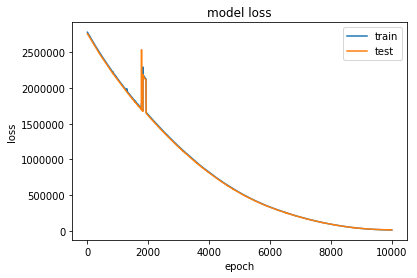

In [93]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [94]:
x_train_pred = autoencdr.predict(X_train)
threshold = np.square(x_train_pred - X_train).mean(axis=1).mean()
threshold

2782218.830947414

In [102]:
def make_prediction(autoencoder, data, threshold):   
#     print(data.shape)
    pred = np.square(data - autoencoder.predict(data)).mean(axis=1)
    pred[pred <= threshold] = 0
    pred[pred > threshold]  = 1
    
    return pred


pred_test = make_prediction(autoencoder, X_test, threshold)
pred_outliers = make_prediction(autoencoder, df_atck, threshold)


In [103]:
np.unique(pred_test, return_counts=True)

(array([0., 1.]), array([2736,    1]))

In [104]:
np.unique(pred_outliers, return_counts=True)

(array([0., 1.]), array([22750,   487]))